Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with soft-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

In [5]:
scenario = 1
path = "."

In [8]:
from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40
    
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

acc_mv_train = np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train)
print("Accuracy of MV on train: ",acc_mv_train)

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.7928367928367929
Shape (data,annotators):  (2457, 100)
Classes:  3


In [10]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

#### Delta Convergence criteria

In [7]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [11]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],8,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [6]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [33]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -29549.084767031174
2 	 -26178.657297875998 	0.6839	0.352059	0.114062
3 	 -25595.126519135338 	0.0832	0.218716	0.022290
4 	 -25385.45274967683 	0.0500	0.103388	0.008192
5 	 -25303.727117070186 	0.0235	0.043967	0.003219
6 	 -25271.376732632492 	0.0115	0.021592	0.001278
Class marginals
[0.46 0.33 0.21]


In [34]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.6109076109076109
ACC D&S on train: 0.8567358567358567


In [35]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],8,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV")

Trained model over soft-MV


In [36]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],8,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV")

Trained model over hard-MV


In [37]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],8,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S")

Trained model over D&S


In [9]:
from code.baseline import RaykarMC

#get representation needed for Raykar
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') 

### Raykar Model (joint predict model)

In [90]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 21.91 sec)	logL: -34328.133	
Iter 2/50 
M step: done,  E step: done //  (in 0.50 sec)	logL: -31295.244	Tol1: 0.08835	Tol2: 0.22991	
Iter 3/50 
M step: done,  E step: done //  (in 0.51 sec)	logL: -30858.654	Tol1: 0.01395	Tol2: 0.05645	
Iter 4/50 
M step: done,  E step: done //  (in 0.49 sec)	logL: -30725.123	Tol1: 0.00433	Tol2: 0.01269	
Finished training!


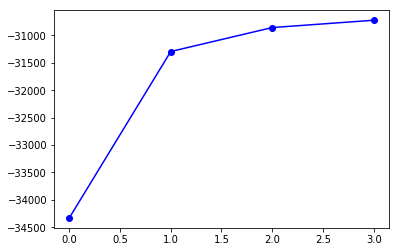

In [91]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

In [16]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

logL_hists,i = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 1.51 sec)	logL: -35028.352	
Iter 2/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -32475.736	Tol1: 0.07287	Tol2: 0.22402	
Iter 3/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -31868.795	Tol1: 0.01869	Tol2: 0.06683	
Iter 4/50 
M step: done,  E step: done //  (in 0.14 sec)	logL: -31605.061	Tol1: 0.00828	Tol2: 0.02931	
Finished training!
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 1.72 sec)	logL: -34817.297	
Iter 2/50 
M step: done,  E step: done //  (in 0.13 sec)	logL: -32168.148	Tol1: 0.07609	Tol2: 0.21777	
Iter 3/50 
M step: done,  E step: done //  (in 0.16 sec)	logL: -31485.816	Tol1: 0.02121	Tol2: 0.07456	
Iter 4/50 
M step: done,  E step: done //  (in 0.12 sec)	logL: -31259.438	Tol1: 0.00719	Tol2: 0.02561	
Finished traini

### Our Proposed

In [10]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[ 3  0  3]
 [ 0  3  4]
 [ 3  0  7]
 ...
 [ 2  0 10]
 [ 5  2  0]
 [ 5  0  4]]
shape: (2457, 3)


In [41]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Bayesian gaussian mixture say is 18 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (2000, 4)
Normalized entropy (0-1) of repeats annotations: 0.647916212093615
CPU times: user 1min, sys: 5.31 s, total: 1min 5s
Wall time: 5.23 s


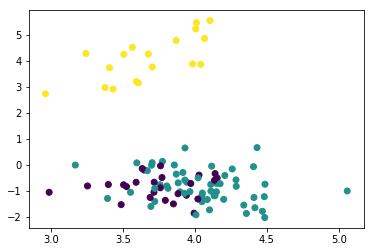

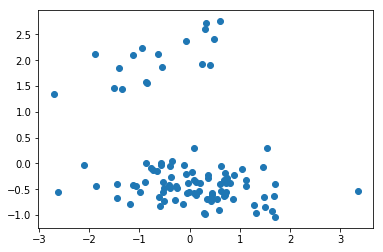

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [17]:
M_seted = 3

In [42]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003375 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.97 sec)	logL: -48511.162	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -48054.513	Tol1: 0.00941	Tol2: 0.06404	Tol3: 0.01810	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47719.367	Tol1: 0.00697	Tol2: 0.04276	Tol3: 0.00032	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47344.273	Tol1: 0.00786	Tol2: 0.05259	Tol3: 0.00106	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46911.728	Tol1: 0.00914	Tol2: 0.06177	Tol3: 0.00122	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -46431.422	Tol1: 0.01024	Tol2: 0.07072	Tol3: 0.00161	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -45893.800	Tol1: 0.011

M step: done,  E step: done //  (in 0.13 sec)	logL: -40500.523	Tol1: 0.00336	Tol2: 0.03107	Tol3: 0.00041	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40375.309	Tol1: 0.00309	Tol2: 0.03119	Tol3: 0.00003	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -40266.392	Tol1: 0.00270	Tol2: 0.03275	Tol3: 0.00064	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40161.242	Tol1: 0.00261	Tol2: 0.03302	Tol3: 0.00076	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40067.662	Tol1: 0.00233	Tol2: 0.03353	Tol3: 0.00131	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -39975.181	Tol1: 0.00231	Tol2: 0.03280	Tol3: 0.00107	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -39889.418	Tol1: 0.00215	Tol2: 0.03240	Tol3: 0.00166	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39812.441	Tol1: 0.00193	Tol2: 0.03166	Tol3: 0.00144	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39740.333	T

M step: done,  E step: done //  (in 8.47 sec)	logL: -49135.408	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -48382.749	Tol1: 0.01532	Tol2: 0.13605	Tol3: 0.03467	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47998.183	Tol1: 0.00795	Tol2: 0.06941	Tol3: 0.00420	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47577.439	Tol1: 0.00877	Tol2: 0.06598	Tol3: 0.00077	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47106.562	Tol1: 0.00990	Tol2: 0.06873	Tol3: 0.00060	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46584.205	Tol1: 0.01109	Tol2: 0.07345	Tol3: 0.00056	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -46019.388	Tol1: 0.01212	Tol2: 0.07792	Tol3: 0.00051	
Iter 8/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -45407.361	Tol1: 0.01330	Tol2: 0.08330	Tol3: 0.00064	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44747.044	Tol1: 0.01454	Tol2: 0.09046	Tol3: 0.00070	
Iter 10/

M step: done,  E step: done //  (in 0.16 sec)	logL: -48244.150	Tol1: 0.00553	Tol2: 0.04804	Tol3: 0.00598	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47954.478	Tol1: 0.00600	Tol2: 0.04707	Tol3: 0.00112	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47611.460	Tol1: 0.00715	Tol2: 0.04711	Tol3: 0.00064	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47209.364	Tol1: 0.00845	Tol2: 0.04988	Tol3: 0.00063	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46739.023	Tol1: 0.00996	Tol2: 0.05583	Tol3: 0.00058	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46193.662	Tol1: 0.01167	Tol2: 0.06258	Tol3: 0.00053	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -45584.213	Tol1: 0.01319	Tol2: 0.07322	Tol3: 0.00056	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -44919.751	Tol1: 0.01458	Tol2: 0.08386	Tol3: 0.00064	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -44224.556	Tol1: 0

M step: done,  E step: done //  (in 0.16 sec)	logL: -42283.403	Tol1: 0.01175	Tol2: 0.11120	Tol3: 0.00060	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41824.165	Tol1: 0.01086	Tol2: 0.10770	Tol3: 0.00130	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41413.208	Tol1: 0.00983	Tol2: 0.10170	Tol3: 0.00200	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -41056.437	Tol1: 0.00861	Tol2: 0.09417	Tol3: 0.00259	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40767.489	Tol1: 0.00704	Tol2: 0.08402	Tol3: 0.00271	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40523.278	Tol1: 0.00599	Tol2: 0.07335	Tol3: 0.00323	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40321.524	Tol1: 0.00498	Tol2: 0.06457	Tol3: 0.00367	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40144.798	Tol1: 0.00438	Tol2: 0.06029	Tol3: 0.00368	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39996.980	To

In [43]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004671 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03 0.04 0.58]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.81 sec)	logL: -47893.726	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -46795.137	Tol1: 0.02294	Tol2: 0.15603	Tol3: 0.00846	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45904.463	Tol1: 0.01903	Tol2: 0.09954	Tol3: 0.00415	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45109.323	Tol1: 0.01732	Tol2: 0.07261	Tol3: 0.00299	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -44392.581	Tol1: 0.01589	Tol2: 0.05718	Tol3: 0.00357	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -43708.633	Tol1: 0.01541	Tol2: 0.05617	Tol3: 0.00500	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -43069.263	Tol1

M step: done,  E step: done //  (in 0.15 sec)	logL: -48770.686	Tol1: 0.00974	Tol2: 0.07563	Tol3: 0.00499	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48406.007	Tol1: 0.00748	Tol2: 0.05467	Tol3: 0.00362	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48069.493	Tol1: 0.00695	Tol2: 0.04935	Tol3: 0.00274	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47732.295	Tol1: 0.00701	Tol2: 0.05420	Tol3: 0.00252	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47333.491	Tol1: 0.00836	Tol2: 0.06116	Tol3: 0.00215	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46855.429	Tol1: 0.01010	Tol2: 0.06882	Tol3: 0.00216	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46295.906	Tol1: 0.01194	Tol2: 0.07610	Tol3: 0.00239	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -45646.641	Tol1: 0.01402	Tol2: 0.08199	Tol3: 0.00308	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44952.155	Tol

M step: done,  E step: done //  (in 0.18 sec)	logL: -40289.915	Tol1: 0.00271	Tol2: 0.05575	Tol3: 0.00840	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40192.618	Tol1: 0.00241	Tol2: 0.05083	Tol3: 0.00726	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40103.468	Tol1: 0.00222	Tol2: 0.04976	Tol3: 0.00659	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40029.086	Tol1: 0.00185	Tol2: 0.05052	Tol3: 0.00604	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39956.745	Tol1: 0.00181	Tol2: 0.04935	Tol3: 0.00534	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39905.880	Tol1: 0.00127	Tol2: 0.05053	Tol3: 0.00486	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39845.243	Tol1: 0.00152	Tol2: 0.05038	Tol3: 0.00447	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39808.231	Tol1: 0.00093	Tol2: 0.04456	Tol3: 0.00320	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39760.909	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -41961.675	Tol1: 0.00751	Tol2: 0.08604	Tol3: 0.00386	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41686.885	Tol1: 0.00655	Tol2: 0.07965	Tol3: 0.00240	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41460.262	Tol1: 0.00544	Tol2: 0.07395	Tol3: 0.00117	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41273.626	Tol1: 0.00450	Tol2: 0.06717	Tol3: 0.00071	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41125.304	Tol1: 0.00359	Tol2: 0.06025	Tol3: 0.00030	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41001.670	Tol1: 0.00301	Tol2: 0.05130	Tol3: 0.00033	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40896.557	Tol1: 0.00256	Tol2: 0.04271	Tol3: 0.00021	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40806.601	Tol1: 0.00220	Tol2: 0.03370	Tol3: 0.00024	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40726.650	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -42921.141	Tol1: 0.01195	Tol2: 0.08532	Tol3: 0.00436	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -42443.260	Tol1: 0.01113	Tol2: 0.08519	Tol3: 0.00419	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41984.028	Tol1: 0.01082	Tol2: 0.08290	Tol3: 0.00392	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41564.574	Tol1: 0.00999	Tol2: 0.07971	Tol3: 0.00355	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -41203.304	Tol1: 0.00869	Tol2: 0.07501	Tol3: 0.00312	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40899.236	Tol1: 0.00738	Tol2: 0.06956	Tol3: 0.00263	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40626.465	Tol1: 0.00667	Tol2: 0.06359	Tol3: 0.00220	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40401.971	Tol1: 0.00553	Tol2: 0.05685	Tol3: 0.00186	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40222.830	T

In [21]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004762 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7467912  0.54407865 0.71997684]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 2.54 sec)	logL: -27206.614	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -25770.478	Tol1: 0.05279	Tol2: 0.30221	Tol3: 0.03145	
Iter 3/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -25326.270	Tol1: 0.01724	Tol2: 0.12345	Tol3: 0.03277	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25059.096	Tol1: 0.01055	Tol2: 0.08830	Tol3: 0.02965	
Iter 5/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24870.042	Tol1: 0.00754	Tol2: 0.06964	Tol3: 0.02532	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24731.788	Tol1: 0.00556	Tol2: 0.05470	Tol3: 0.02076	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL

M step: done,  E step: done //  (in 0.10 sec)	logL: -20554.781	Tol1: 0.00366	Tol2: 0.02771	Tol3: 0.00332	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.12851858 0.10986201 0.9760108 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 2.63 sec)	logL: -32049.764	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -26166.403	Tol1: 0.18357	Tol2: 0.95298	Tol3: 0.05767	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24835.970	Tol1: 0.05085	Tol2: 0.21150	Tol3: 0.02389	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24223.425	Tol1: 0.02466	Tol2: 0.22875	Tol3: 0.00975	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23727.428	Tol1: 0.02048	Tol2: 0.18297	Tol3: 0.01229	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23285.813	Tol1: 0.01861	Tol2: 0.14700	Tol3: 0.01772	
Iter 7/50
M step: done,  

M step: done,  E step: done //  (in 0.11 sec)	logL: -22234.537	Tol1: 0.01463	Tol2: 0.11908	Tol3: 0.00927	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21918.255	Tol1: 0.01422	Tol2: 0.11704	Tol3: 0.00816	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21635.645	Tol1: 0.01289	Tol2: 0.11465	Tol3: 0.00718	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21389.529	Tol1: 0.01138	Tol2: 0.10742	Tol3: 0.00609	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21167.790	Tol1: 0.01037	Tol2: 0.09669	Tol3: 0.00493	
Iter 10/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20981.681	Tol1: 0.00879	Tol2: 0.08490	Tol3: 0.00413	
Iter 11/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20814.489	Tol1: 0.00797	Tol2: 0.07342	Tol3: 0.00362	
Iter 12/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20683.728	Tol1: 0.00628	Tol2: 0.06094	Tol3: 0.00312	
Iter 13/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20570.902	Tol1:

M step: done,  E step: done //  (in 0.10 sec)	logL: -19788.815	Tol1: 0.00278	Tol2: 0.03563	Tol3: 0.00187	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19744.221	Tol1: 0.00225	Tol2: 0.03226	Tol3: 0.00145	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19711.814	Tol1: 0.00164	Tol2: 0.02773	Tol3: 0.00126	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.68197536 0.27996108 0.39640495]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.57 sec)	logL: -28068.265	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24195.679	Tol1: 0.13797	Tol2: 0.63023	Tol3: 0.05266	
Iter 3/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23409.788	Tol1: 0.03248	Tol2: 0.24619	Tol3: 0.02821	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23084.020	Tol1: 0.01392	Tol2: 0.11406	Tol3: 0.00271	
Iter 5/50
M step: done,

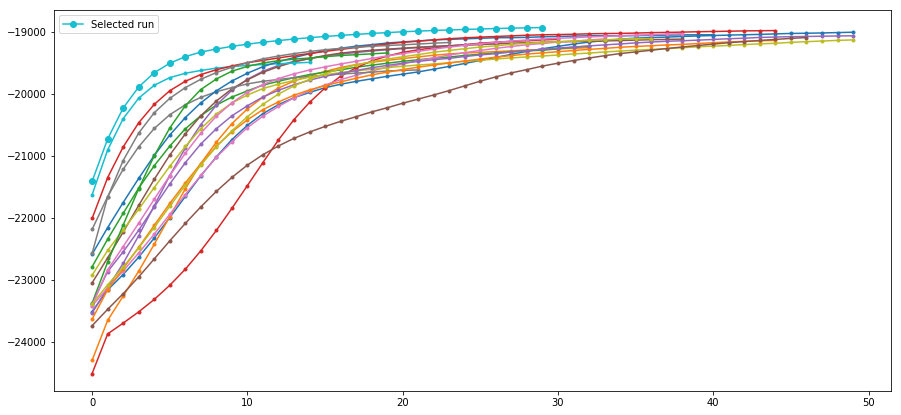

In [74]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

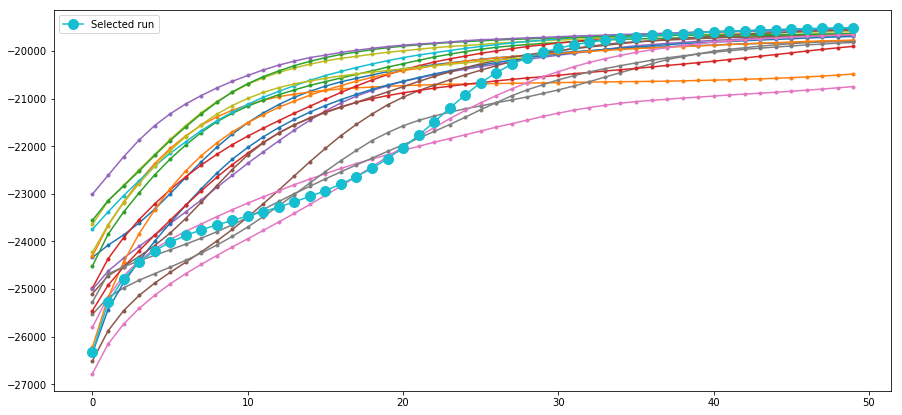

In [52]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [11]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [26]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.876272      0.876272
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.897436      0.897436
====  ======  ==========  ============


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [27]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7663817663817664


*** Soft-Majority (Train with softMV) ***
Train


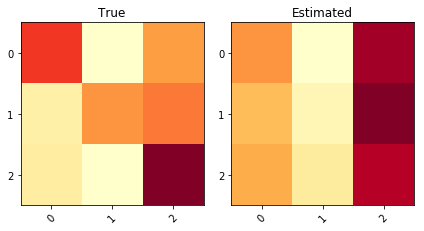

KL divergence: 0.2830	Pearson Correlation between diagonals: 0.9917


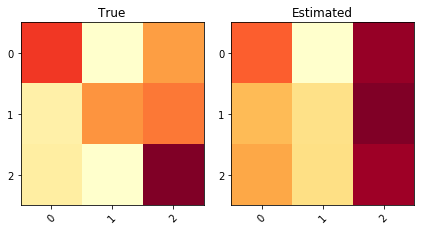

KL divergence: 0.2486	Pearson Correlation between diagonals: 0.9857


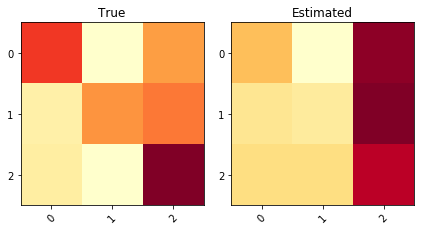

KL divergence: 0.2754	Pearson Correlation between diagonals: 0.9909


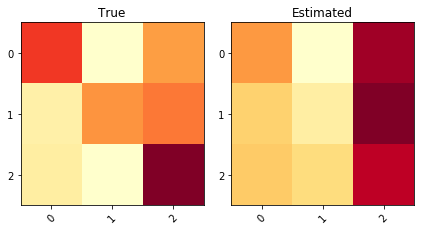

KL divergence: 0.2758	Pearson Correlation between diagonals: 0.9972


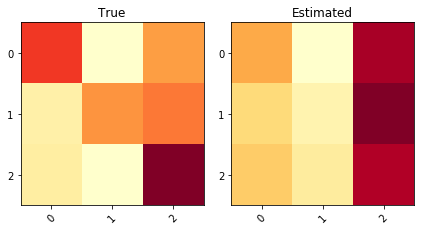

KL divergence: 0.2636	Pearson Correlation between diagonals: 1.0000


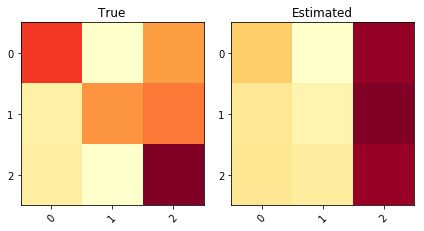

KL divergence: 0.2655	Pearson Correlation between diagonals: 0.9850


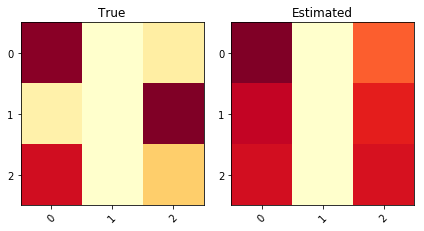

KL divergence: 0.2543	Pearson Correlation between diagonals: 0.8458


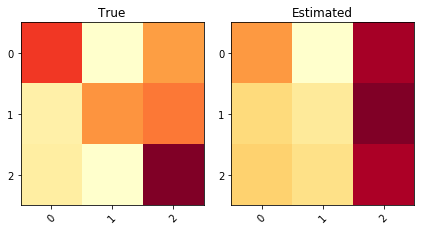

KL divergence: 0.2516	Pearson Correlation between diagonals: 0.9996


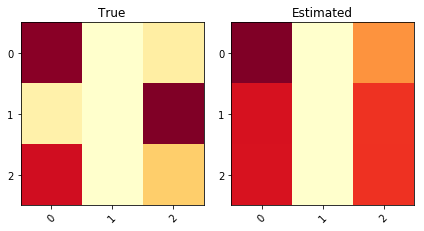

KL divergence: 0.2281	Pearson Correlation between diagonals: 0.8974


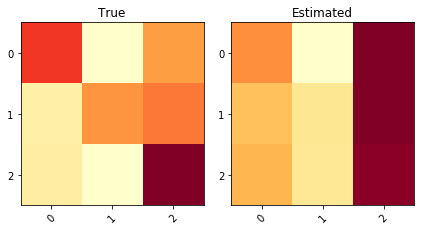

KL divergence: 0.2418	Pearson Correlation between diagonals: 0.9999


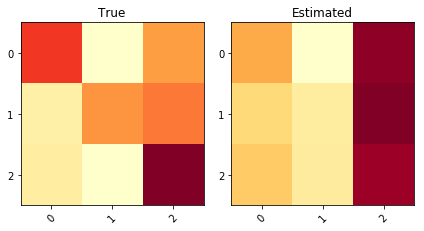

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.9983


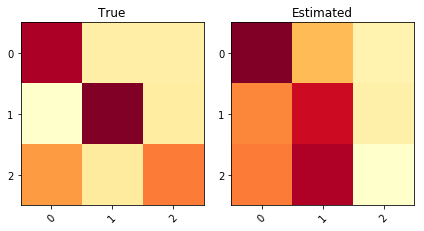

KL divergence: 0.3745	Pearson Correlation between diagonals: 0.9351


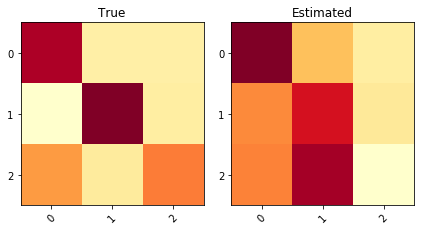

KL divergence: 0.3844	Pearson Correlation between diagonals: 0.9249


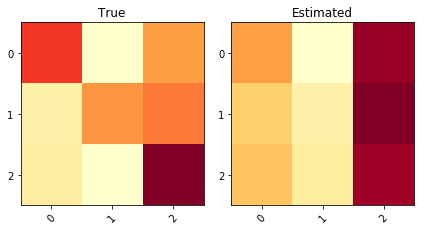

KL divergence: 0.2577	Pearson Correlation between diagonals: 0.9999


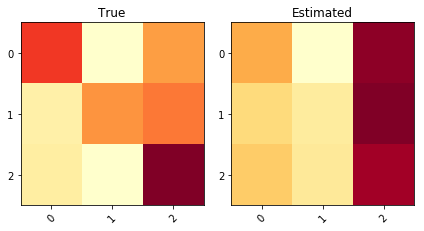

KL divergence: 0.2522	Pearson Correlation between diagonals: 0.9977
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.457061      0.457061   0.287433  0.0794692            0.930672
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.47619       0.47619
====  ======  ==========  ============


In [28]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


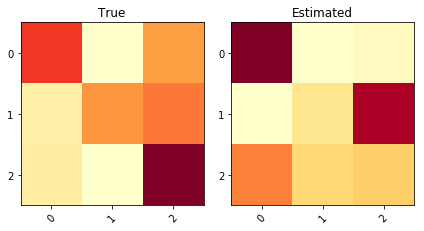

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


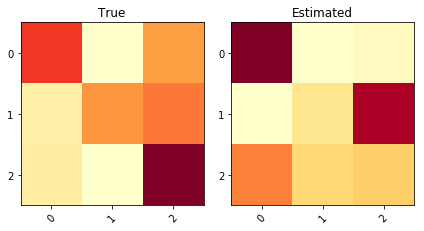

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


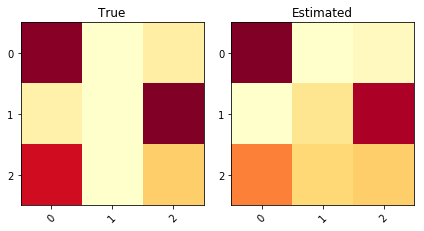

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9875


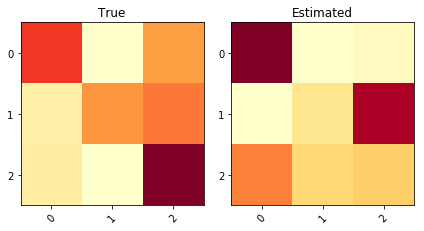

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


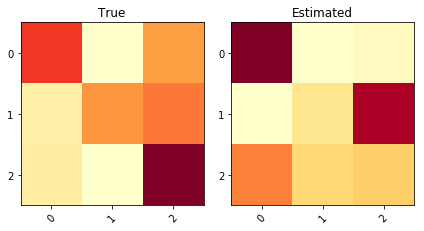

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


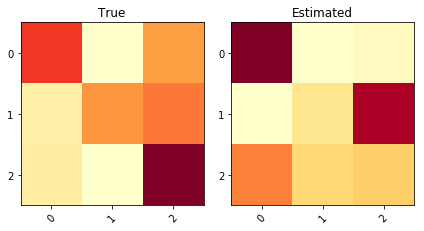

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


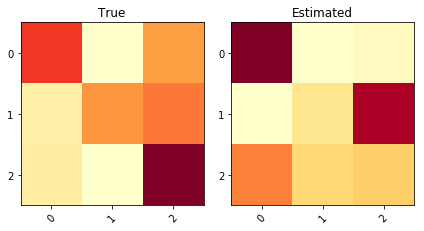

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


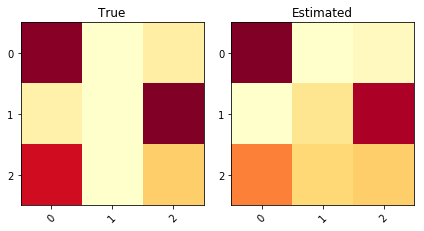

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9875


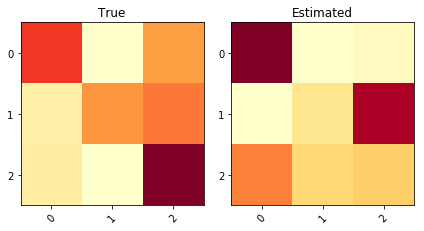

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


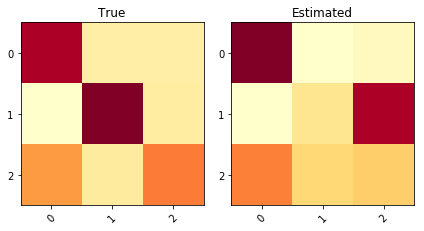

KL divergence: 0.4550	Pearson Correlation between diagonals: 0.2018


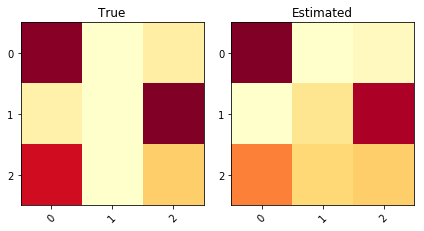

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9875


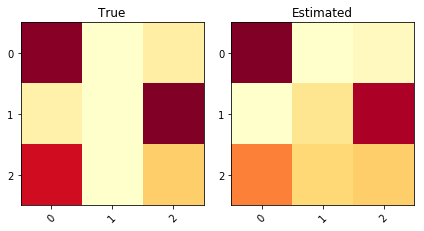

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9875


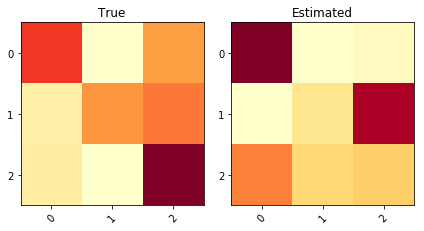

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


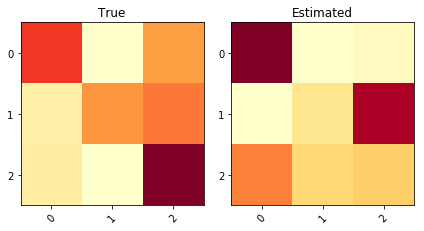

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


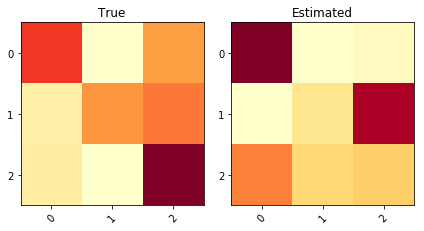

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.457061      0.457061   0.509418   0.172515            0.281329
====  ======  ==========  ============  =========  =========  ==================


In [29]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


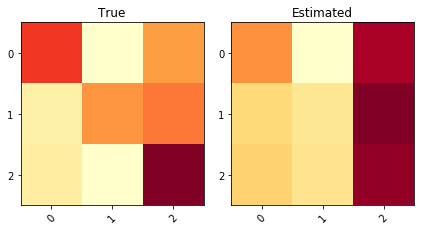

KL divergence: 0.2252	Pearson Correlation between diagonals: 0.9997


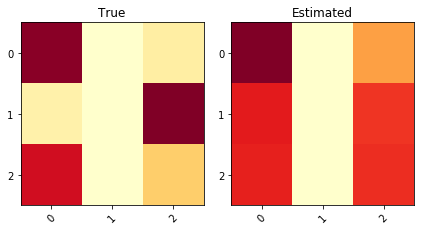

KL divergence: 0.2202	Pearson Correlation between diagonals: 0.8928


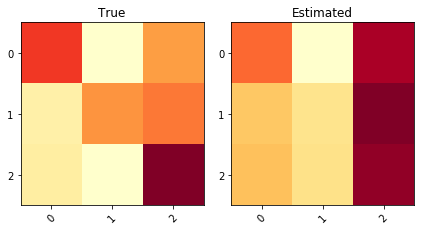

KL divergence: 0.2230	Pearson Correlation between diagonals: 0.9922


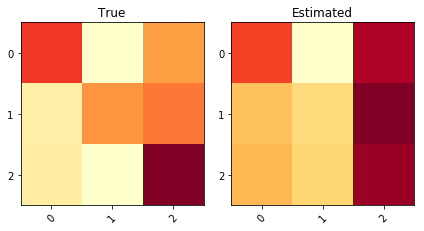

KL divergence: 0.2293	Pearson Correlation between diagonals: 0.9731


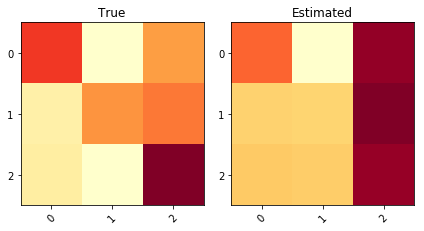

KL divergence: 0.2288	Pearson Correlation between diagonals: 0.9970


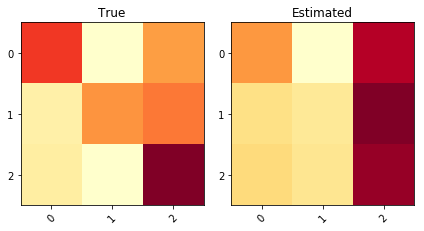

KL divergence: 0.2163	Pearson Correlation between diagonals: 1.0000


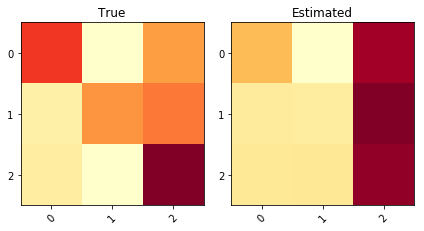

KL divergence: 0.2352	Pearson Correlation between diagonals: 0.9889


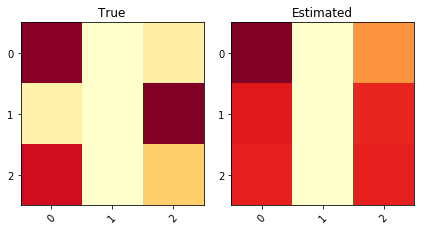

KL divergence: 0.2243	Pearson Correlation between diagonals: 0.8742


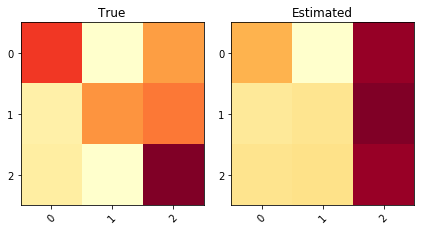

KL divergence: 0.2340	Pearson Correlation between diagonals: 0.9886


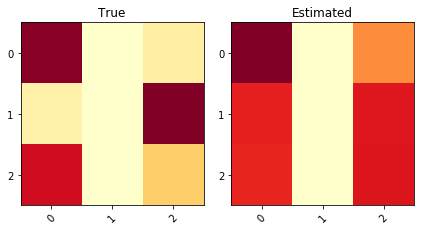

KL divergence: 0.2206	Pearson Correlation between diagonals: 0.8565


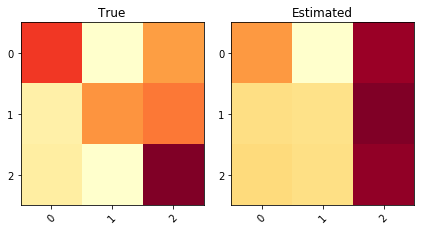

KL divergence: 0.2267	Pearson Correlation between diagonals: 0.9988


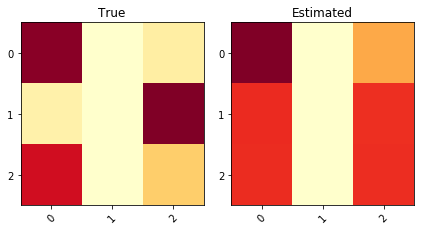

KL divergence: 0.2090	Pearson Correlation between diagonals: 0.8924


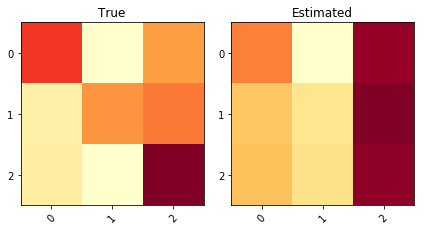

KL divergence: 0.2287	Pearson Correlation between diagonals: 0.9979


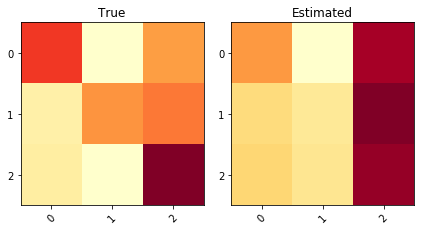

KL divergence: 0.2278	Pearson Correlation between diagonals: 1.0000


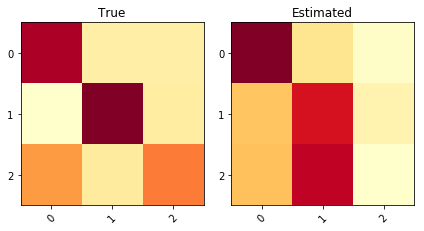

KL divergence: 0.3506	Pearson Correlation between diagonals: 0.9233
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.496133      0.496133   0.259383  0.0725451            0.932226
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.500611      0.500611
====  ======  ==========  ============


In [30]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


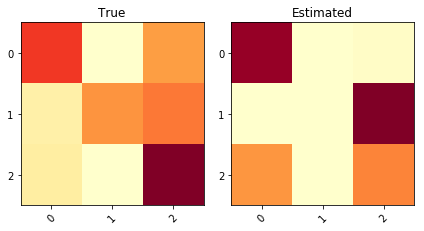

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


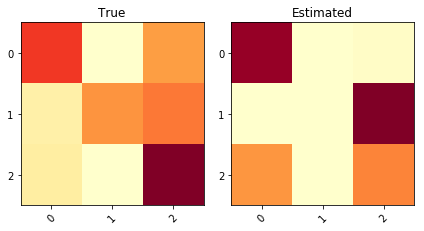

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


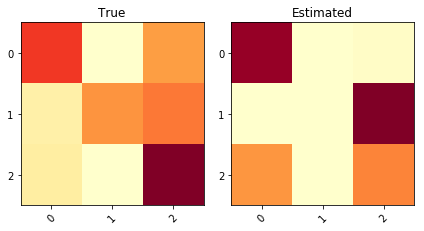

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


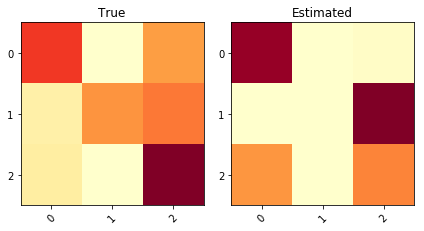

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


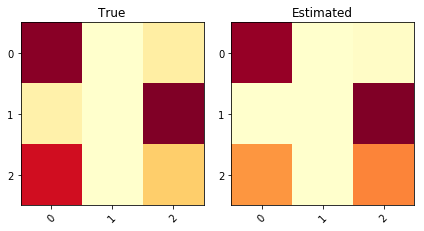

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.9580


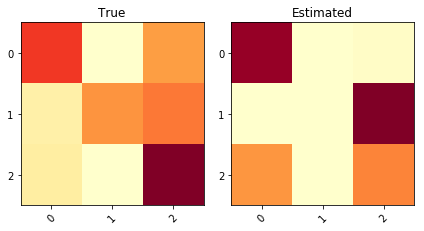

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


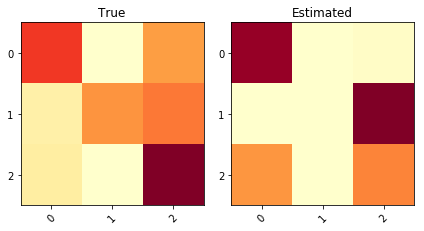

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


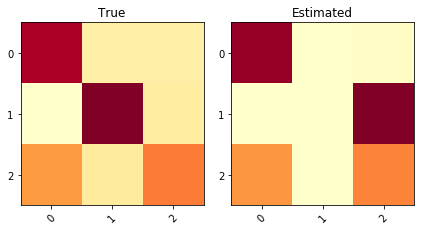

KL divergence: 5.5035	Pearson Correlation between diagonals: -0.2431


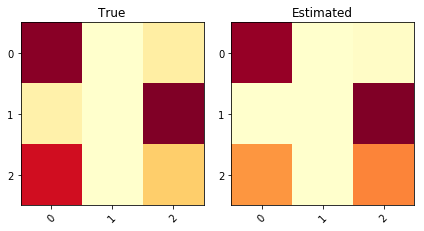

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.9580


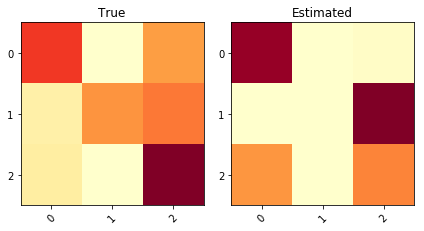

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


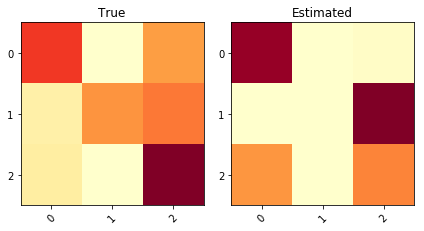

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


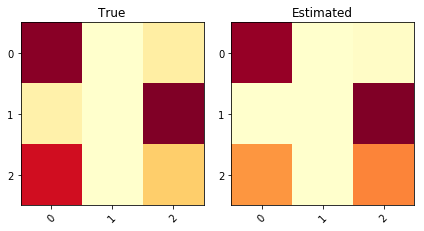

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.9580


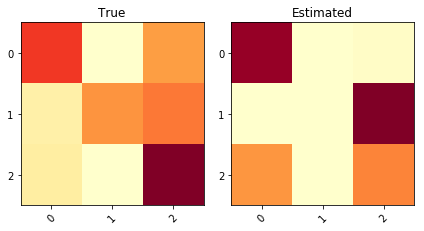

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


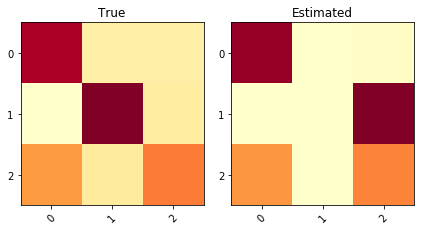

KL divergence: 5.5035	Pearson Correlation between diagonals: -0.2431


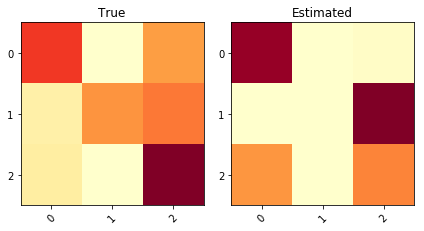

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.496133      0.496133    2.81409   0.186959             0.37137
====  ======  ==========  ============  =========  =========  ==================


In [31]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


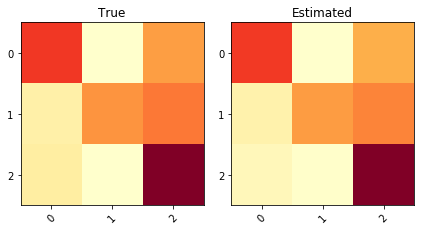

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9997


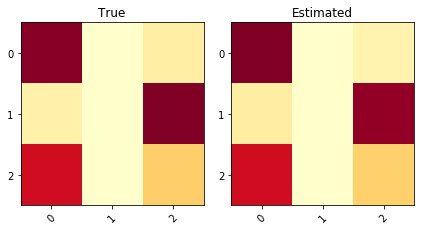

KL divergence: 0.0030	Pearson Correlation between diagonals: 0.9999


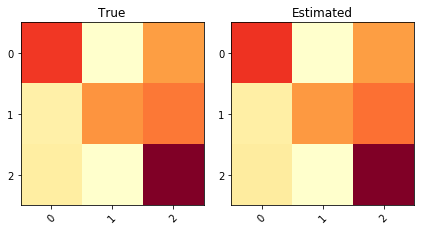

KL divergence: 0.0004	Pearson Correlation between diagonals: 0.9991


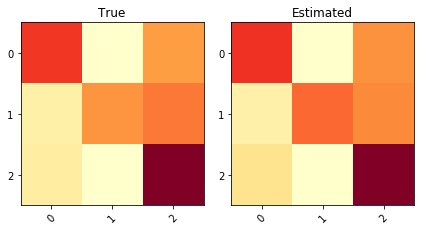

KL divergence: 0.0057	Pearson Correlation between diagonals: 0.9933


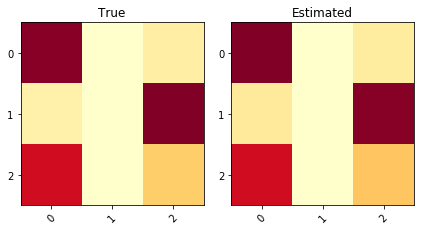

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9996


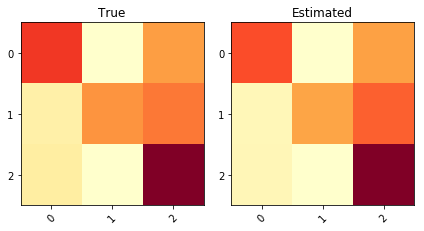

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9996


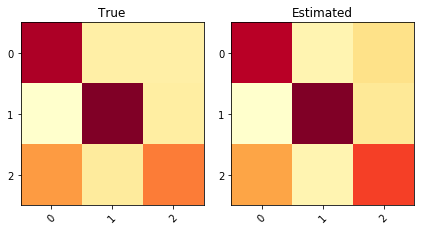

KL divergence: 0.0192	Pearson Correlation between diagonals: 0.9884


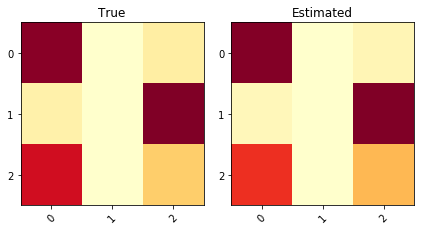

KL divergence: 0.0132	Pearson Correlation between diagonals: 0.9971


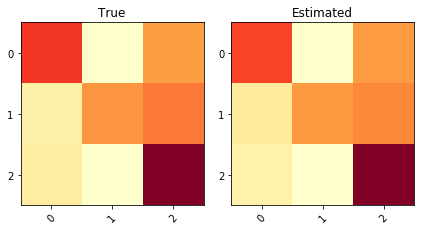

KL divergence: 0.0024	Pearson Correlation between diagonals: 0.9992


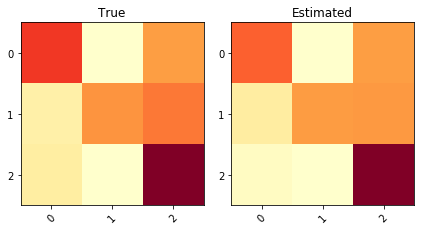

KL divergence: 0.0255	Pearson Correlation between diagonals: 0.9887


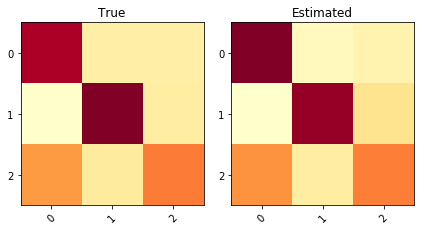

KL divergence: 0.0174	Pearson Correlation between diagonals: 0.9578


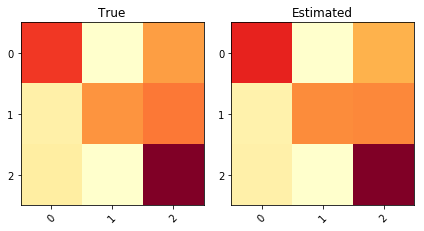

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9971


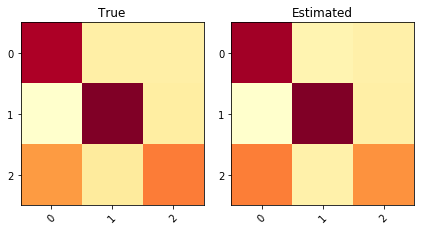

KL divergence: 0.0062	Pearson Correlation between diagonals: 0.9977


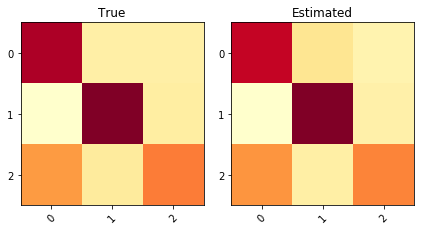

KL divergence: 0.0064	Pearson Correlation between diagonals: 0.9938


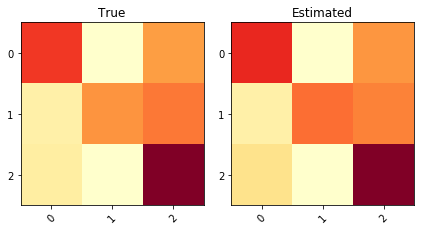

KL divergence: 0.0052	Pearson Correlation between diagonals: 0.9993
A result
 ====  ======  ==========  ============  ==========  ==========  ==================
  ..            Accuracy    F1 (micro)     Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  ==========  ==========  ==================
   0  Global    0.619455      0.619455  0.00992152  0.00239135            0.988719
====  ======  ==========  ============  ==========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.595849      0.595849
====  ======  ==========  ============


In [32]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


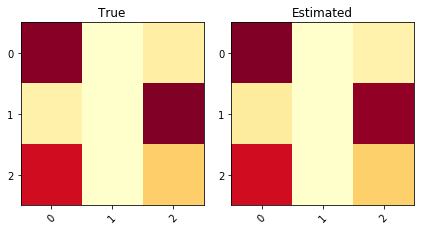

KL divergence: 0.0162	Pearson Correlation between diagonals: 0.9999


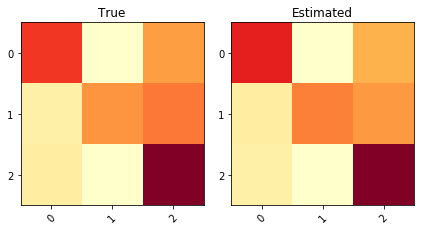

KL divergence: 0.0145	Pearson Correlation between diagonals: 0.9980


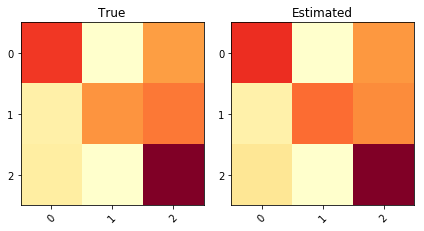

KL divergence: 0.0130	Pearson Correlation between diagonals: 0.9959


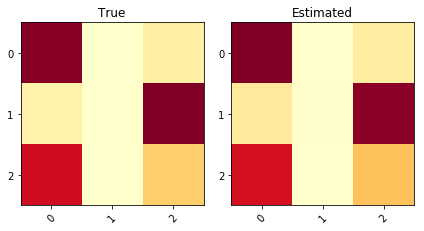

KL divergence: 0.0183	Pearson Correlation between diagonals: 0.9994


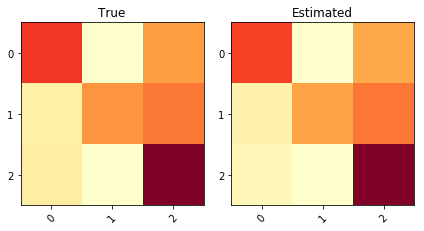

KL divergence: 0.0118	Pearson Correlation between diagonals: 1.0000


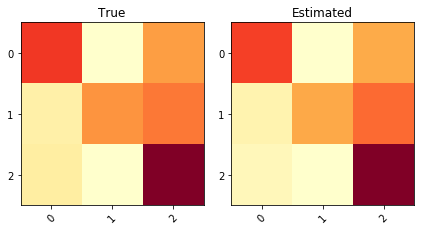

KL divergence: 0.0140	Pearson Correlation between diagonals: 0.9991


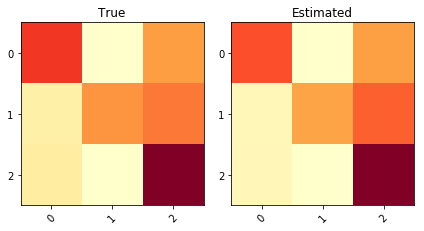

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9993


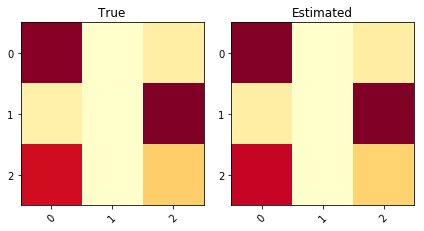

KL divergence: 0.0135	Pearson Correlation between diagonals: 0.9998


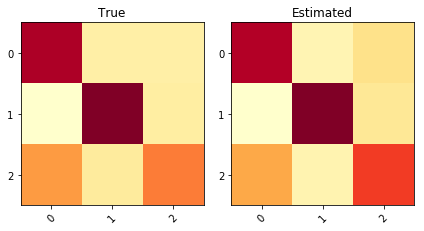

KL divergence: 0.0221	Pearson Correlation between diagonals: 0.9917


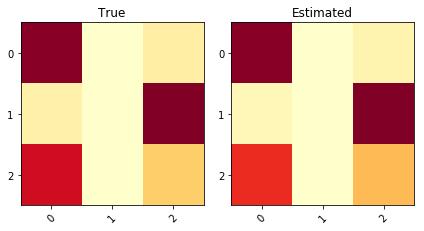

KL divergence: 0.0185	Pearson Correlation between diagonals: 0.9973


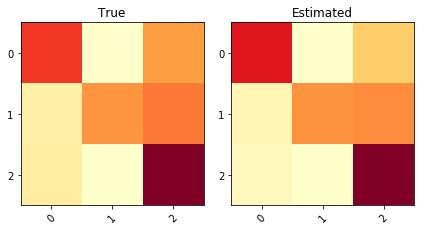

KL divergence: 0.0270	Pearson Correlation between diagonals: 0.9844


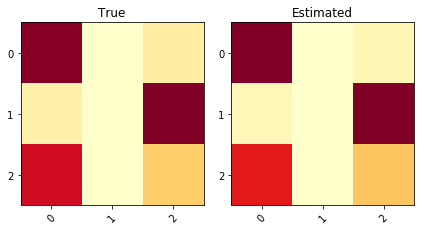

KL divergence: 0.0173	Pearson Correlation between diagonals: 0.9997


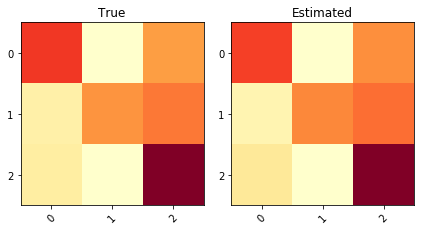

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9956


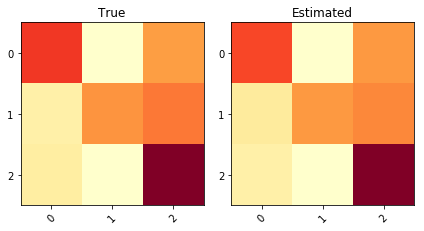

KL divergence: 0.0107	Pearson Correlation between diagonals: 0.9982


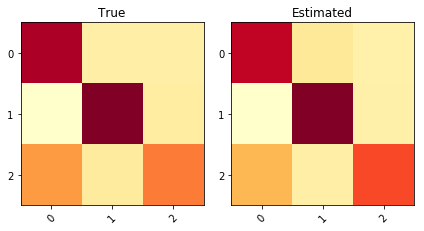

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9795
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.908425      0.908425  0.0164586  0.00487151            0.988983        0.143644
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.663532                0.734662
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.91

In [33]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


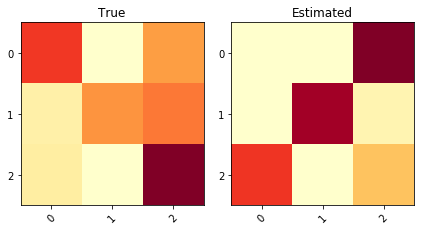

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


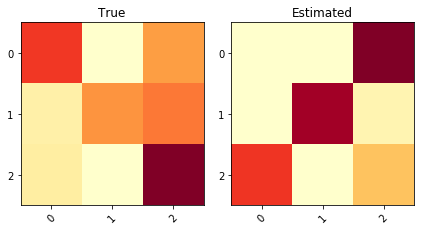

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


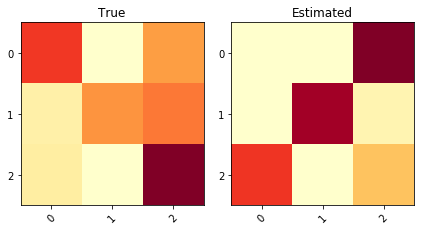

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


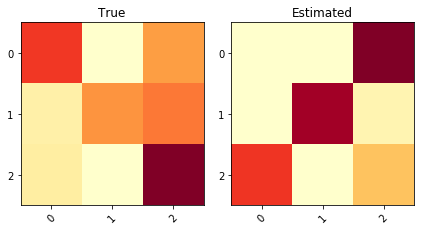

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


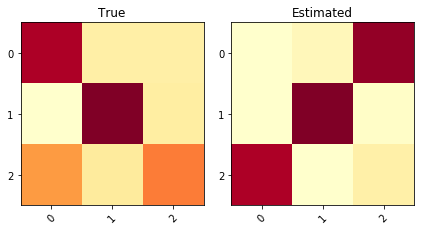

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


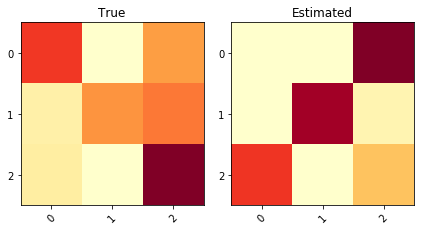

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


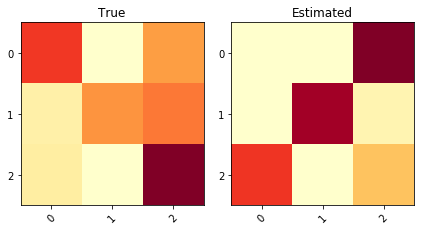

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


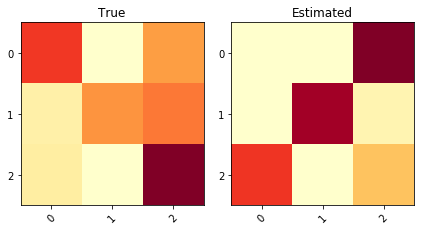

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


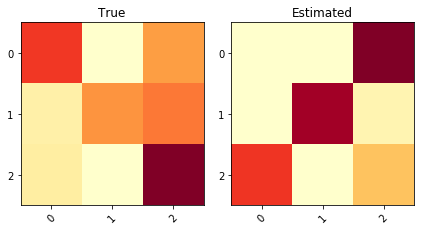

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


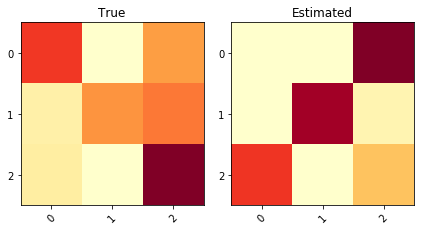

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


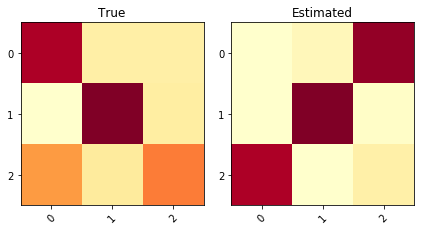

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


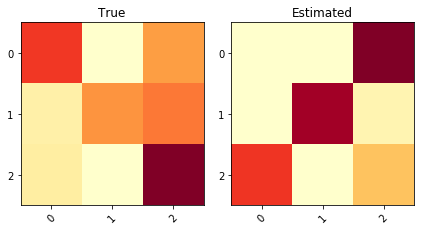

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


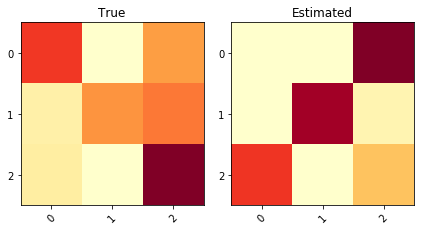

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


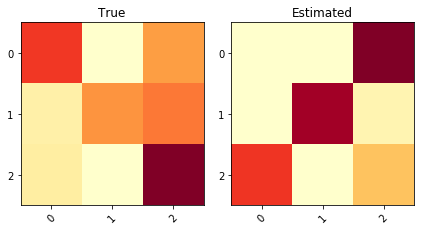

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


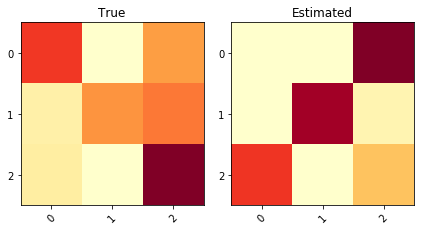

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.387464      0.387464    1.46138   0.203843           -0.344831       0.0975104
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.661312                0.727459
====  =======================  ======================
Test


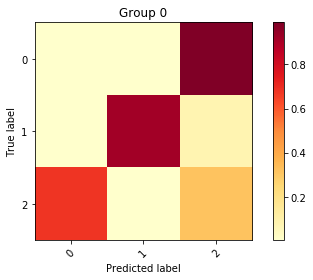

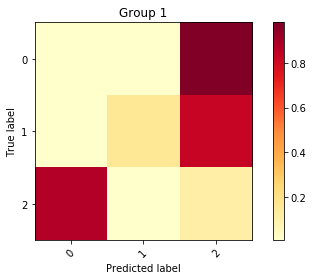

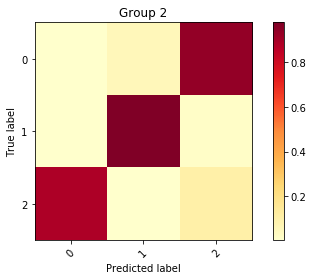

Inertia: 0.09433624582986037
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.548259      54   0.332222    0.413273     2.34267       0.499222   0.0799397    0.802198      0.802198
   1         1  0.16093       16   0.34057     0.0939899    2.8462        0.213318  -0.239343     0.630037      0.630037
   2         2  0.290811      29   0.252397    0.363872     2.39851       0.424208   0.0305391    0.882784      0.882784
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [34]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#con tol 2
832723/ 0,612666 #pre init 5
862027 / 0,567259 #pre init 1
904762 / 0,480586 # pre init 0

In [ ]:
#con tol 3
873016/0,465721 #pre init 5
344322/1,2807 #pre init 1
882784/0,609833 #pre init 0

*** Ours (2) multiples runs***
Train


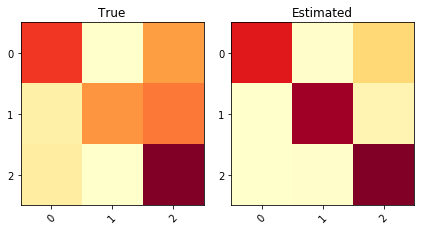

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


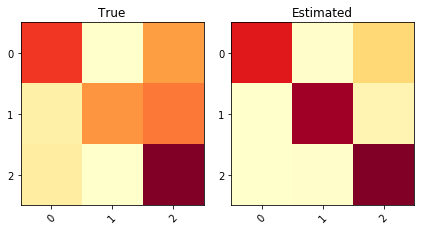

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


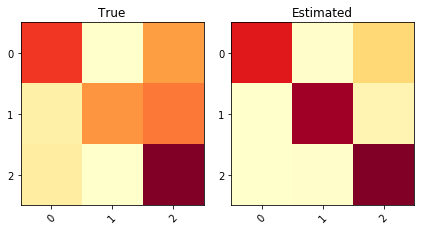

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


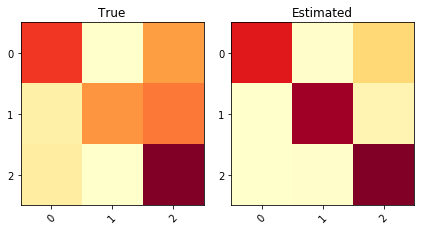

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


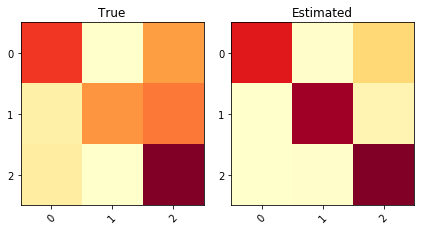

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


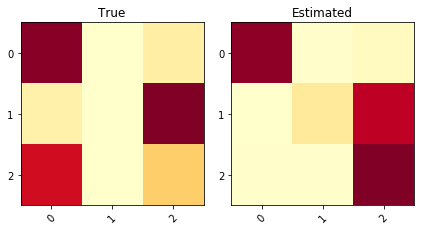

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


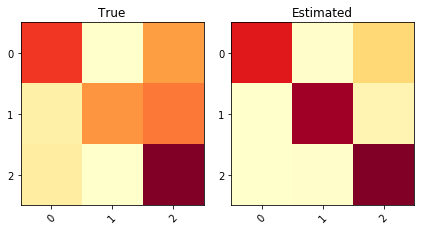

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


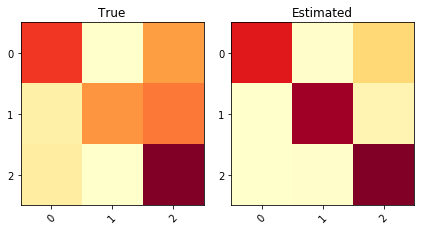

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


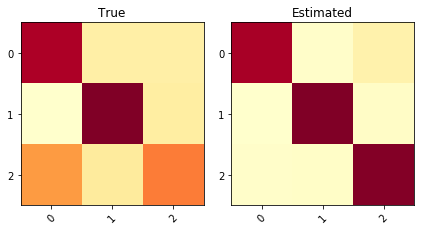

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


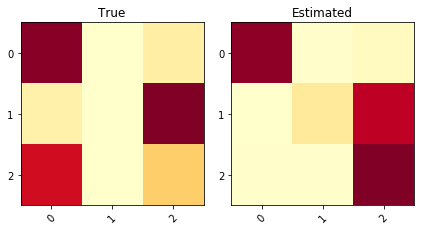

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


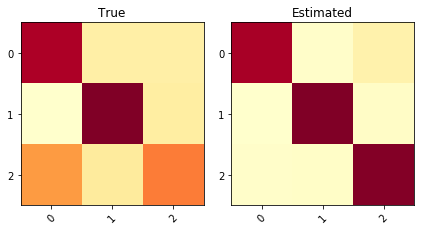

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


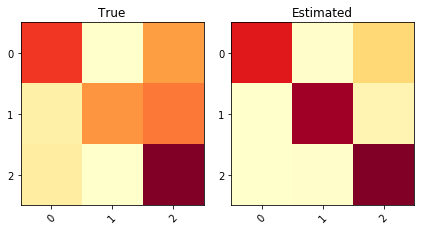

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


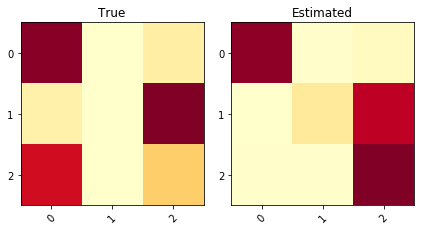

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


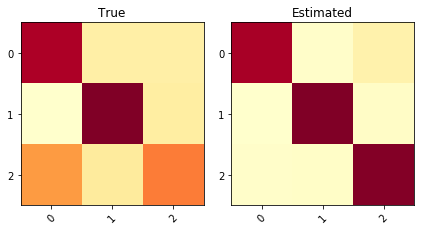

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


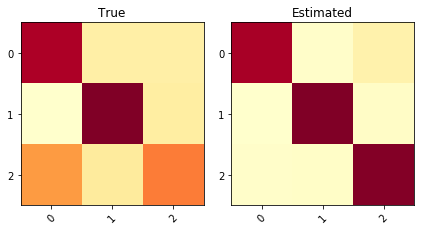

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.892552      0.892552   0.600229  0.0875265            0.289699       0.0963832
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.658511                 0.73373
====  =======================  ======================
Test


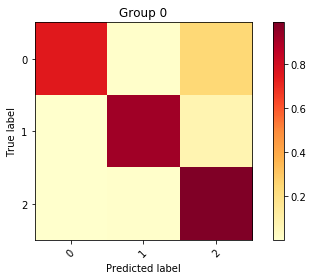

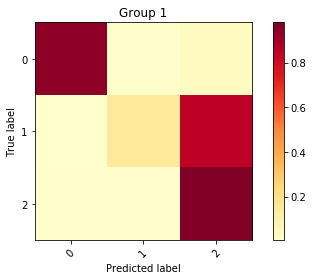

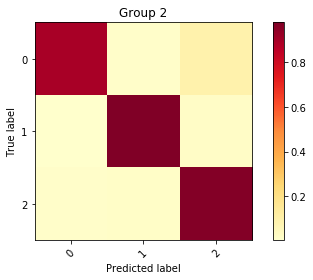

Inertia: 0.0972544342900316
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.544033      54   0.310449     0.8868    0.12712         0.938615   0.553466    0.84127       0.84127
   1         1  0.181161      18   0.261901     0.689919  0.675244        0.757545   0.356585    0.634921      0.634921
   2         2  0.274806      27   0.211517     0.948153  0.0540261       0.973305   0.614819    0.910867      0.910867
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [35]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

 870574 / 0,498641 #con tol2
942613 / 0,471945 #pre init 1
86569/0,579983 #pre init 0

In [ ]:
#con tol3
913309/ 0,539815 #pre init 5
879121/ 0,729936 #pre init 1
875458/ 0,663098 #pre init 0

*** Ours (3) multiples runs***
Train


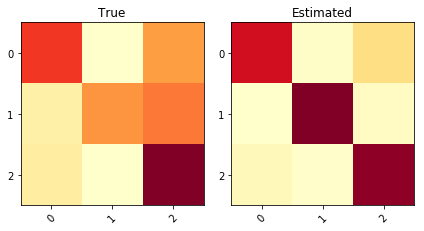

KL divergence: 0.4482	Pearson Correlation between diagonals: -0.0250


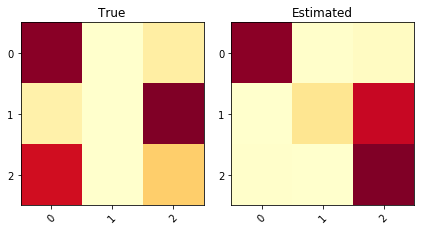

KL divergence: 1.0874	Pearson Correlation between diagonals: 0.7051


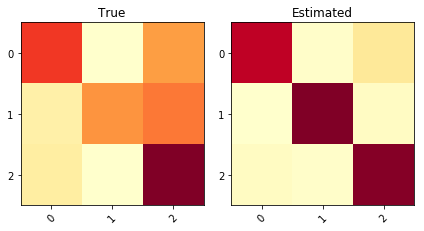

KL divergence: 0.5280	Pearson Correlation between diagonals: 0.0335


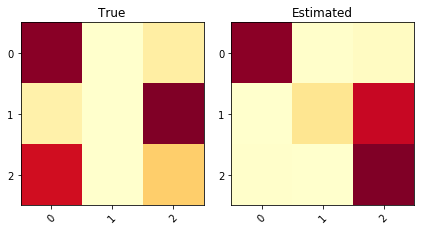

KL divergence: 1.0874	Pearson Correlation between diagonals: 0.7051


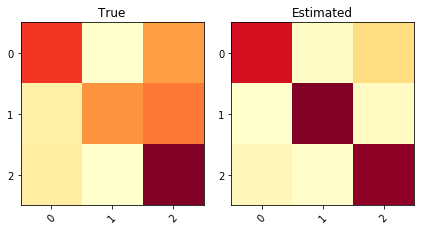

KL divergence: 0.4400	Pearson Correlation between diagonals: -0.0302


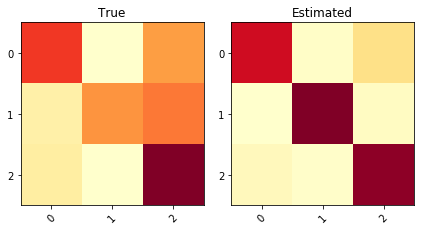

KL divergence: 0.4595	Pearson Correlation between diagonals: -0.0175


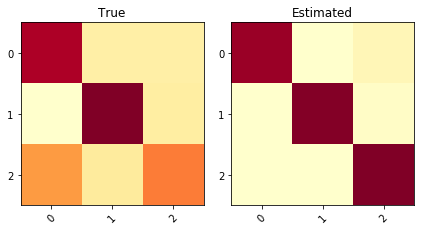

KL divergence: 0.7494	Pearson Correlation between diagonals: -0.5003


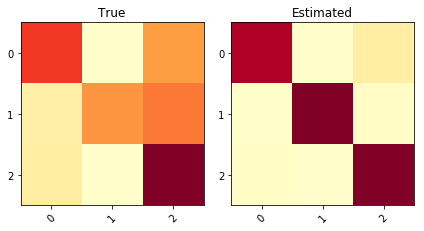

KL divergence: 0.5926	Pearson Correlation between diagonals: 0.0925


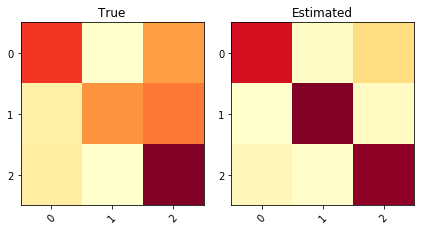

KL divergence: 0.4398	Pearson Correlation between diagonals: -0.0303


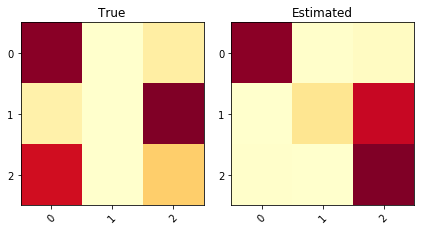

KL divergence: 1.0874	Pearson Correlation between diagonals: 0.7051


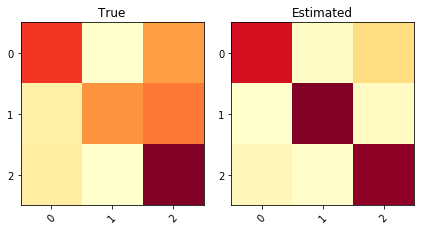

KL divergence: 0.4397	Pearson Correlation between diagonals: -0.0304


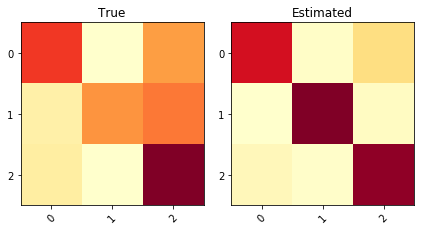

KL divergence: 0.4425	Pearson Correlation between diagonals: -0.0286


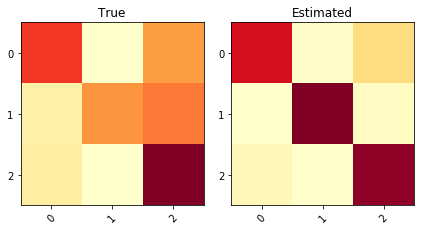

KL divergence: 0.4381	Pearson Correlation between diagonals: -0.0314


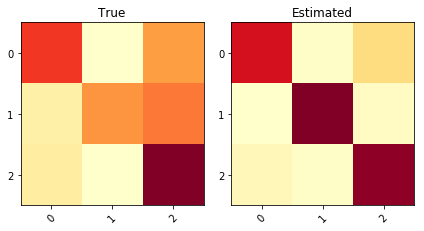

KL divergence: 0.4372	Pearson Correlation between diagonals: -0.0320


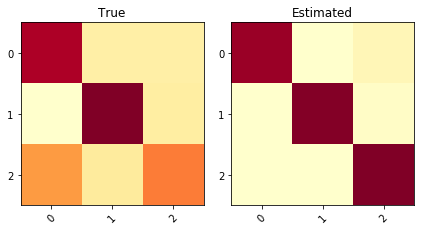

KL divergence: 0.7497	Pearson Correlation between diagonals: -0.5004
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.916158      0.916158   0.685863  0.0973456           0.0451263       0.0909474
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                   0.6579                 0.75706
====  =======================  ======================
Test


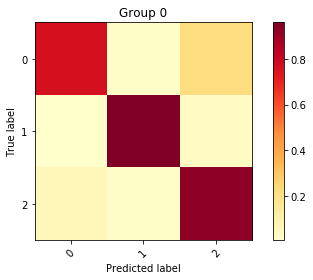

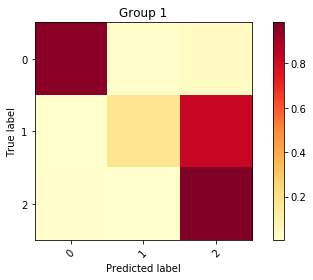

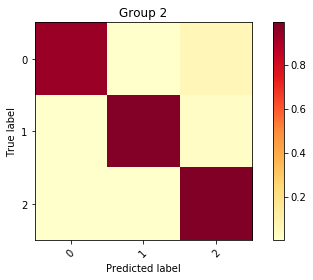

Inertia: 0.09903661006440719
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.134065      13   0.369423     0.882898   0.129473       0.937177   0.549564    0.925519      0.925519
   1         1  0.29353       29   0.251069     0.70568    0.606233       0.774768   0.372347    0.648352      0.648352
   2         2  0.572405      57   0.138439     0.968977   0.031831       0.984201   0.635643    0.931624      0.931624
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [36]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
#con tol2
84127 /  0,944489
875458 / 0,695265 #pre init 1
935287 / 0,411736 #pre init 0

In [ ]:
#con tol3
923077 / 0,579925 #pre init 5
925519 / 0,433611 #pre init 1
369963 / 1,47762 #pre init 0

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [52]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6581196581196581


*** Soft-Majority (Train with softMV) ***
Train


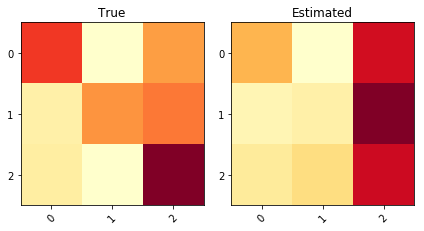

KL divergence: 0.2514	Pearson Correlation between diagonals: 0.9996


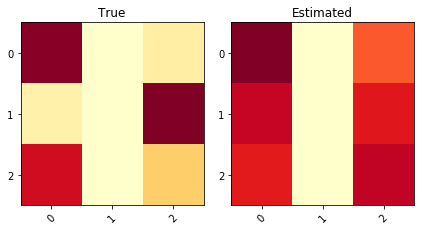

KL divergence: 0.2643	Pearson Correlation between diagonals: 0.8072


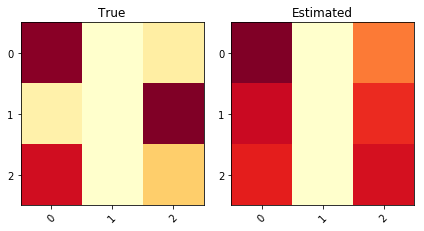

KL divergence: 0.2560	Pearson Correlation between diagonals: 0.8426


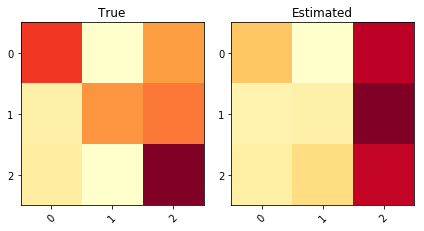

KL divergence: 0.2651	Pearson Correlation between diagonals: 0.9924


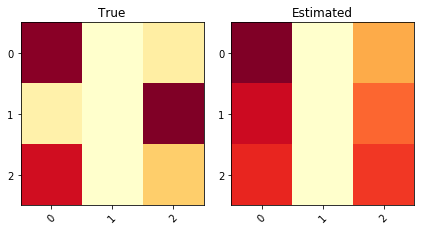

KL divergence: 0.2546	Pearson Correlation between diagonals: 0.9044


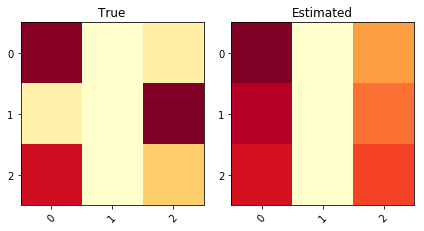

KL divergence: 0.2712	Pearson Correlation between diagonals: 0.9170


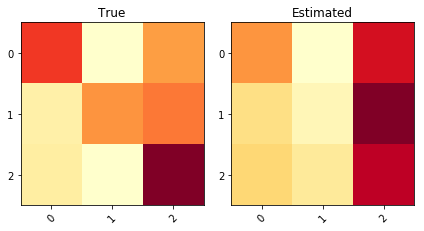

KL divergence: 0.2525	Pearson Correlation between diagonals: 0.9912


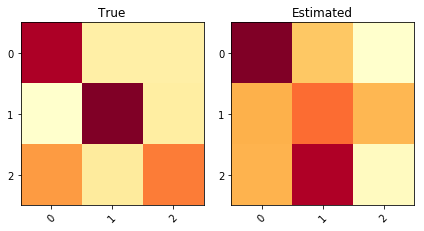

KL divergence: 0.3978	Pearson Correlation between diagonals: 0.7899


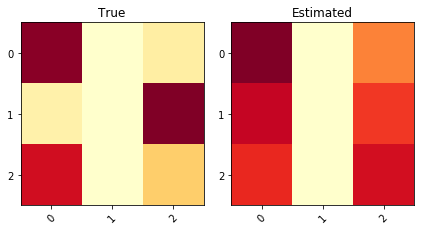

KL divergence: 0.2663	Pearson Correlation between diagonals: 0.8391


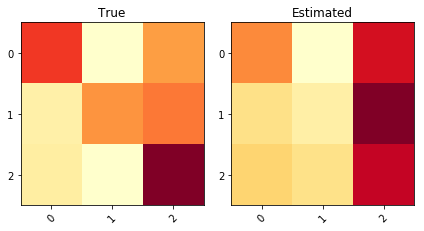

KL divergence: 0.2458	Pearson Correlation between diagonals: 0.9852


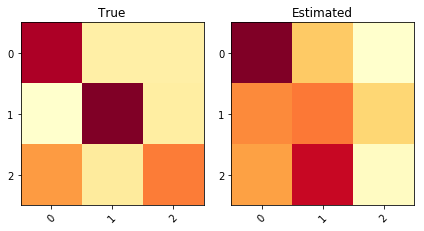

KL divergence: 0.4023	Pearson Correlation between diagonals: 0.7746


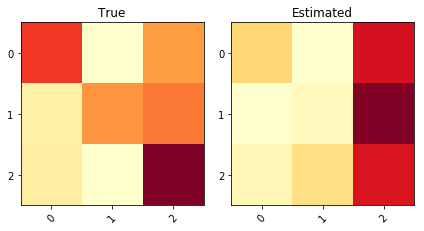

KL divergence: 0.2859	Pearson Correlation between diagonals: 0.9935


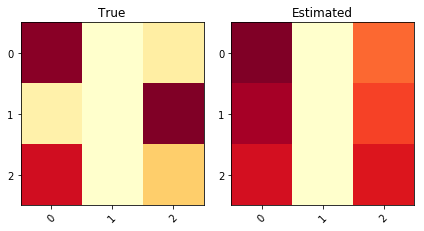

KL divergence: 0.2814	Pearson Correlation between diagonals: 0.8554


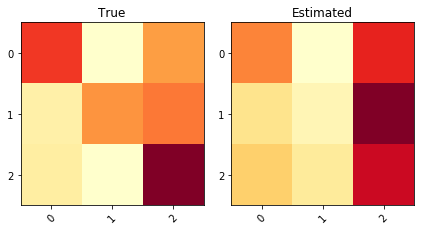

KL divergence: 0.2463	Pearson Correlation between diagonals: 0.9718


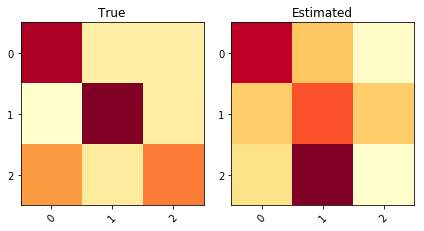

KL divergence: 0.4060	Pearson Correlation between diagonals: 0.8878
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.46398       0.46398   0.304018  0.0837234            0.890157
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.498168      0.498168
====  ======  ==========  ============


In [53]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


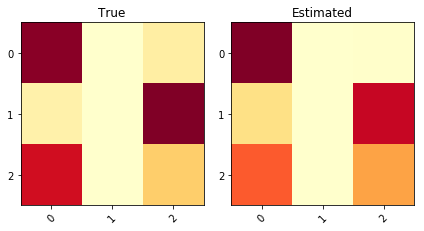

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


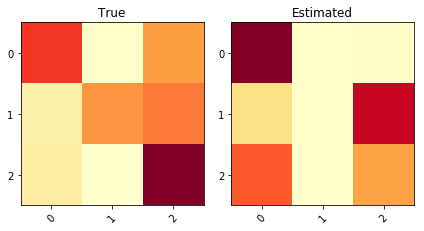

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


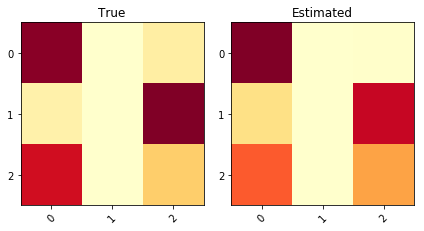

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


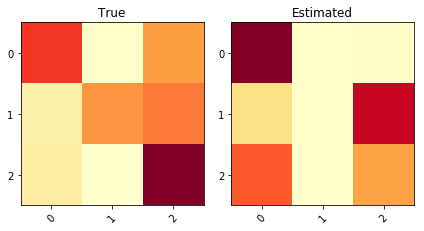

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


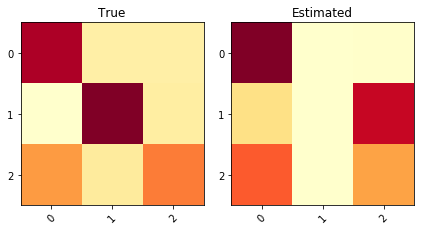

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.1070


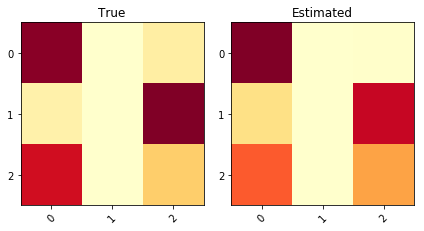

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


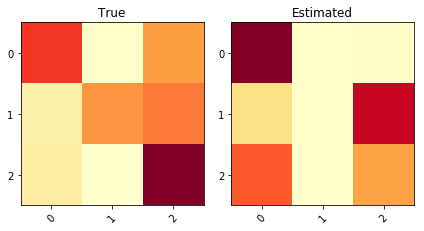

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


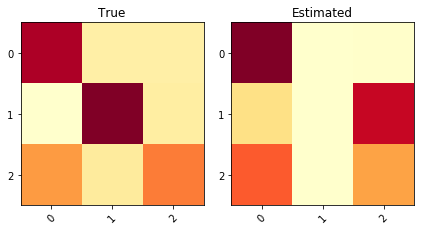

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.1070


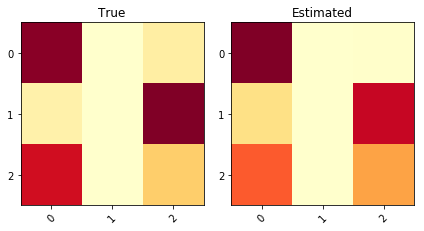

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


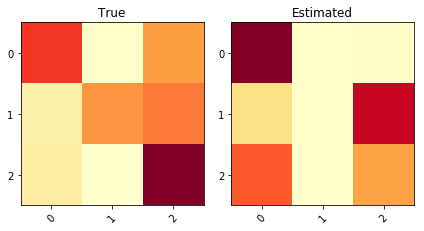

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


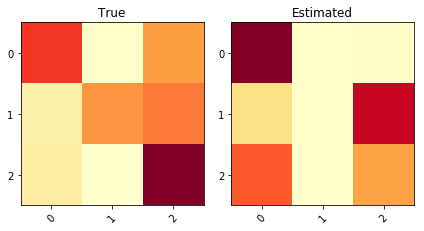

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


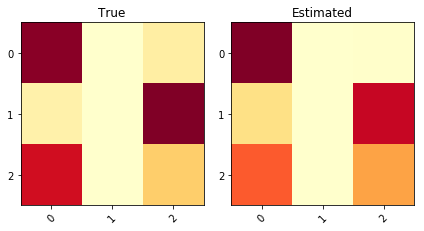

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


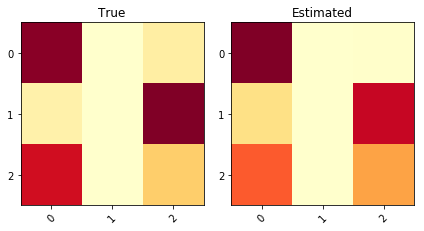

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


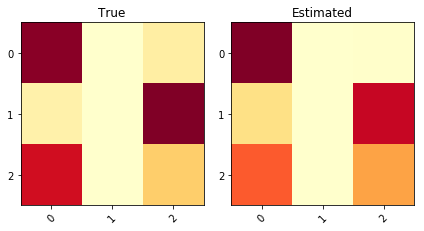

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


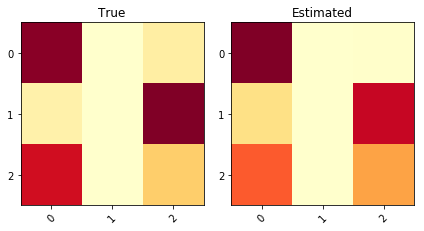

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.46398       0.46398    2.75888   0.153648            0.416436
====  ======  ==========  ============  =========  =========  ==================


In [54]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


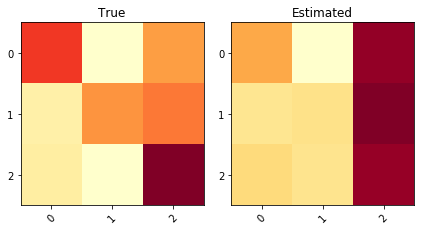

KL divergence: 0.2332	Pearson Correlation between diagonals: 0.9920


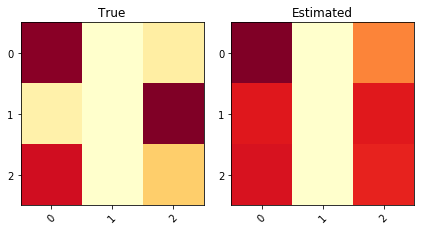

KL divergence: 0.2176	Pearson Correlation between diagonals: 0.8796


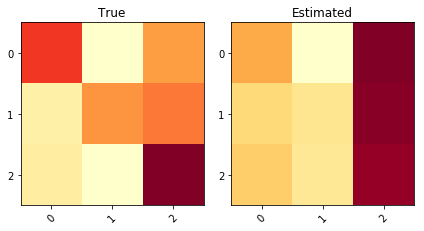

KL divergence: 0.2465	Pearson Correlation between diagonals: 0.9935


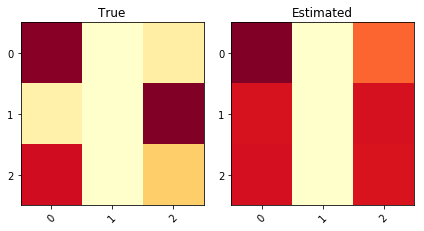

KL divergence: 0.2300	Pearson Correlation between diagonals: 0.8524


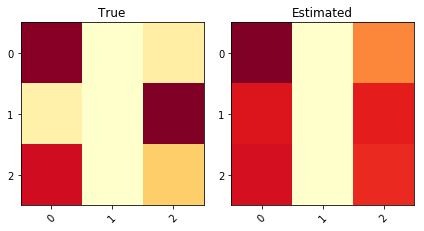

KL divergence: 0.2207	Pearson Correlation between diagonals: 0.8864


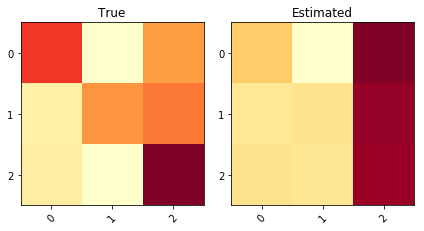

KL divergence: 0.2514	Pearson Correlation between diagonals: 0.9676


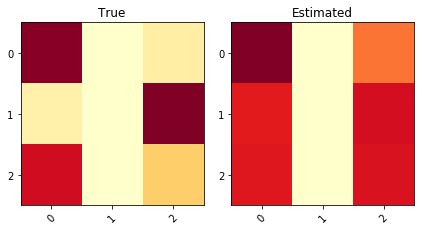

KL divergence: 0.2211	Pearson Correlation between diagonals: 0.8492


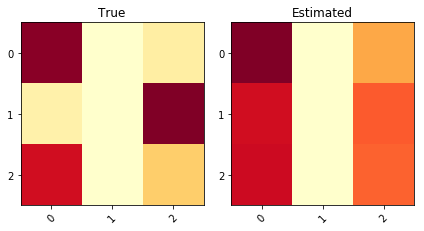

KL divergence: 0.2296	Pearson Correlation between diagonals: 0.9439


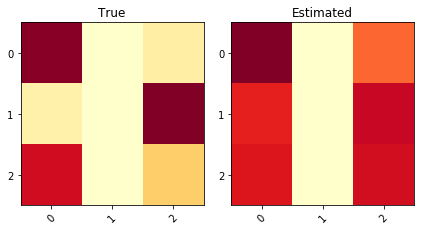

KL divergence: 0.2190	Pearson Correlation between diagonals: 0.8379


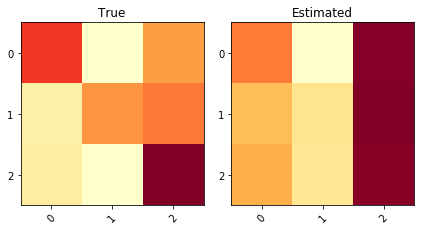

KL divergence: 0.2427	Pearson Correlation between diagonals: 0.9982


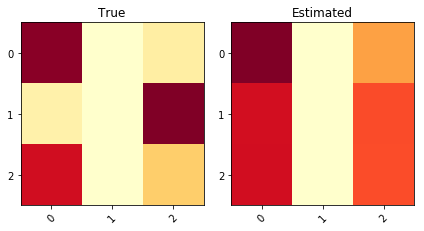

KL divergence: 0.2286	Pearson Correlation between diagonals: 0.9269


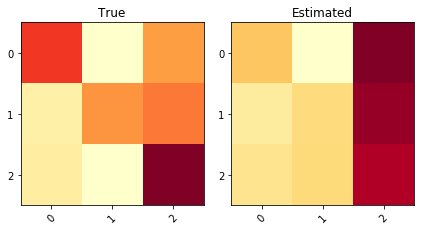

KL divergence: 0.2557	Pearson Correlation between diagonals: 0.9597


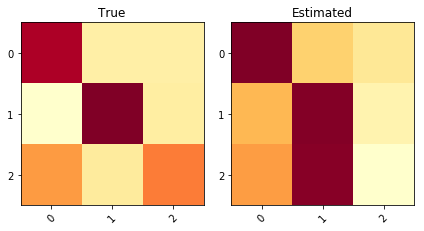

KL divergence: 0.3574	Pearson Correlation between diagonals: 0.9798


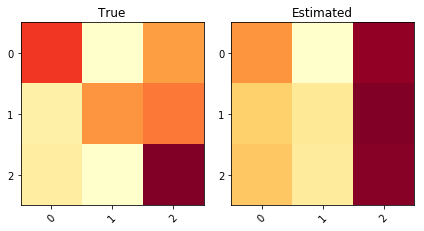

KL divergence: 0.2312	Pearson Correlation between diagonals: 1.0000


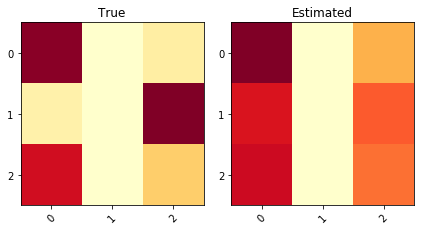

KL divergence: 0.2175	Pearson Correlation between diagonals: 0.9540
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.460317      0.460317   0.270593  0.0754019            0.938948
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.471306      0.471306
====  ======  ==========  ============


In [55]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


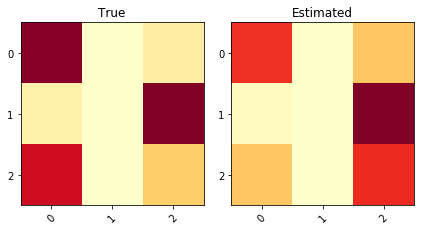

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


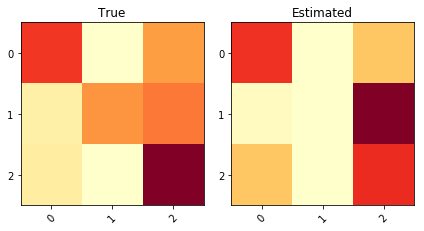

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.8074


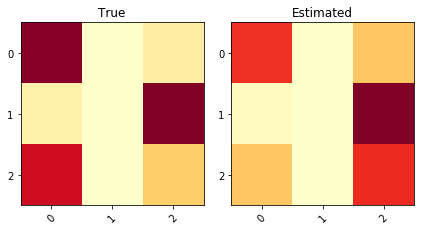

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


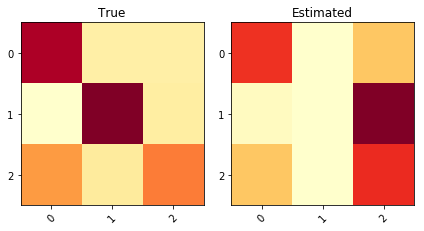

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


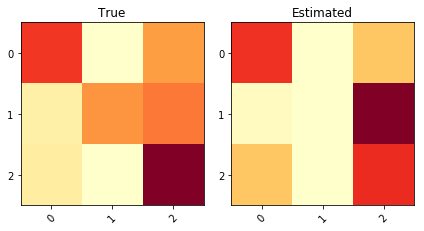

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.8074


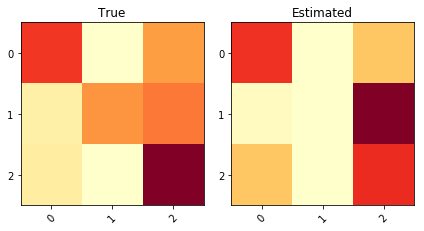

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.8074


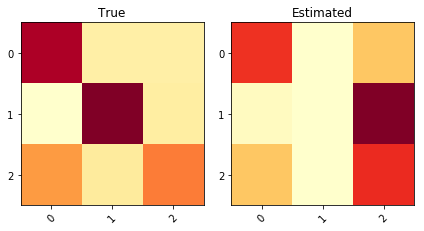

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


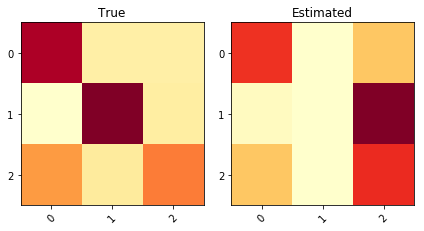

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


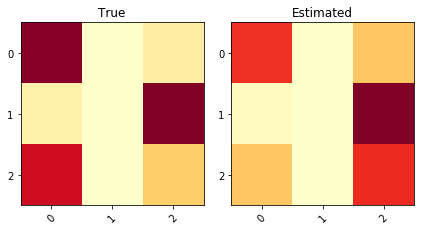

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


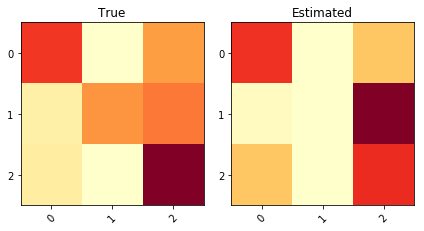

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.8074


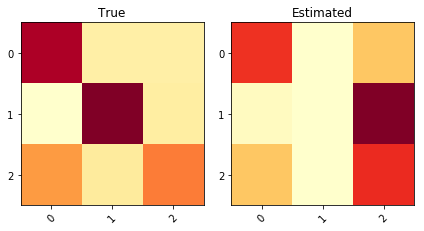

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


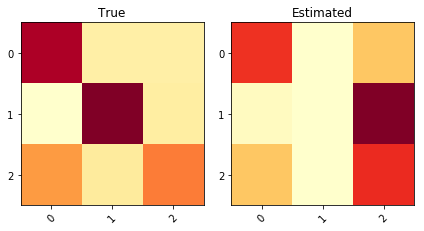

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


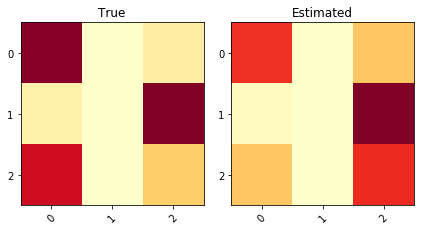

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


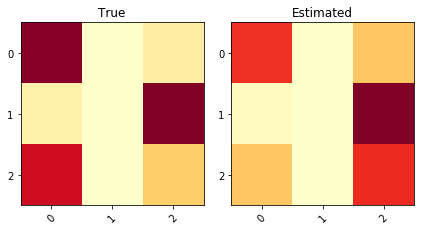

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


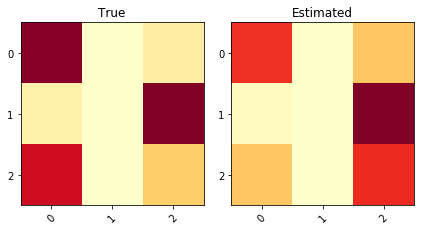

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.460317      0.460317    2.75888   0.153648            0.314396
====  ======  ==========  ============  =========  =========  ==================


In [56]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


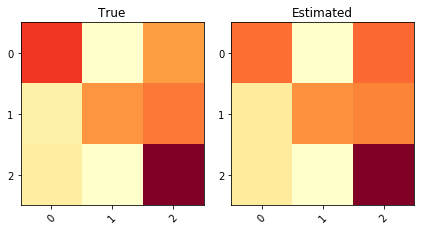

KL divergence: 0.0100	Pearson Correlation between diagonals: 0.9680


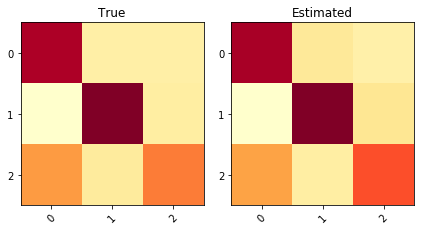

KL divergence: 0.0057	Pearson Correlation between diagonals: 0.9998


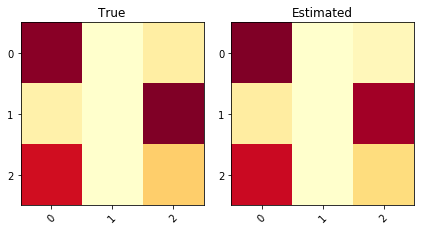

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9976


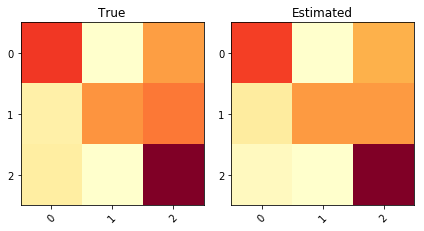

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9999


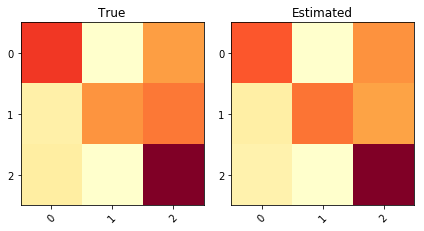

KL divergence: 0.0089	Pearson Correlation between diagonals: 0.9618


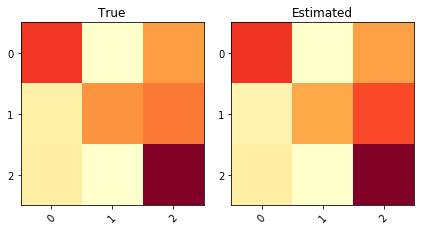

KL divergence: 0.0044	Pearson Correlation between diagonals: 0.9956


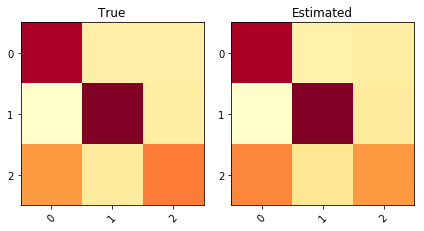

KL divergence: 0.0044	Pearson Correlation between diagonals: 0.9991


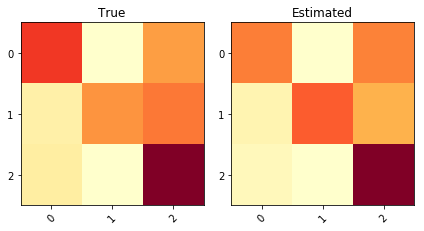

KL divergence: 0.0313	Pearson Correlation between diagonals: 0.8633


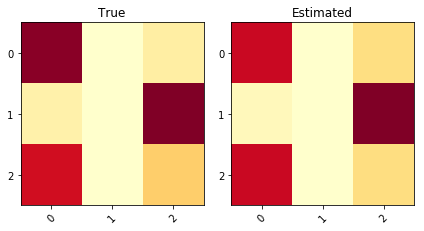

KL divergence: 0.0186	Pearson Correlation between diagonals: 0.9995


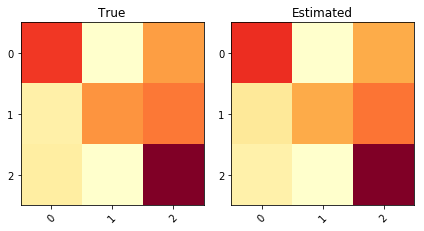

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9912


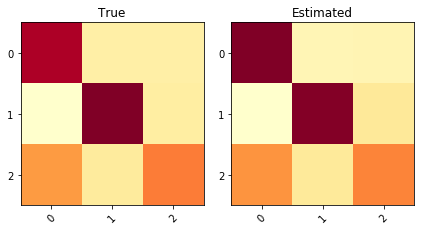

KL divergence: 0.0080	Pearson Correlation between diagonals: 0.9782


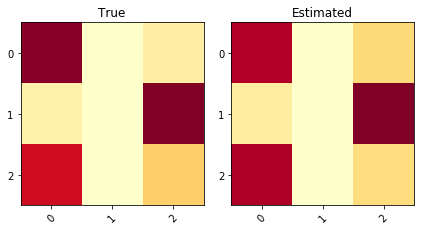

KL divergence: 0.0171	Pearson Correlation between diagonals: 0.9993


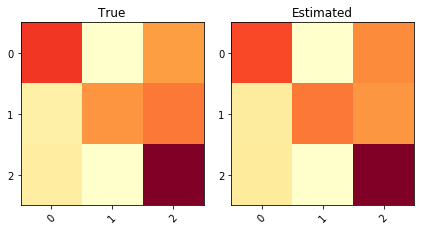

KL divergence: 0.0060	Pearson Correlation between diagonals: 0.9810


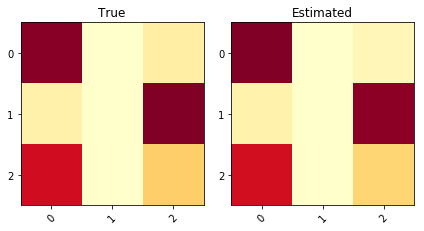

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9993


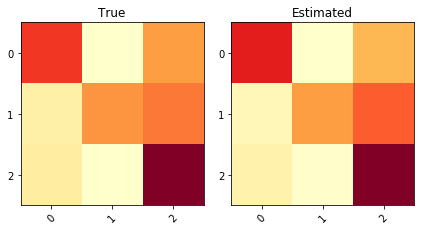

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9848
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.563696      0.563696  0.0132856  0.00254635             0.99066
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.556777      0.556777
====  ======  ==========  ============


In [57]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


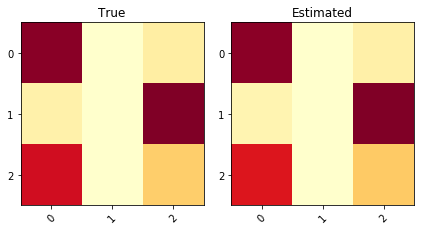

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9998


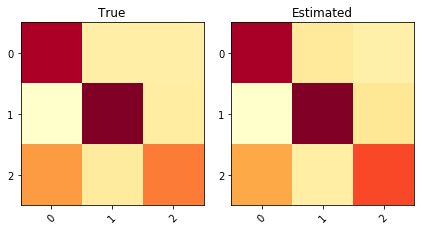

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9995


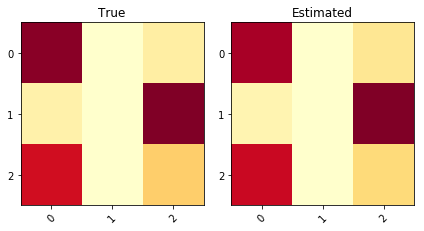

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9995


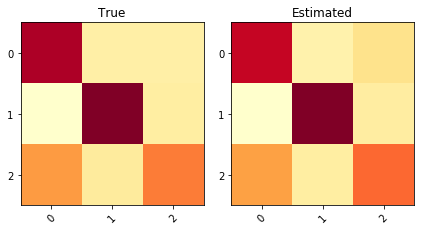

KL divergence: 0.0124	Pearson Correlation between diagonals: 0.9858


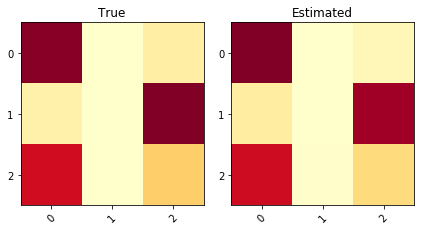

KL divergence: 0.0207	Pearson Correlation between diagonals: 0.9982


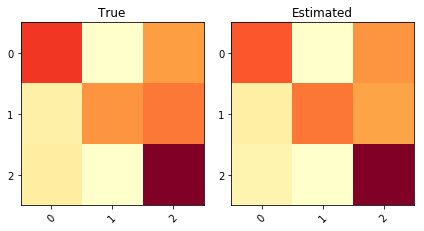

KL divergence: 0.0168	Pearson Correlation between diagonals: 0.9628


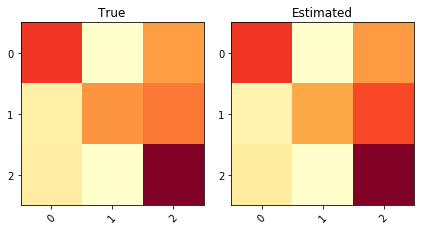

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9967


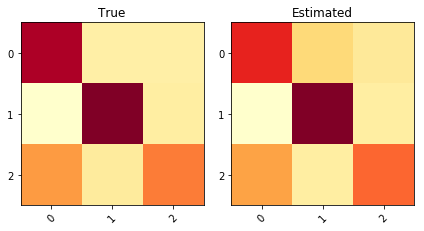

KL divergence: 0.0279	Pearson Correlation between diagonals: 0.8841


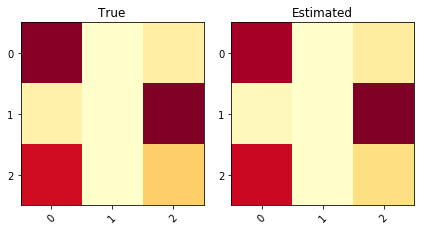

KL divergence: 0.0170	Pearson Correlation between diagonals: 0.9980


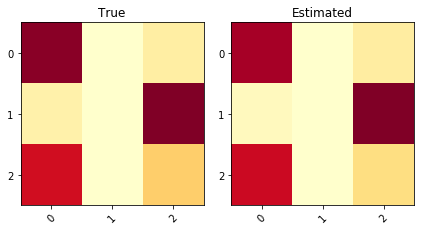

KL divergence: 0.0194	Pearson Correlation between diagonals: 0.9980


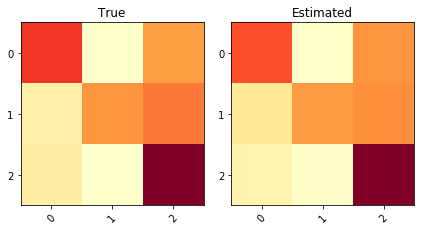

KL divergence: 0.0150	Pearson Correlation between diagonals: 0.9962


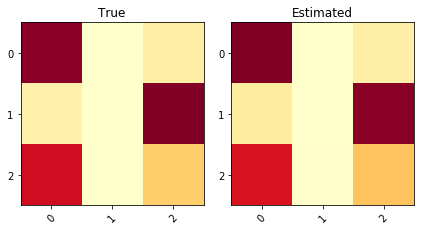

KL divergence: 0.0145	Pearson Correlation between diagonals: 0.9995


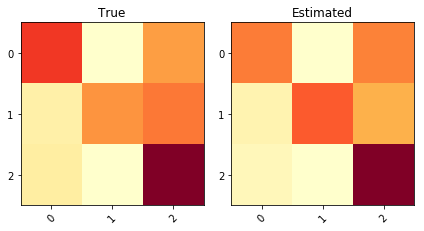

KL divergence: 0.0337	Pearson Correlation between diagonals: 0.8622


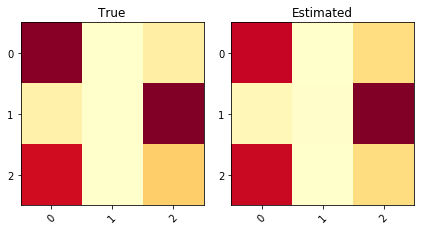

KL divergence: 0.0302	Pearson Correlation between diagonals: 0.9995


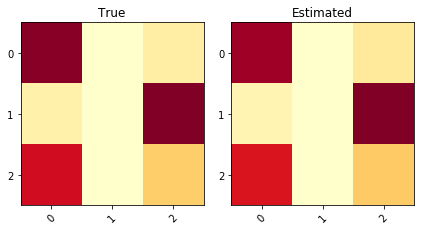

KL divergence: 0.0137	Pearson Correlation between diagonals: 0.9994
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.869353      0.869353  0.0171091  0.00504889            0.989911         0.17495
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.705212                0.712247
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.

In [58]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


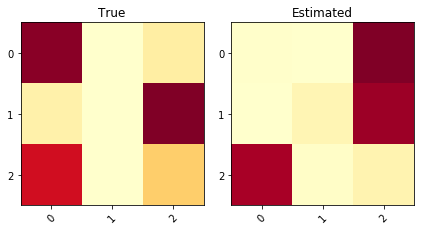

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


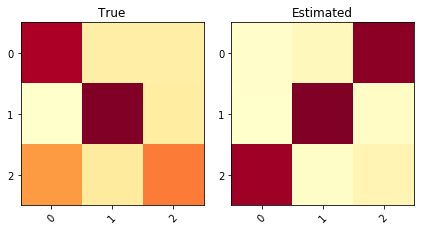

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


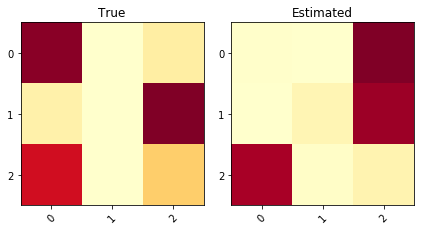

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


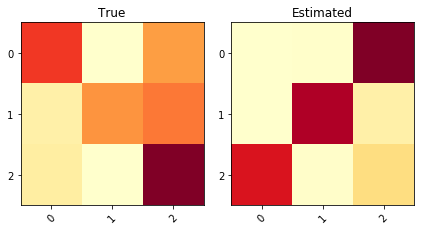

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


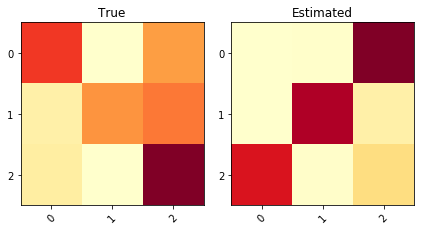

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


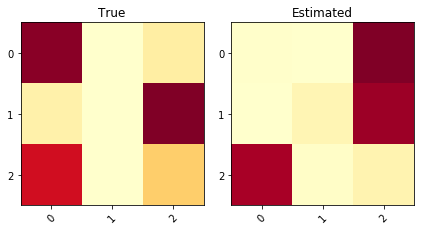

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


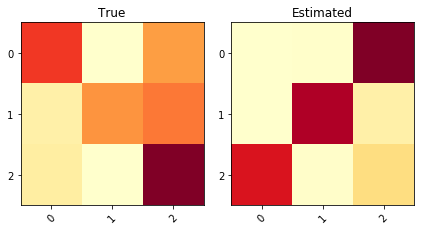

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


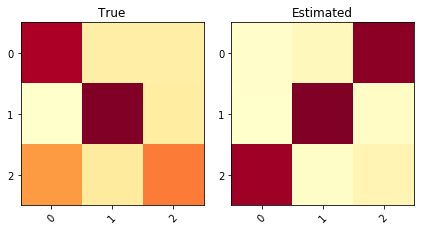

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


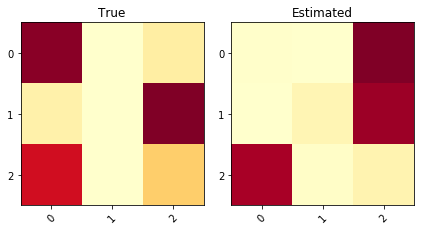

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


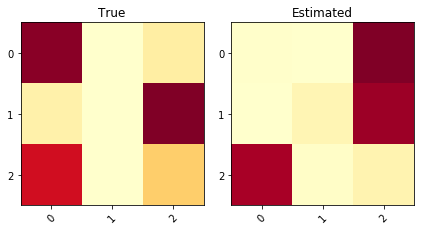

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


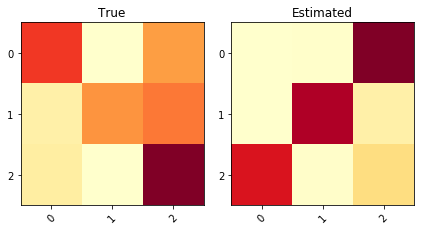

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


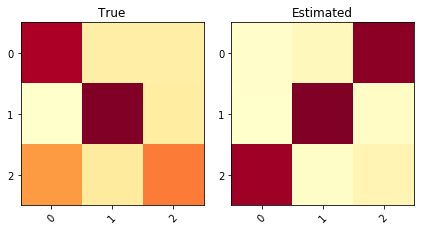

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


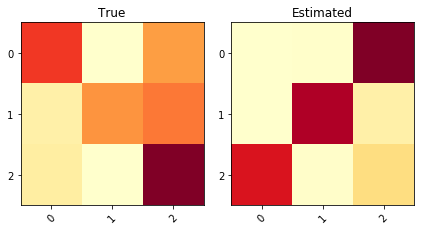

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


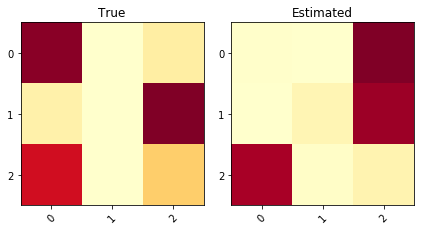

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


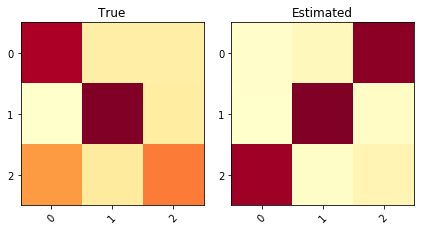

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.597884      0.597884     1.5097   0.208986           -0.348053        0.148848
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.680813                0.703747
====  =======================  ======================
Test


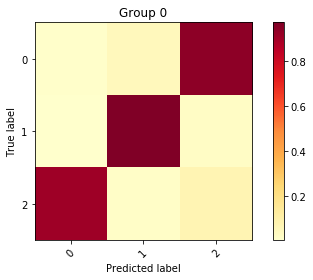

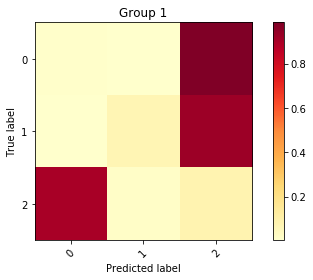

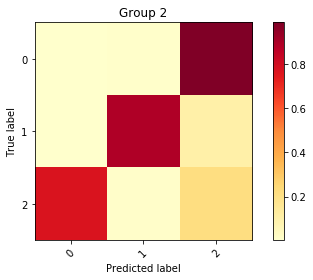

Inertia: 0.10848995065316558
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.326825      32   0.232576    0.351229     2.55813       0.402764   0.0178953    0.711844      0.711844
   1         1  0.286561      28   0.236939    0.0529269    3.31976       0.14267   -0.280406     0.565324      0.565324
   2         2  0.386613      38   0.336965    0.371128     2.42394       0.457802   0.0377947    0.896215      0.896215
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [59]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


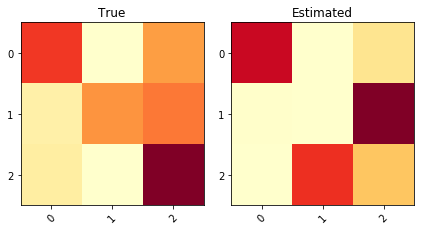

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


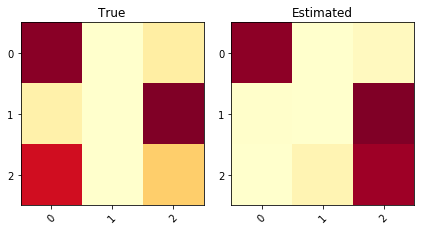

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


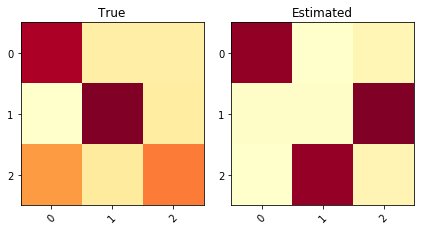

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


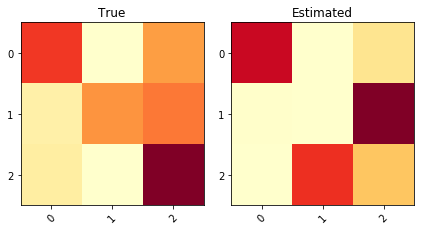

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


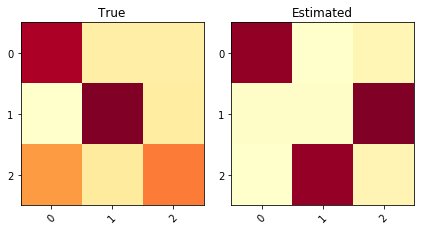

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


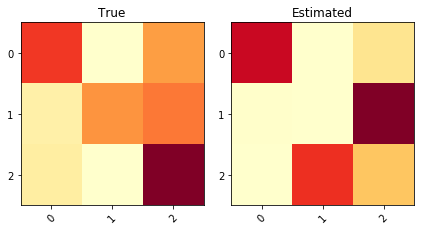

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


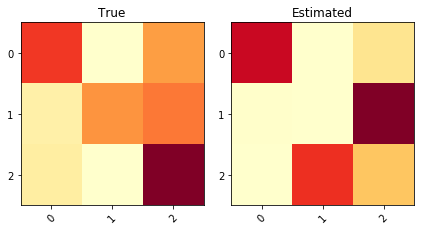

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


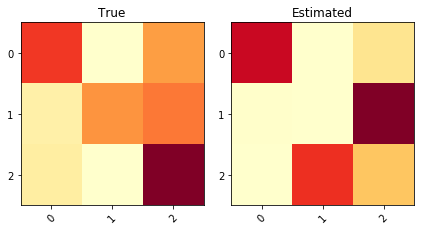

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


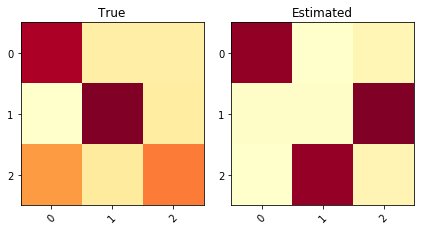

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


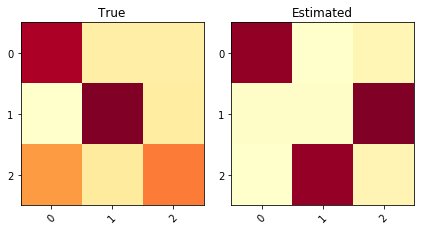

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


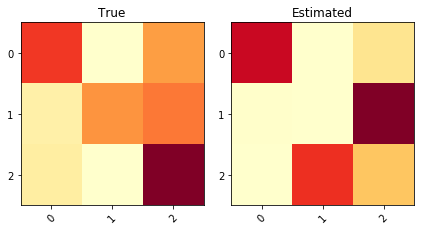

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


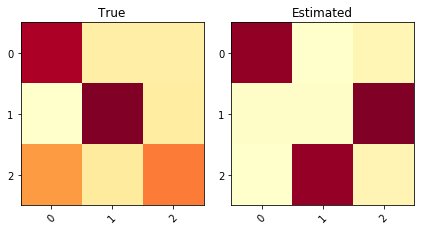

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


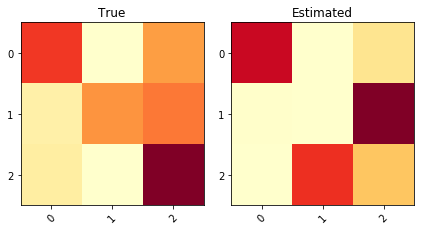

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


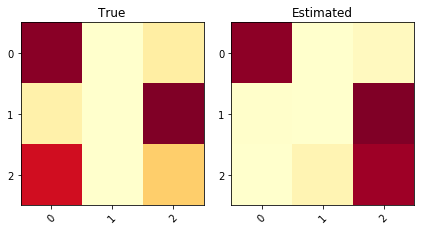

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


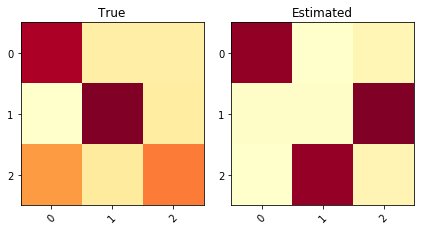

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.350834      0.350834     1.4957   0.205557            0.428808        0.150335
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.677046                0.699032
====  =======================  ======================
Test


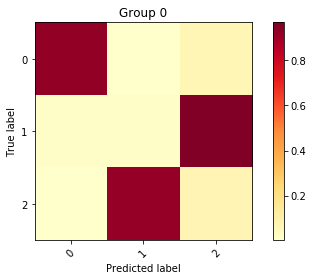

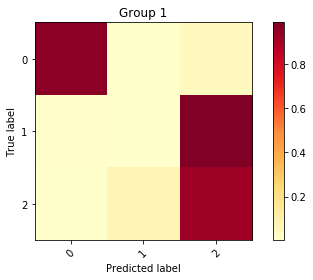

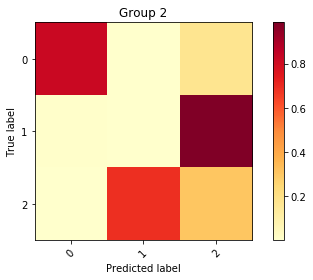

Inertia: 0.08358287128309409
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.300226      30   0.236477     0.338454    2.29225       0.403617  0.0051209    0.808303      0.808303
   1         1  0.337198      33   0.176395     0.628844    1.98815       0.651583  0.29551      0.579976      0.579976
   2         2  0.362576      36   0.398023     0.378613    2.25763       0.48055   0.0452801    0.796093      0.796093
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [60]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


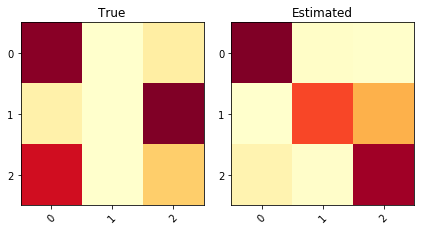

KL divergence: 0.8342	Pearson Correlation between diagonals: 0.8355


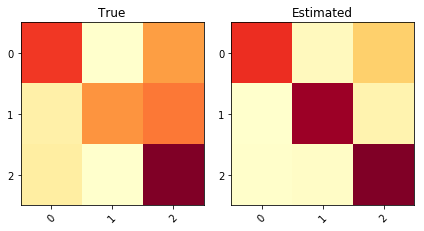

KL divergence: 0.3389	Pearson Correlation between diagonals: 0.3106


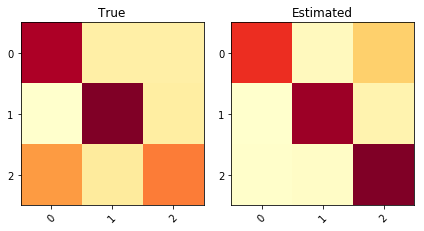

KL divergence: 0.4803	Pearson Correlation between diagonals: -0.4953


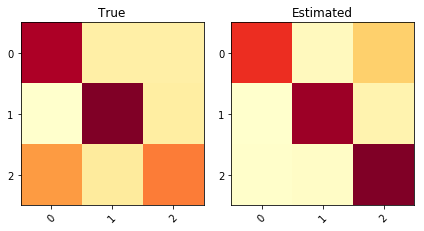

KL divergence: 0.4803	Pearson Correlation between diagonals: -0.4953


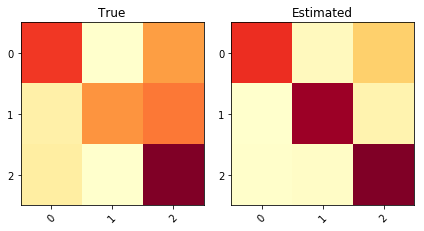

KL divergence: 0.3388	Pearson Correlation between diagonals: 0.3108


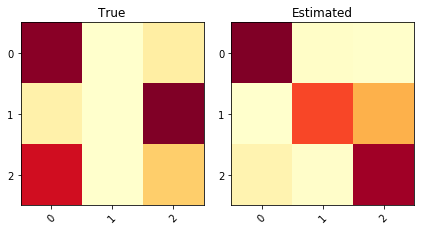

KL divergence: 0.8342	Pearson Correlation between diagonals: 0.8350


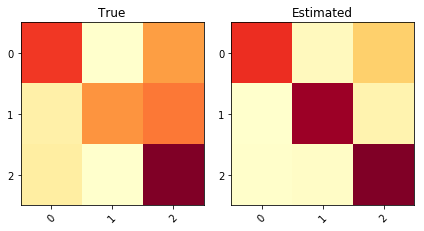

KL divergence: 0.3390	Pearson Correlation between diagonals: 0.3104


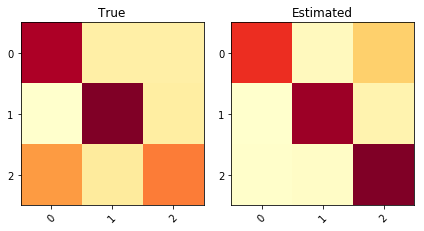

KL divergence: 0.4803	Pearson Correlation between diagonals: -0.4953


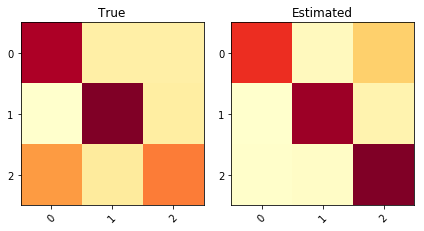

KL divergence: 0.4803	Pearson Correlation between diagonals: -0.4954


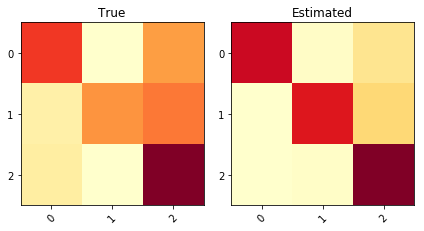

KL divergence: 0.2610	Pearson Correlation between diagonals: 0.9873


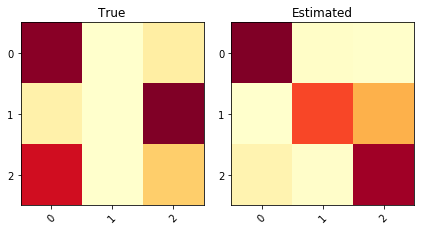

KL divergence: 0.8342	Pearson Correlation between diagonals: 0.8359


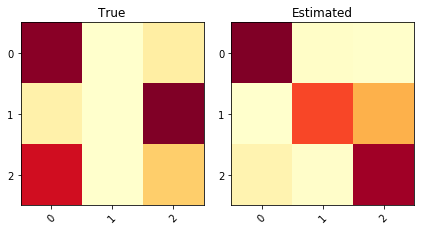

KL divergence: 0.8342	Pearson Correlation between diagonals: 0.8354


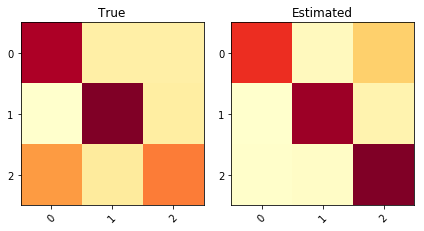

KL divergence: 0.4803	Pearson Correlation between diagonals: -0.4953


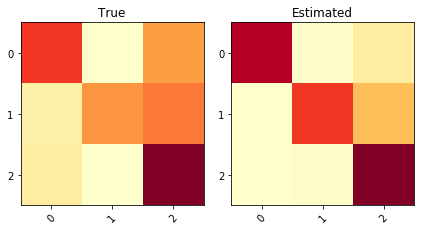

KL divergence: 0.3085	Pearson Correlation between diagonals: 0.9552


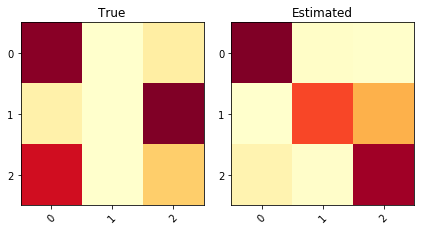

KL divergence: 0.8342	Pearson Correlation between diagonals: 0.8358
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.726496      0.726496   0.547507   0.109126            0.315749        0.179186
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.699217                0.767501
====  =======================  ======================
Test


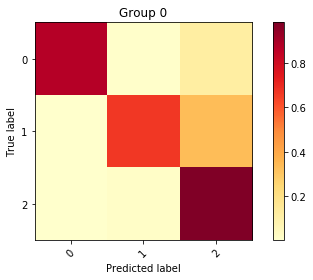

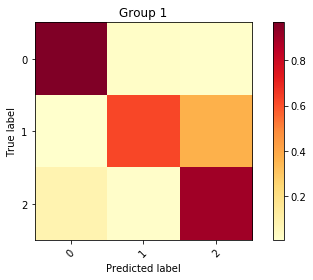

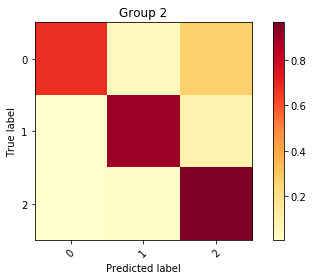

Inertia: 0.03343068932493528
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.74701       74   0.3801       0.841897   0.184978       0.91188    0.508564    0.610501      0.610501
   1         1  0.125081      12   0.408153     0.830798   0.203037       0.904143   0.497465    0.433455      0.433455
   2         2  0.127908      12   0.418596     0.851449   0.172204       0.917728   0.518115    0.885226      0.885226
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [61]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


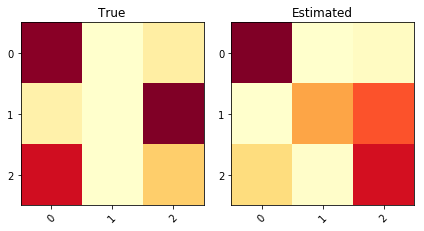

KL divergence: 0.4558	Pearson Correlation between diagonals: 0.9154


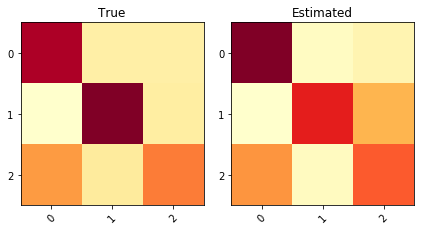

KL divergence: 0.0740	Pearson Correlation between diagonals: 0.6298


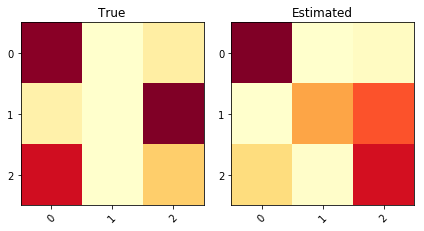

KL divergence: 0.4558	Pearson Correlation between diagonals: 0.9154


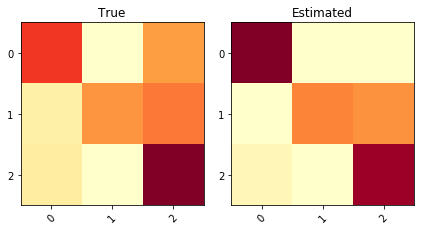

KL divergence: 0.6484	Pearson Correlation between diagonals: 0.7215


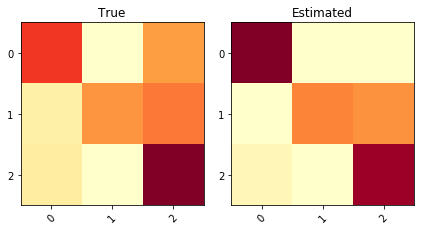

KL divergence: 0.6482	Pearson Correlation between diagonals: 0.7214


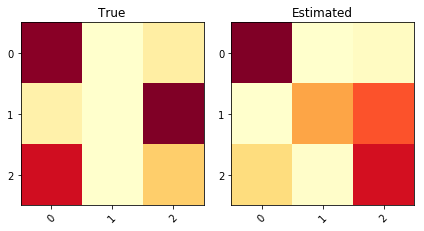

KL divergence: 0.4558	Pearson Correlation between diagonals: 0.9154


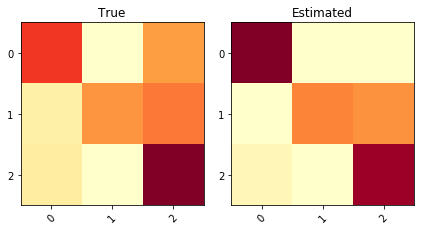

KL divergence: 0.6486	Pearson Correlation between diagonals: 0.7215


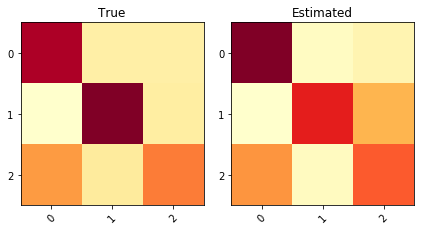

KL divergence: 0.0740	Pearson Correlation between diagonals: 0.6298


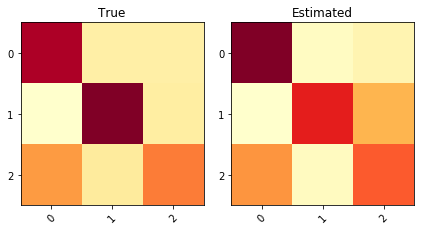

KL divergence: 0.0740	Pearson Correlation between diagonals: 0.6298


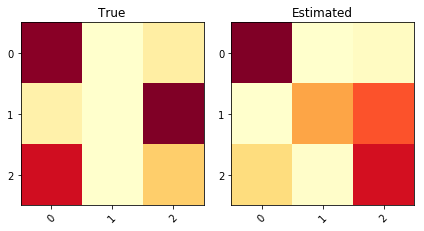

KL divergence: 0.4558	Pearson Correlation between diagonals: 0.9154


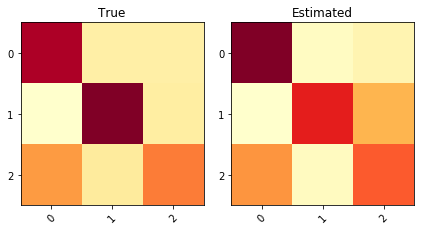

KL divergence: 0.0740	Pearson Correlation between diagonals: 0.6298


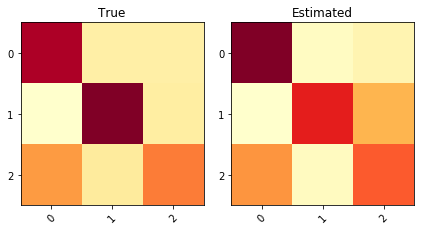

KL divergence: 0.0740	Pearson Correlation between diagonals: 0.6298


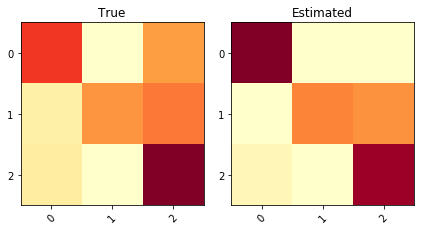

KL divergence: 0.6487	Pearson Correlation between diagonals: 0.7215


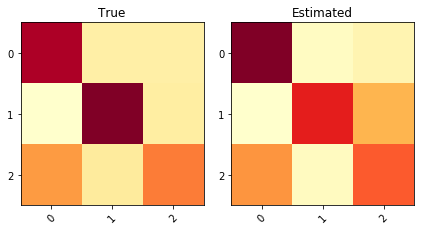

KL divergence: 0.0740	Pearson Correlation between diagonals: 0.6298


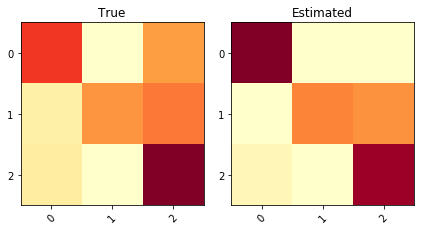

KL divergence: 0.6487	Pearson Correlation between diagonals: 0.7215
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.845747      0.845747   0.410083  0.0709754            0.773283        0.205304
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.686055                0.751605
====  =======================  ======================
Test


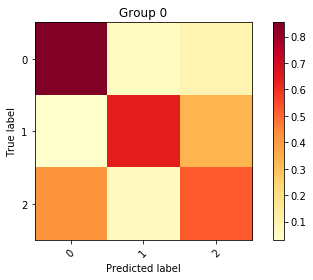

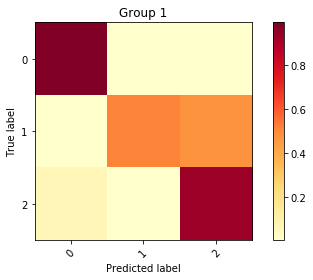

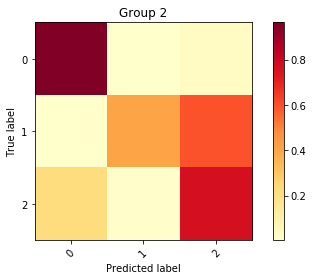

Inertia: 0.035358583088964224
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.0349311       3   0.713318     0.671908   0.417997       0.806678   0.338575    0.654457      0.654457
   1         1  0.595474       59   0.333034     0.814885   0.245142       0.888252   0.481552    0.570208      0.570208
   2         2  0.369595       36   0.482061     0.71201    0.403223       0.820619   0.378677    0.485958      0.485958
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ========== 

In [22]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [77]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7806267806267806


*** Soft-Majority (Train with softMV) ***
Train


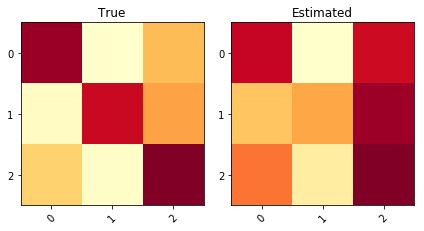

KL divergence: 0.2169	Pearson Correlation between diagonals: 0.9963


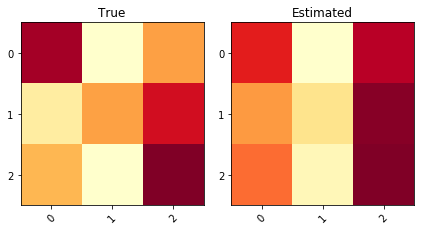

KL divergence: 0.1727	Pearson Correlation between diagonals: 0.9825


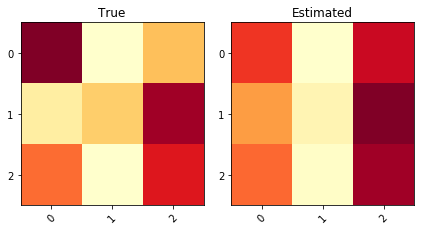

KL divergence: 0.1565	Pearson Correlation between diagonals: 0.8226


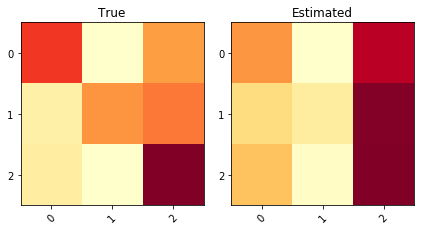

KL divergence: 0.2177	Pearson Correlation between diagonals: 1.0000


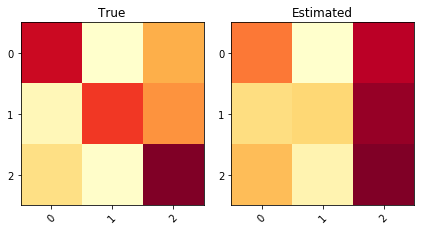

KL divergence: 0.2077	Pearson Correlation between diagonals: 0.9957


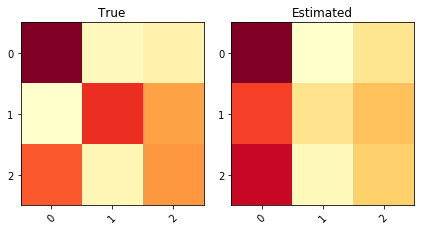

KL divergence: 0.2400	Pearson Correlation between diagonals: 0.8442


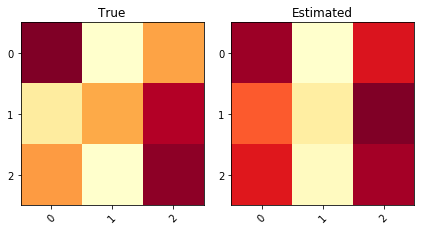

KL divergence: 0.1730	Pearson Correlation between diagonals: 0.9997


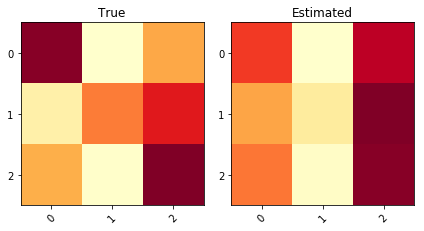

KL divergence: 0.1757	Pearson Correlation between diagonals: 0.9462


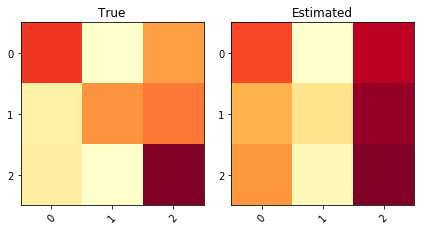

KL divergence: 0.2220	Pearson Correlation between diagonals: 0.9810


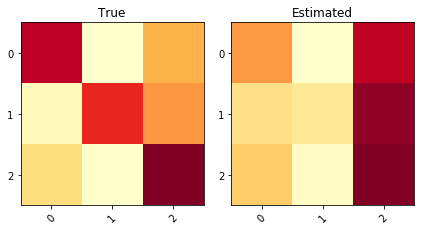

KL divergence: 0.2332	Pearson Correlation between diagonals: 0.9857


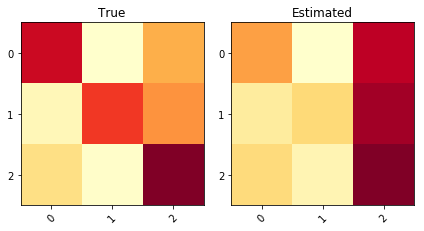

KL divergence: 0.2075	Pearson Correlation between diagonals: 0.9716


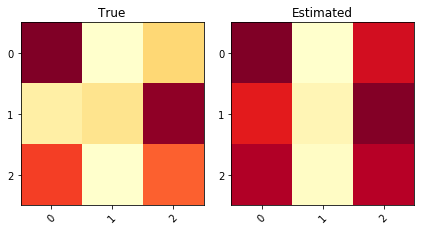

KL divergence: 0.1659	Pearson Correlation between diagonals: 0.9169


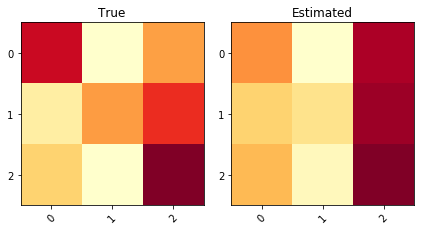

KL divergence: 0.1805	Pearson Correlation between diagonals: 0.9334


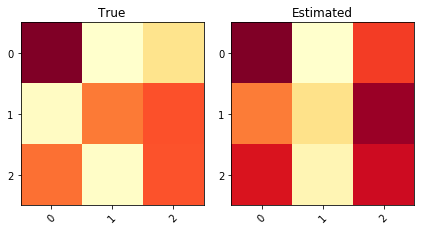

KL divergence: 0.1860	Pearson Correlation between diagonals: 0.7803


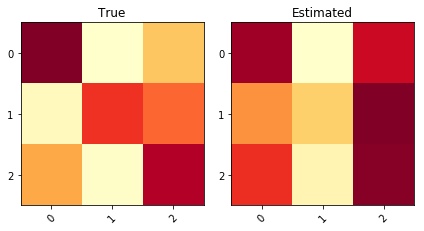

KL divergence: 0.1897	Pearson Correlation between diagonals: 0.9182
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907   0.208223  0.0572833            0.896771
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.802198      0.802198
====  ======  ==========  ============


In [78]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


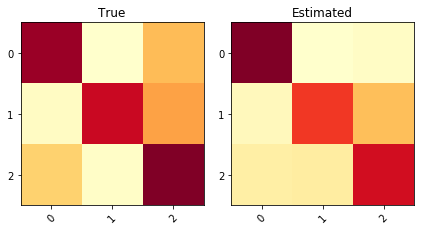

KL divergence: 0.4096	Pearson Correlation between diagonals: 0.5530


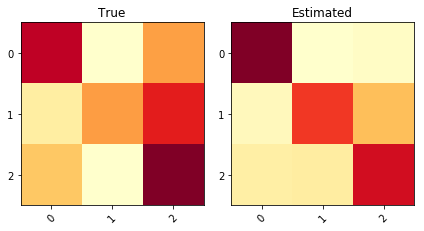

KL divergence: 0.2688	Pearson Correlation between diagonals: 0.6402


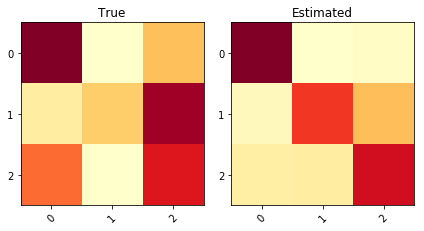

KL divergence: 0.2847	Pearson Correlation between diagonals: 0.9487


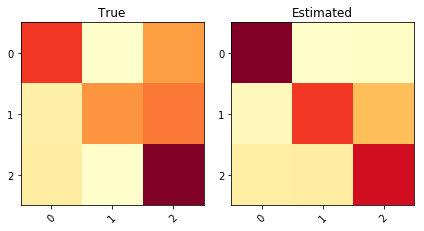

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


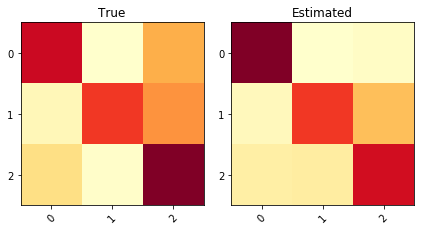

KL divergence: 0.3539	Pearson Correlation between diagonals: 0.3576


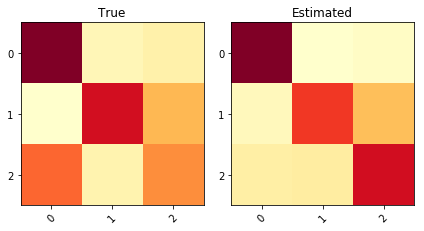

KL divergence: 0.6089	Pearson Correlation between diagonals: 0.4951


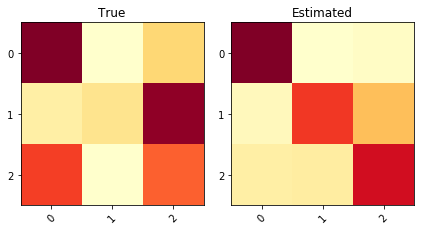

KL divergence: 0.3354	Pearson Correlation between diagonals: 0.9926


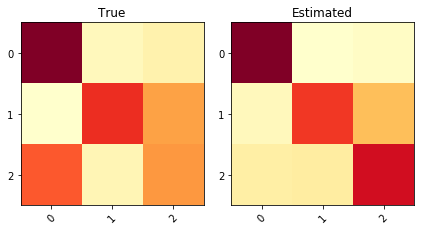

KL divergence: 0.5577	Pearson Correlation between diagonals: 0.6504


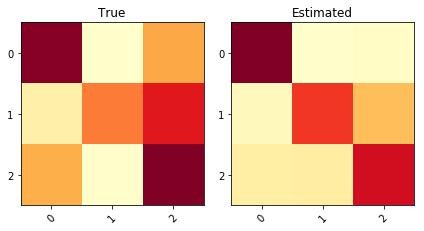

KL divergence: 0.2787	Pearson Correlation between diagonals: 0.7775


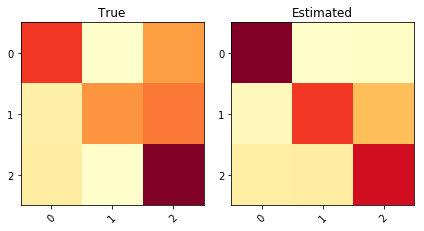

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


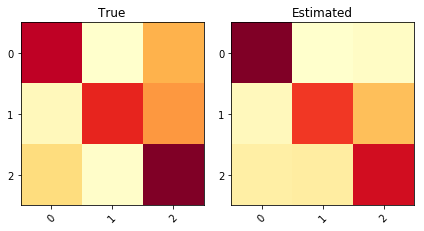

KL divergence: 0.3702	Pearson Correlation between diagonals: 0.3962


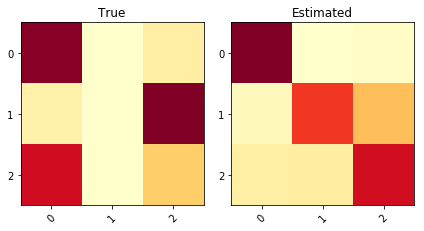

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9930


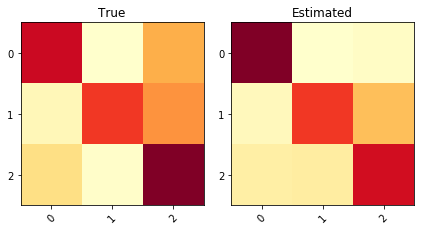

KL divergence: 0.3539	Pearson Correlation between diagonals: 0.3576


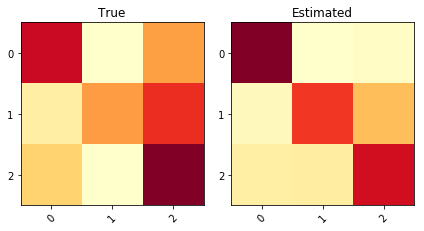

KL divergence: 0.2731	Pearson Correlation between diagonals: 0.5831


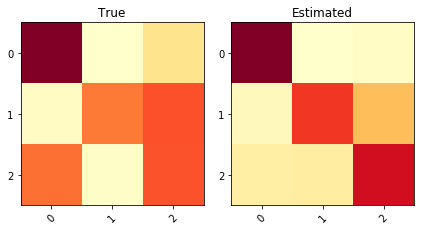

KL divergence: 0.3820	Pearson Correlation between diagonals: 0.9692
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907    0.37778  0.0971699            0.617551
====  ======  ==========  ============  =========  =========  ==================


In [79]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


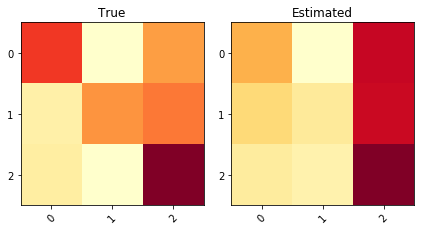

KL divergence: 0.2078	Pearson Correlation between diagonals: 0.9916


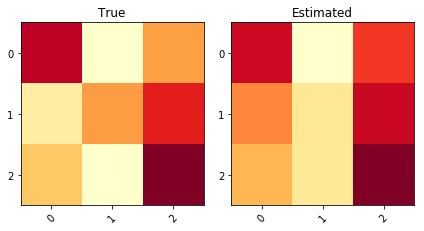

KL divergence: 0.1659	Pearson Correlation between diagonals: 0.9993


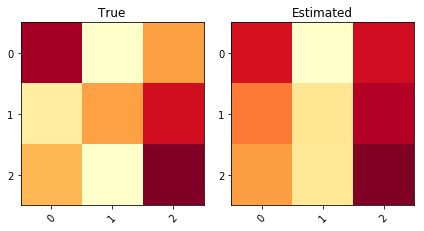

KL divergence: 0.1786	Pearson Correlation between diagonals: 0.9923


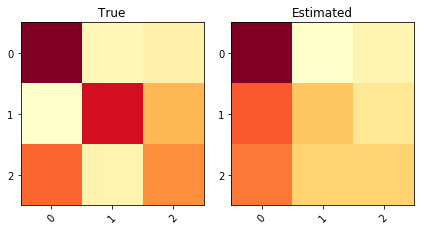

KL divergence: 0.2548	Pearson Correlation between diagonals: 0.8283


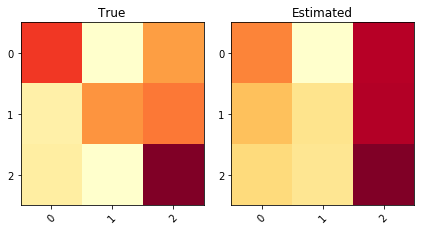

KL divergence: 0.2166	Pearson Correlation between diagonals: 0.9997


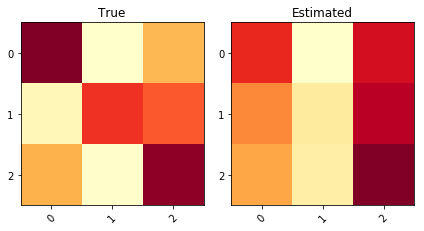

KL divergence: 0.2113	Pearson Correlation between diagonals: 0.9114


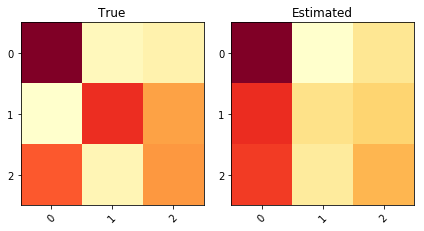

KL divergence: 0.2495	Pearson Correlation between diagonals: 0.7919


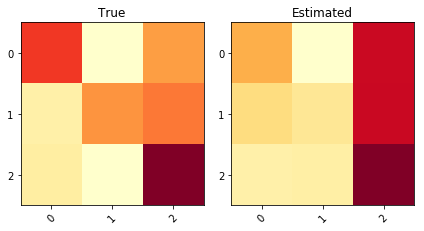

KL divergence: 0.2025	Pearson Correlation between diagonals: 0.9908


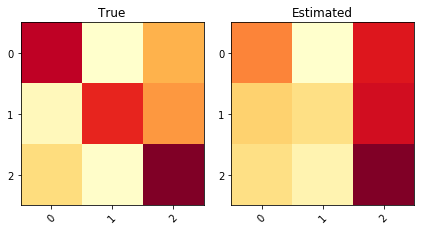

KL divergence: 0.2089	Pearson Correlation between diagonals: 0.9917


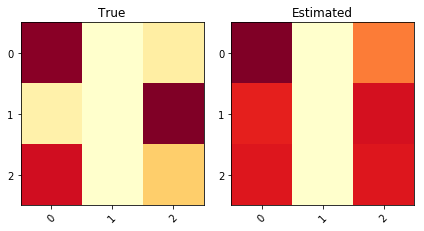

KL divergence: 0.2160	Pearson Correlation between diagonals: 0.8586


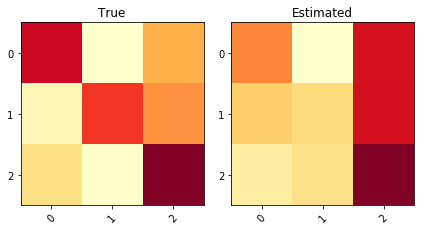

KL divergence: 0.2065	Pearson Correlation between diagonals: 0.9936


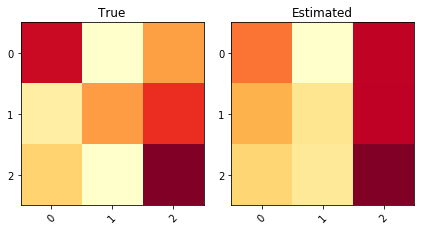

KL divergence: 0.1864	Pearson Correlation between diagonals: 0.9637


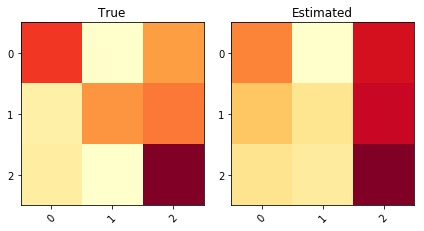

KL divergence: 0.2014	Pearson Correlation between diagonals: 0.9993


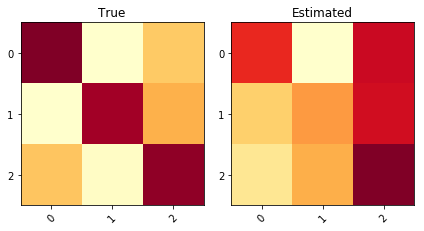

KL divergence: 0.2408	Pearson Correlation between diagonals: 0.5087


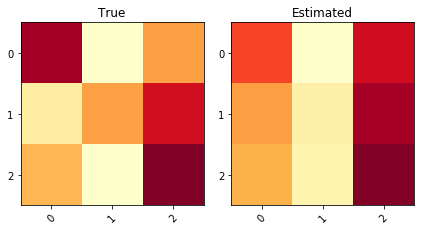

KL divergence: 0.1714	Pearson Correlation between diagonals: 0.9624
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.717135      0.717135   0.207053  0.0576954            0.893502
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.726496      0.726496
====  ======  ==========  ============


In [80]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


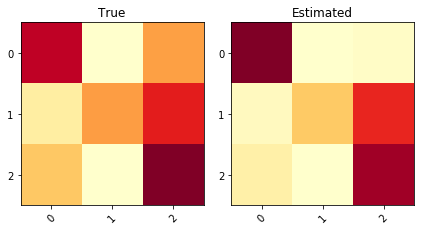

KL divergence: 0.2688	Pearson Correlation between diagonals: 0.9490


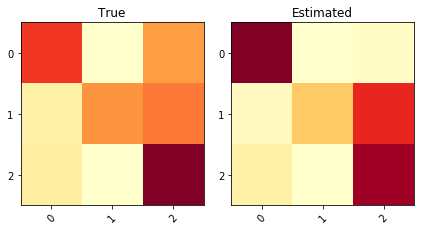

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7388


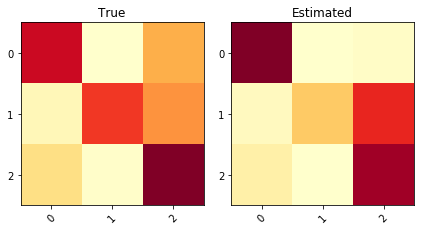

KL divergence: 0.3539	Pearson Correlation between diagonals: 0.7963


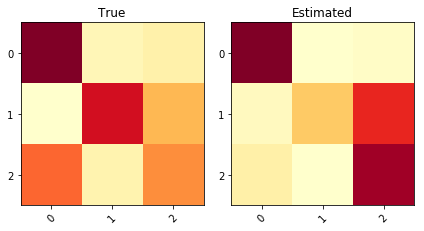

KL divergence: 0.6089	Pearson Correlation between diagonals: -0.0375


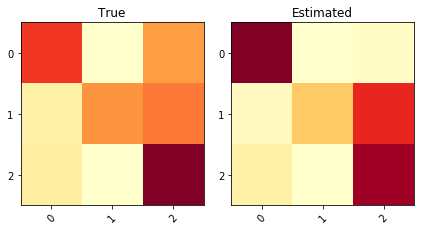

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7388


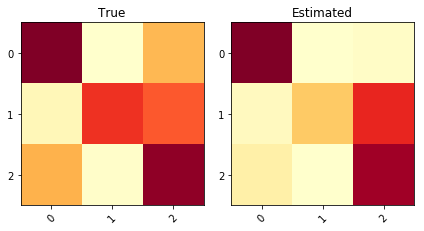

KL divergence: 0.3381	Pearson Correlation between diagonals: 1.0000


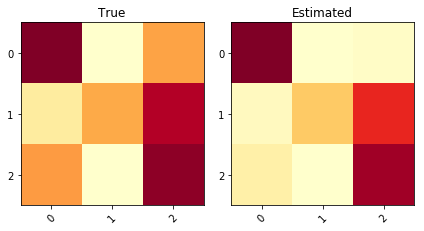

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9990


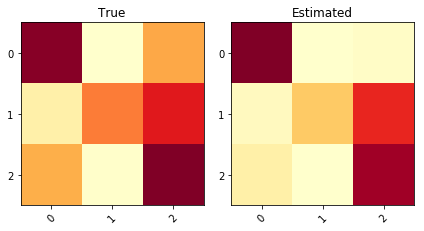

KL divergence: 0.2787	Pearson Correlation between diagonals: 0.9922


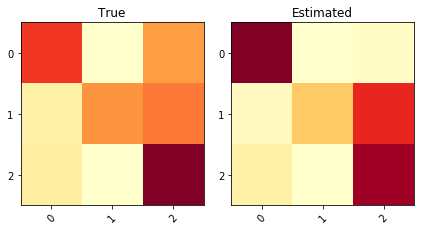

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7388


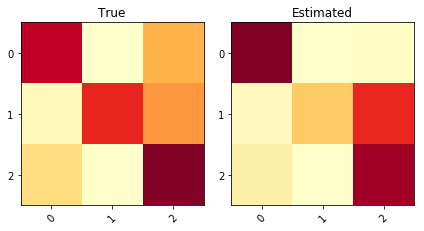

KL divergence: 0.3702	Pearson Correlation between diagonals: 0.8208


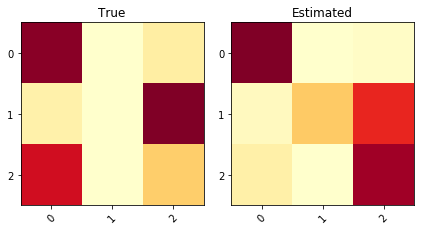

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.7814


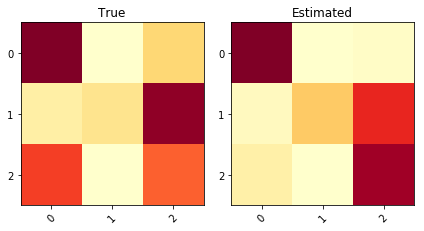

KL divergence: 0.3354	Pearson Correlation between diagonals: 0.9073


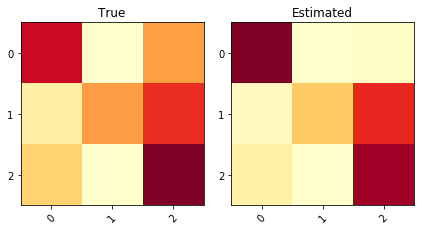

KL divergence: 0.2731	Pearson Correlation between diagonals: 0.9238


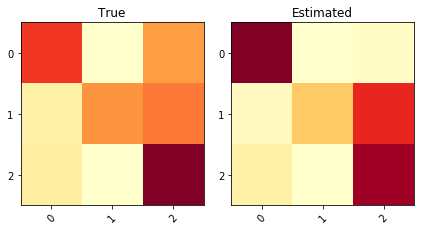

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7388


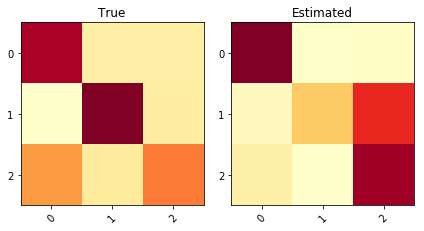

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.5881
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.717135      0.717135    0.37778  0.0971699            0.719782
====  ======  ==========  ============  =========  =========  ==================


In [81]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


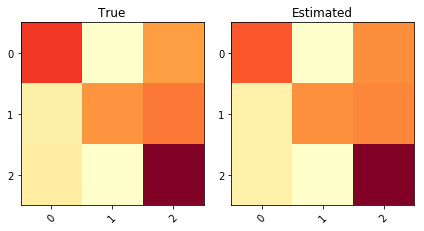

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9838


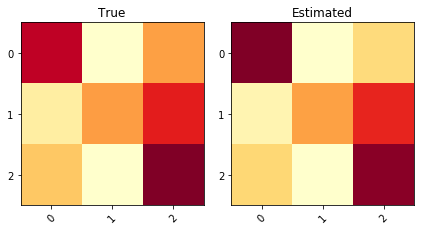

KL divergence: 0.0233	Pearson Correlation between diagonals: 0.9652


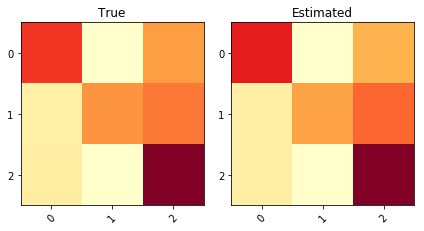

KL divergence: 0.0037	Pearson Correlation between diagonals: 0.9836


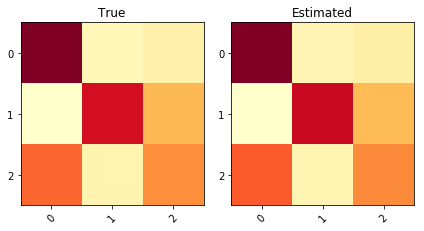

KL divergence: 0.0833	Pearson Correlation between diagonals: 0.9979


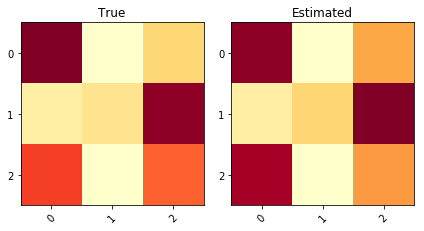

KL divergence: 0.0242	Pearson Correlation between diagonals: 0.9688


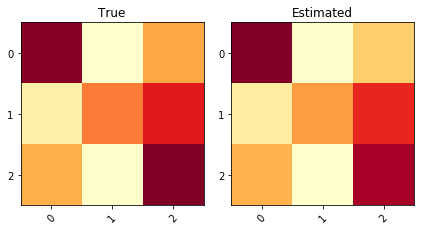

KL divergence: 0.0076	Pearson Correlation between diagonals: 0.9857


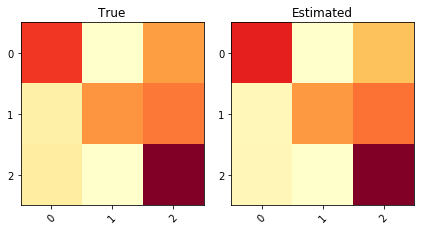

KL divergence: 0.0168	Pearson Correlation between diagonals: 0.9897


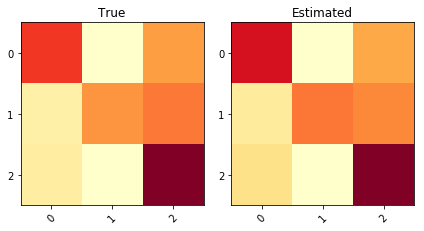

KL divergence: 0.0093	Pearson Correlation between diagonals: 0.9846


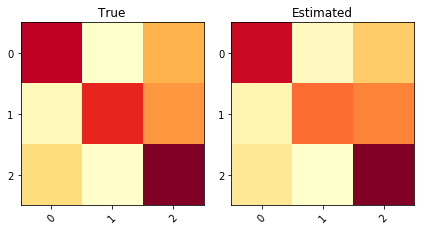

KL divergence: 0.0134	Pearson Correlation between diagonals: 0.9921


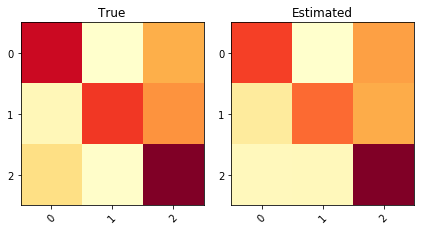

KL divergence: 0.0484	Pearson Correlation between diagonals: 0.9598


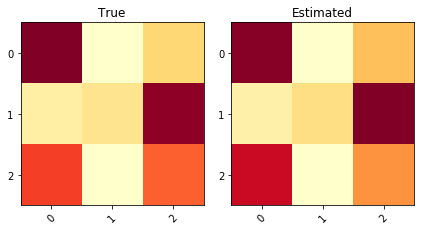

KL divergence: 0.0106	Pearson Correlation between diagonals: 0.9851


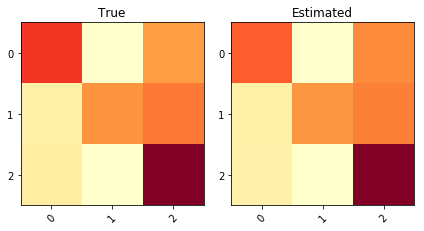

KL divergence: 0.0034	Pearson Correlation between diagonals: 0.9867


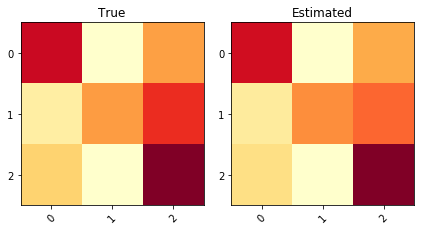

KL divergence: 0.0060	Pearson Correlation between diagonals: 0.9970


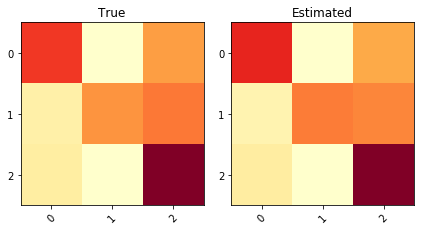

KL divergence: 0.0033	Pearson Correlation between diagonals: 0.9997


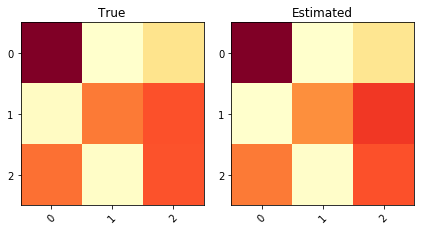

KL divergence: 0.0022	Pearson Correlation between diagonals: 0.9960
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.885226      0.885226  0.0184842  0.00325279            0.943187
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.881563      0.881563
====  ======  ==========  ============


In [82]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


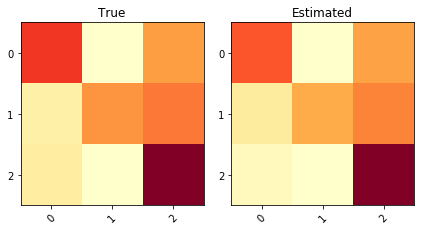

KL divergence: 0.0199	Pearson Correlation between diagonals: 0.9996


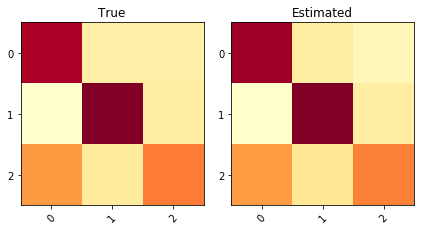

KL divergence: 0.0083	Pearson Correlation between diagonals: 0.9972


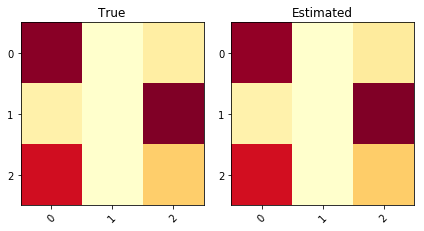

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9999


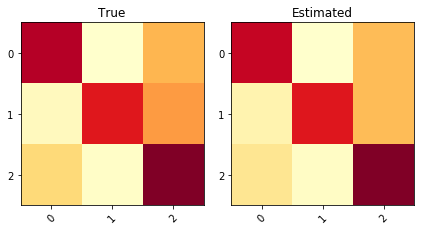

KL divergence: 0.0075	Pearson Correlation between diagonals: 0.9769


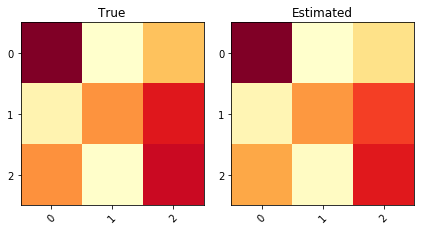

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9907


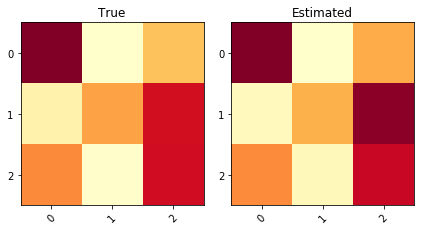

KL divergence: 0.0146	Pearson Correlation between diagonals: 0.9971


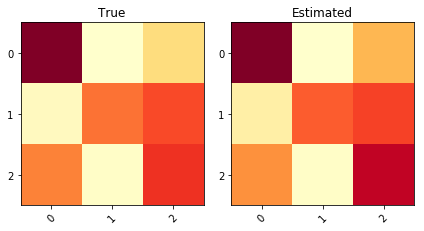

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9281


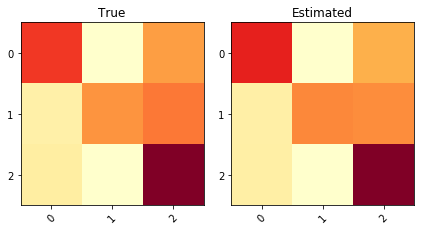

KL divergence: 0.0112	Pearson Correlation between diagonals: 0.9973


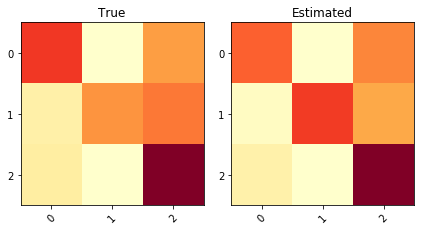

KL divergence: 0.0379	Pearson Correlation between diagonals: 0.8348


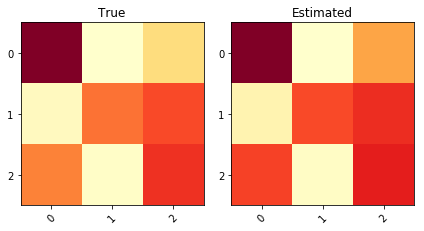

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9998


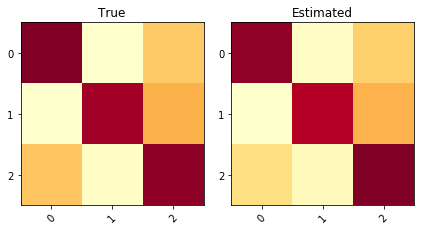

KL divergence: 0.0055	Pearson Correlation between diagonals: 0.6911


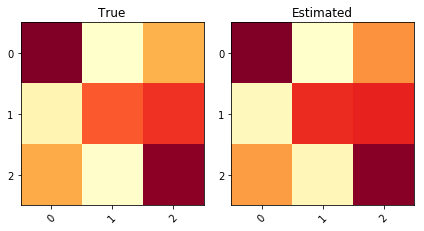

KL divergence: 0.0098	Pearson Correlation between diagonals: 1.0000


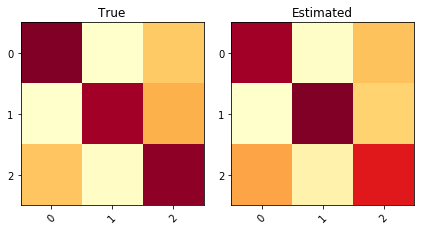

KL divergence: 0.0159	Pearson Correlation between diagonals: -0.3234


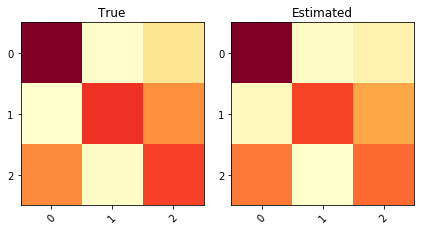

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9972


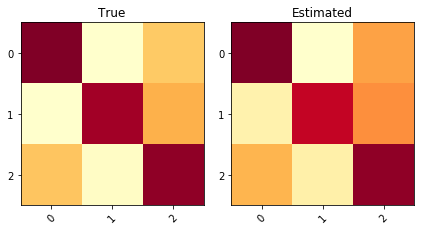

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9607
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.858364      0.858364  0.0156616  0.00416836            0.883169       0.0800129
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.618361                0.850753
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.85

In [12]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


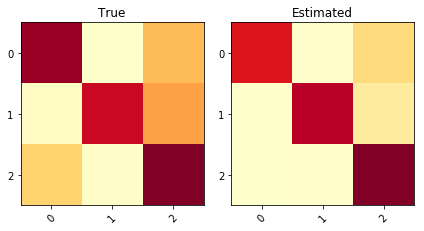

KL divergence: 0.3232	Pearson Correlation between diagonals: 0.3613


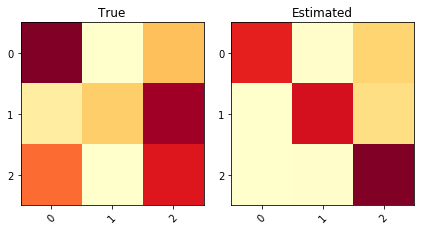

KL divergence: 0.8276	Pearson Correlation between diagonals: -0.0154


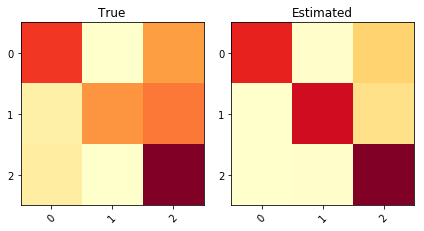

KL divergence: 0.2438	Pearson Correlation between diagonals: 0.7721


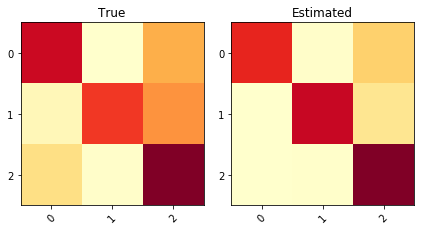

KL divergence: 0.2599	Pearson Correlation between diagonals: 0.6147


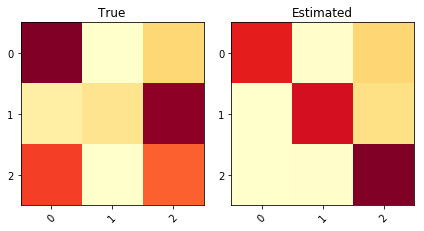

KL divergence: 1.0898	Pearson Correlation between diagonals: -0.2214


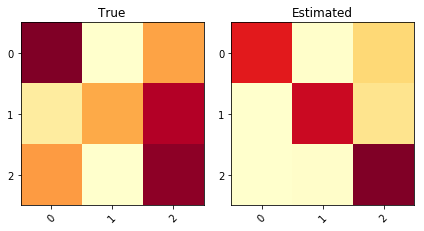

KL divergence: 0.6288	Pearson Correlation between diagonals: 0.1700


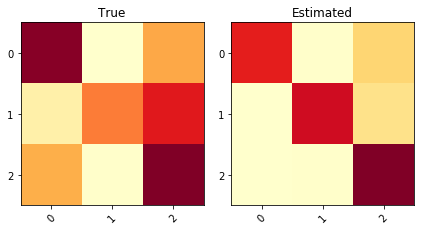

KL divergence: 0.4777	Pearson Correlation between diagonals: 0.2675


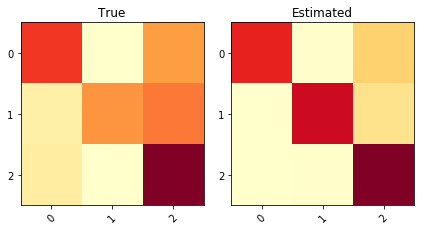

KL divergence: 0.2488	Pearson Correlation between diagonals: 0.7393


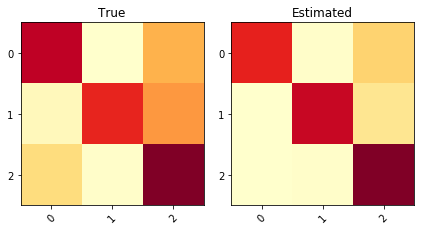

KL divergence: 0.2724	Pearson Correlation between diagonals: 0.6012


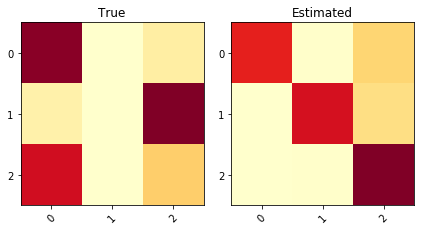

KL divergence: 1.7259	Pearson Correlation between diagonals: -0.4344


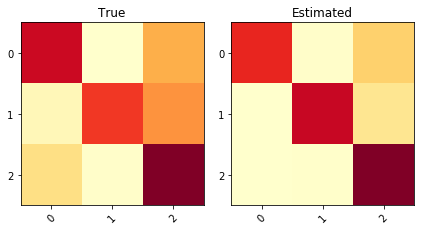

KL divergence: 0.2591	Pearson Correlation between diagonals: 0.6131


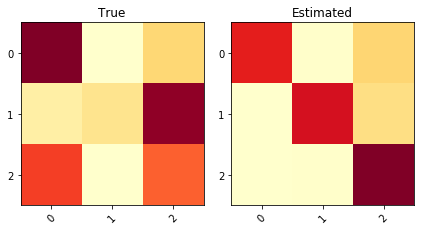

KL divergence: 1.0866	Pearson Correlation between diagonals: -0.2120


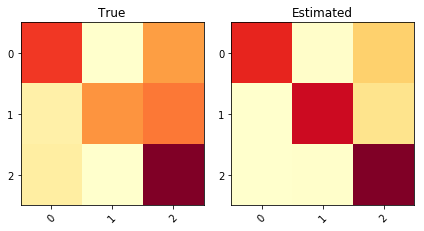

KL divergence: 0.2478	Pearson Correlation between diagonals: 0.7236


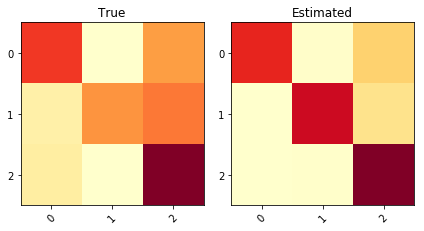

KL divergence: 0.2480	Pearson Correlation between diagonals: 0.7300


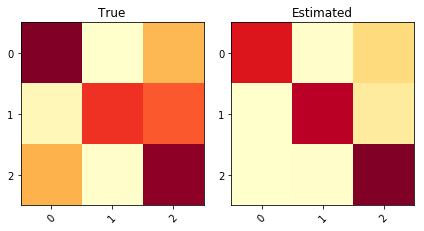

KL divergence: 0.4554	Pearson Correlation between diagonals: -0.0444
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.820513      0.820513   0.520173  0.0737737           0.0394929       0.0691972
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.620714                0.792509
====  =======================  ======================
Test


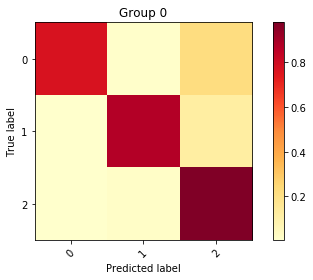

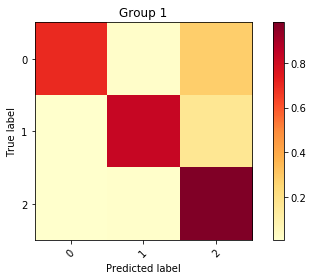

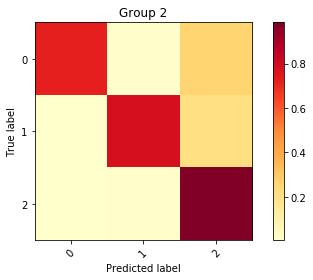

Inertia: 0.001852757598195846
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.367625      36   0.364847     0.874186   0.139261       0.932436   0.540853    0.769231      0.769231
   1         1  0.268373      26   0.415645     0.838624   0.185258       0.911159   0.50529     0.688645      0.688645
   2         2  0.364003      36   0.42033      0.831836   0.192676       0.907515   0.498502    0.661783      0.661783
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [84]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


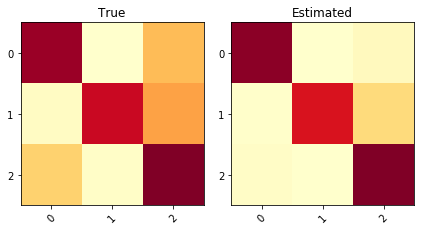

KL divergence: 0.3171	Pearson Correlation between diagonals: 0.9744


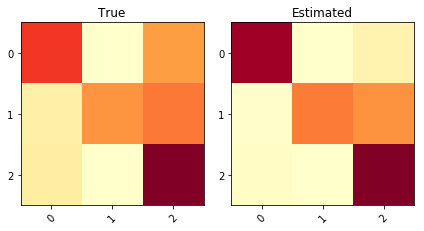

KL divergence: 0.1976	Pearson Correlation between diagonals: 0.8653


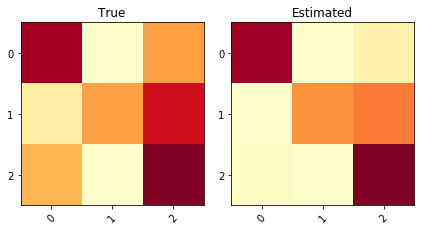

KL divergence: 0.2630	Pearson Correlation between diagonals: 1.0000


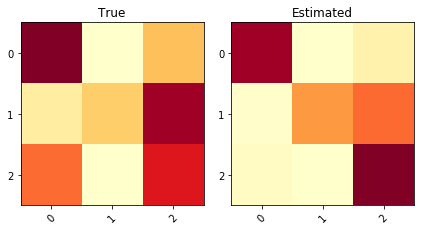

KL divergence: 0.3929	Pearson Correlation between diagonals: 0.9058


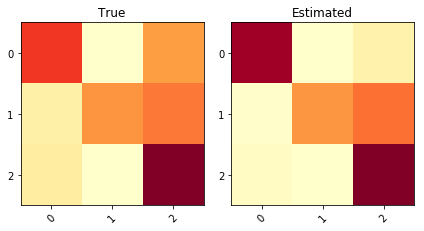

KL divergence: 0.1846	Pearson Correlation between diagonals: 0.8607


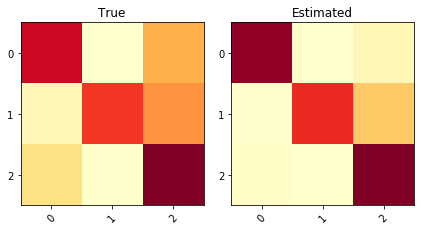

KL divergence: 0.2575	Pearson Correlation between diagonals: 0.9122


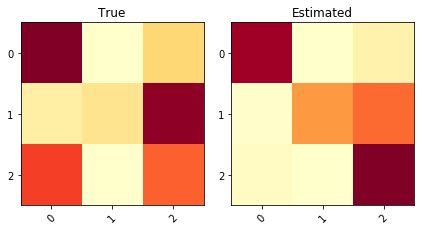

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


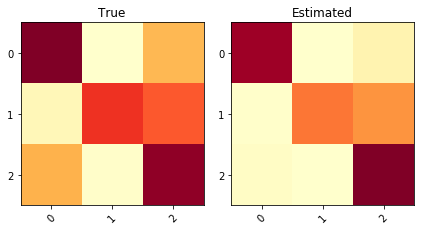

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9753


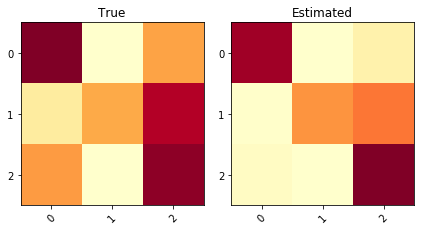

KL divergence: 0.3003	Pearson Correlation between diagonals: 0.9871


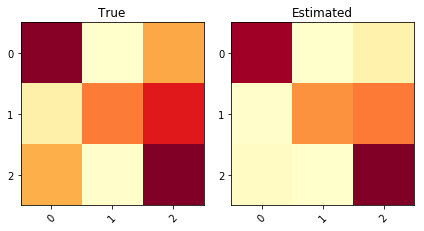

KL divergence: 0.2502	Pearson Correlation between diagonals: 0.9966


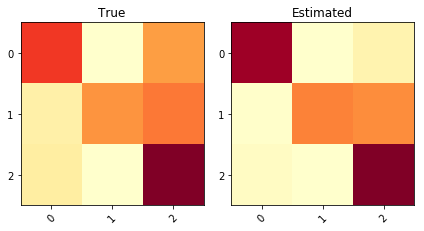

KL divergence: 0.1947	Pearson Correlation between diagonals: 0.8643


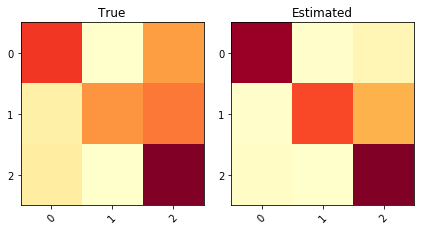

KL divergence: 0.2346	Pearson Correlation between diagonals: 0.8737


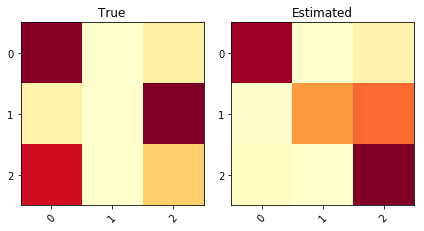

KL divergence: 0.9132	Pearson Correlation between diagonals: 0.6389


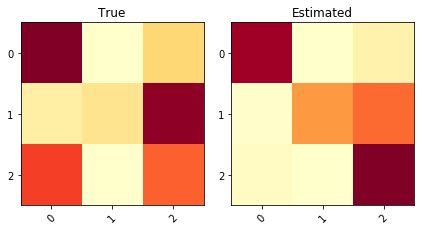

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


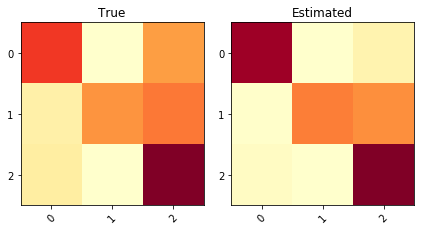

KL divergence: 0.1963	Pearson Correlation between diagonals: 0.8649
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.922263      0.922263   0.353131  0.0592165            0.703907       0.0559583
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.634365                0.789554
====  =======================  ======================
Test


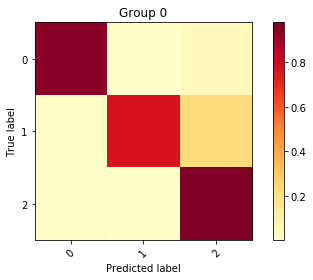

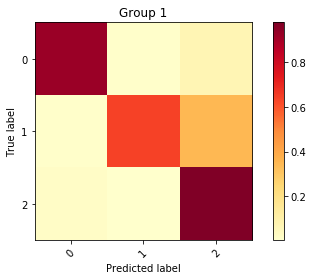

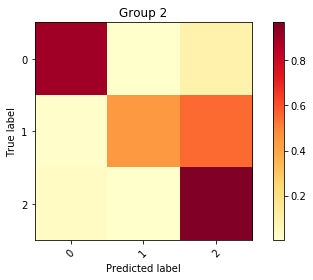

Inertia: 0.010852160902383426
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.389124      38   0.295749     0.899965   0.111069       0.946175   0.566631    0.879121      0.879121
   1         1  0.270756      27   0.367987     0.847832   0.18157        0.914092   0.514498    0.726496      0.726496
   2         2  0.34012       34   0.405299     0.770491   0.31794        0.857818   0.437158    0.649573      0.649573
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [85]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


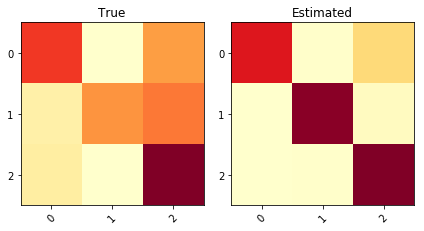

KL divergence: 0.5126	Pearson Correlation between diagonals: 0.2116


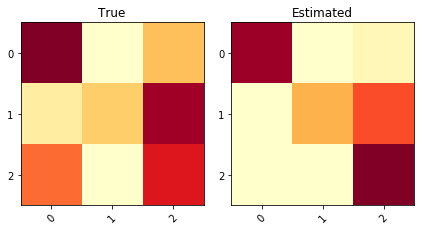

KL divergence: 0.7298	Pearson Correlation between diagonals: 0.9183


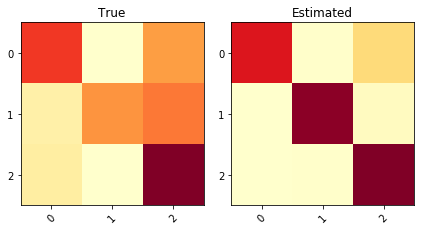

KL divergence: 0.5141	Pearson Correlation between diagonals: 0.2191


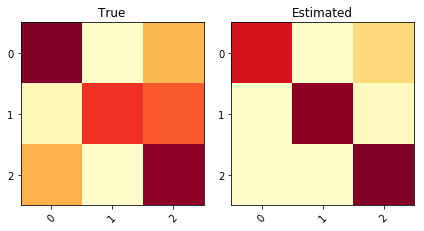

KL divergence: 0.6678	Pearson Correlation between diagonals: -0.4825


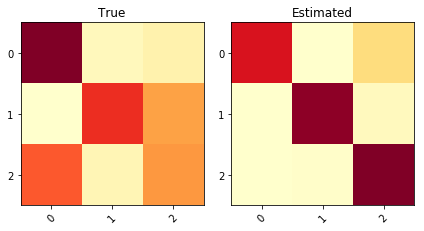

KL divergence: 1.1109	Pearson Correlation between diagonals: -0.9453


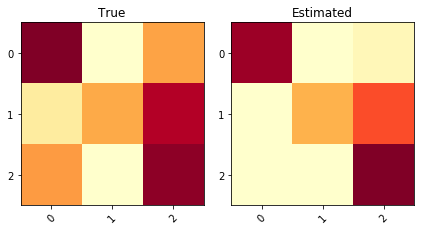

KL divergence: 0.5647	Pearson Correlation between diagonals: 0.9919


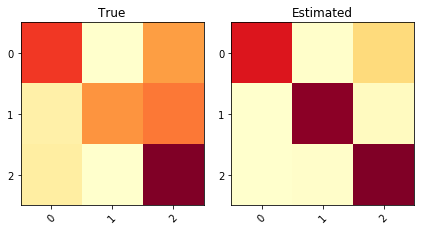

KL divergence: 0.5150	Pearson Correlation between diagonals: 0.2225


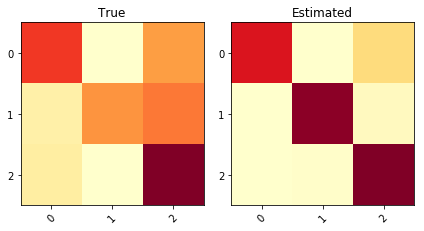

KL divergence: 0.5212	Pearson Correlation between diagonals: 0.2360


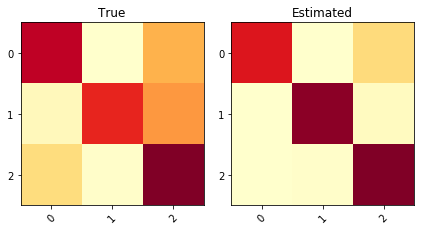

KL divergence: 0.4663	Pearson Correlation between diagonals: 0.0960


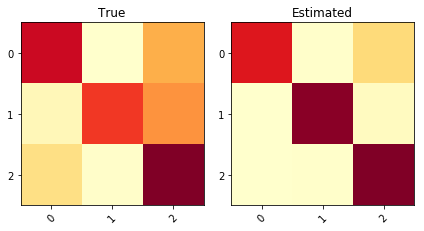

KL divergence: 0.4578	Pearson Correlation between diagonals: 0.1253


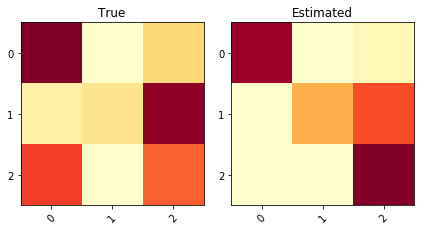

KL divergence: 0.9249	Pearson Correlation between diagonals: 0.8212


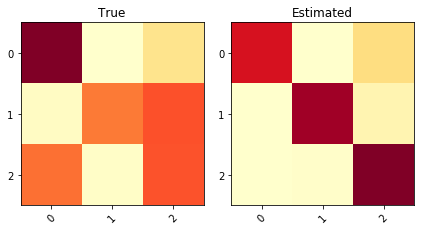

KL divergence: 0.9598	Pearson Correlation between diagonals: -0.8915


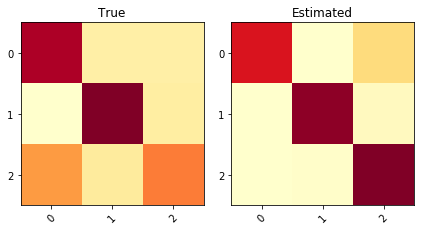

KL divergence: 0.7263	Pearson Correlation between diagonals: -0.4303


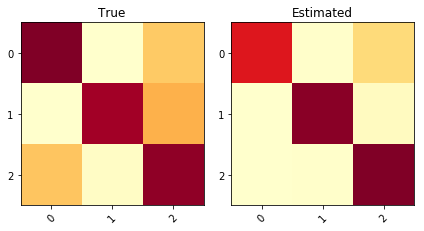

KL divergence: 0.4699	Pearson Correlation between diagonals: -0.7987


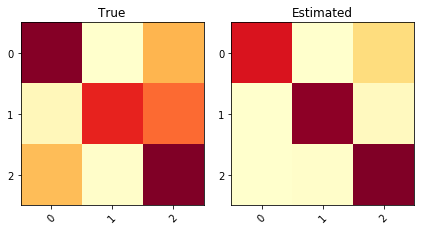

KL divergence: 0.6251	Pearson Correlation between diagonals: -0.3536
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.87383       0.87383   0.662271  0.0864721          -0.0131429       0.0562304
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.629567                0.789673
====  =======================  ======================
Test


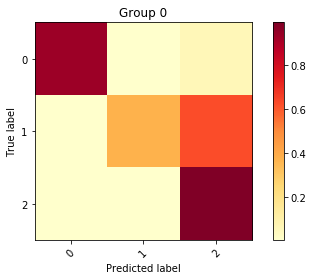

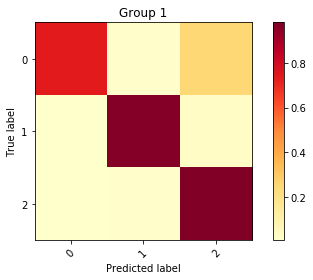

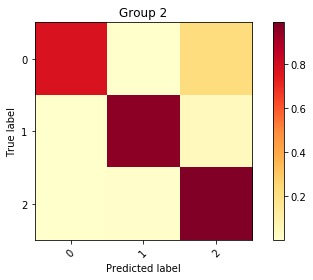

Inertia: 0.059482101389827825
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.342056      34   0.325922     0.767052   0.354565       0.847231   0.433719    0.634921      0.634921
   1         1  0.182671      18   0.295034     0.895159   0.119226       0.942659   0.561826    0.868132      0.868132
   2         2  0.475273      47   0.272466     0.905781   0.104713       0.949267   0.572447    0.860806      0.860806
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [86]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [99]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7806267806267806


*** Soft-Majority (Train with softMV) ***
Train


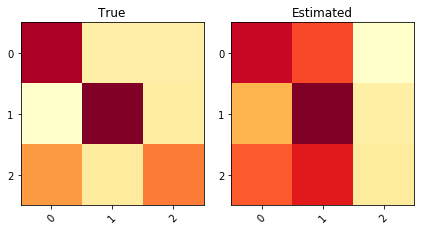

KL divergence: 0.3287	Pearson Correlation between diagonals: 0.9998


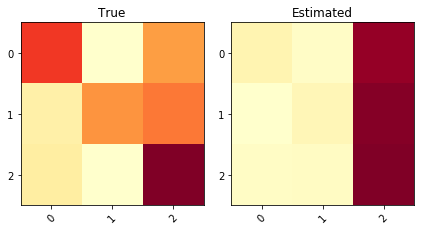

KL divergence: 0.3117	Pearson Correlation between diagonals: 0.9271


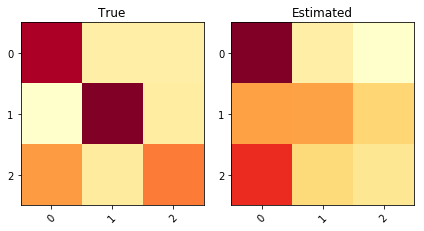

KL divergence: 0.3246	Pearson Correlation between diagonals: 0.5972


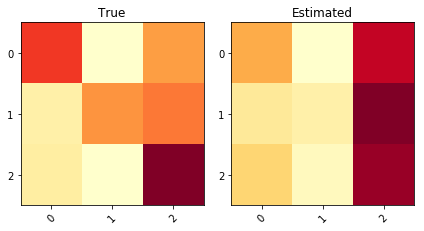

KL divergence: 0.2315	Pearson Correlation between diagonals: 0.9988


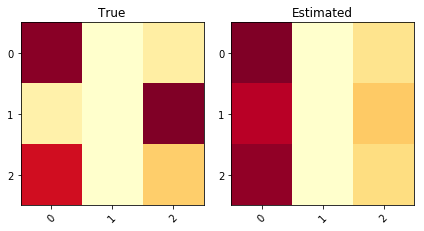

KL divergence: 0.3371	Pearson Correlation between diagonals: 0.9969


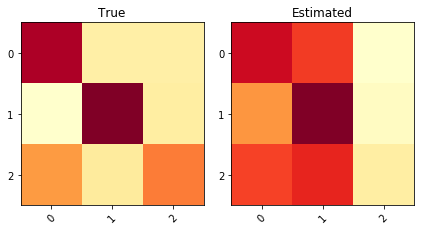

KL divergence: 0.3481	Pearson Correlation between diagonals: 1.0000


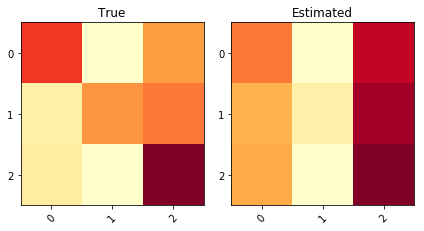

KL divergence: 0.2244	Pearson Correlation between diagonals: 0.9931


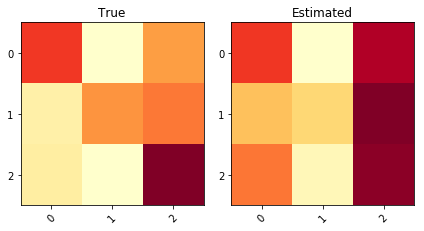

KL divergence: 0.2361	Pearson Correlation between diagonals: 0.9726


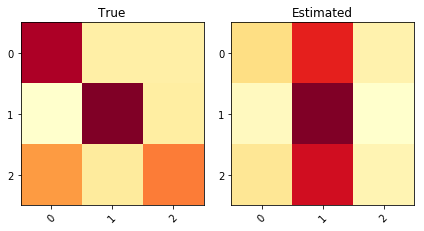

KL divergence: 0.4834	Pearson Correlation between diagonals: 0.7558


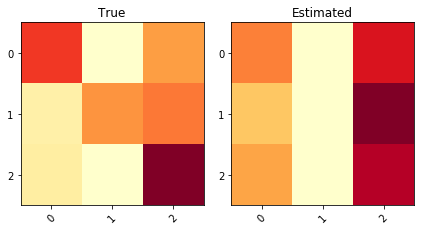

KL divergence: 2.1248	Pearson Correlation between diagonals: 0.9728


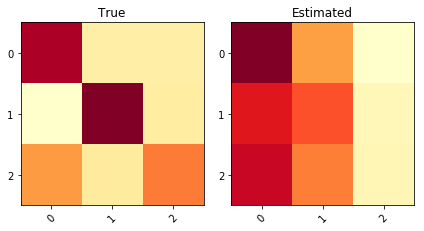

KL divergence: 0.3907	Pearson Correlation between diagonals: 0.8198


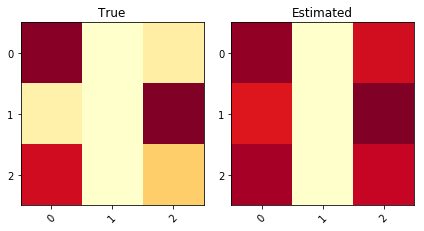

KL divergence: 0.2311	Pearson Correlation between diagonals: 0.7933


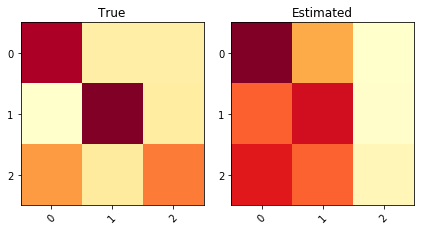

KL divergence: 0.3807	Pearson Correlation between diagonals: 0.9245


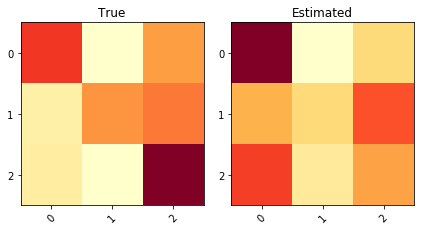

KL divergence: 0.3544	Pearson Correlation between diagonals: 0.1098


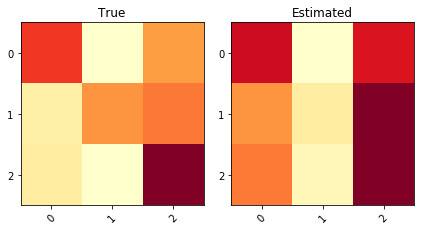

KL divergence: 0.2527	Pearson Correlation between diagonals: 0.8976
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907   0.322981   0.077249            0.844747
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.802198      0.802198
====  ======  ==========  ============


In [100]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


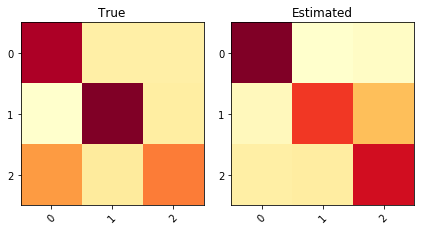

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.0732


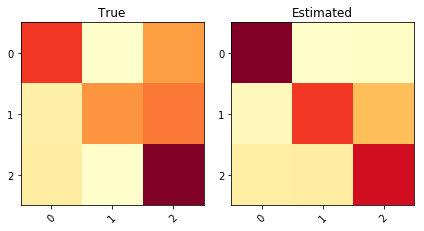

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


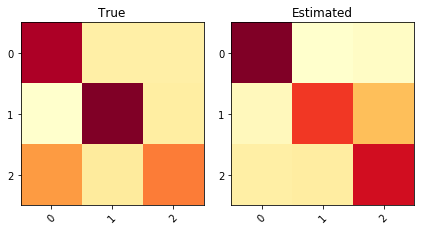

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.0732


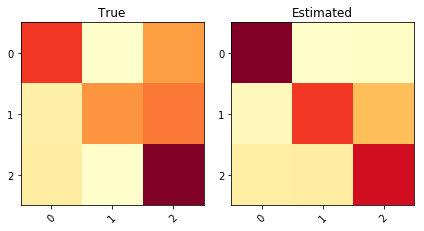

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


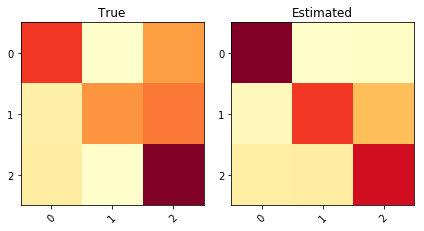

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


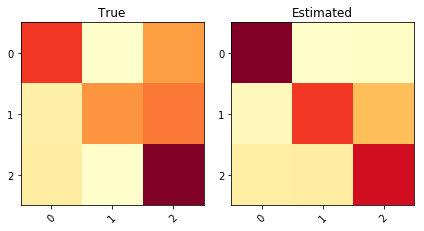

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


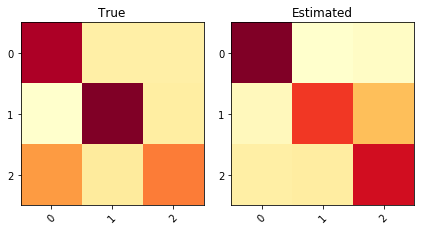

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.0732


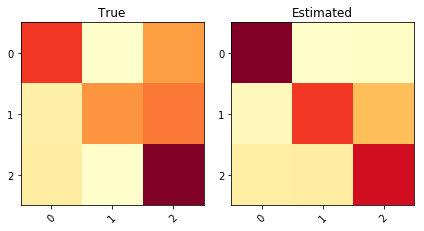

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


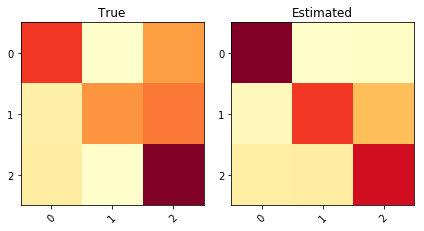

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


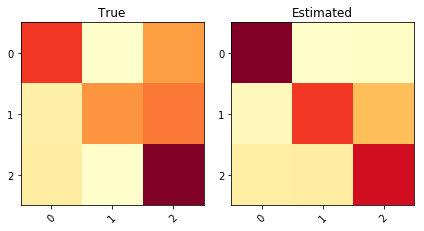

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


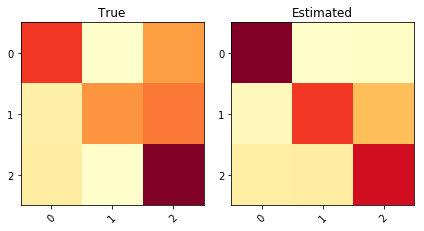

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


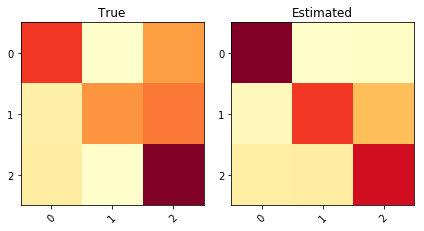

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


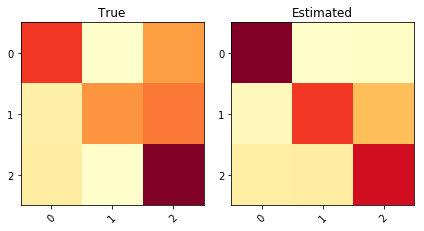

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


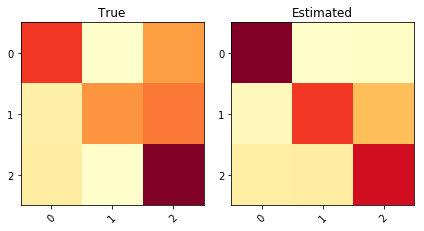

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


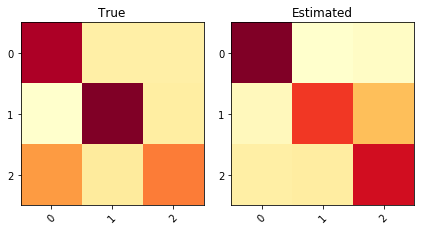

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.0732
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907   0.495249   0.131144            0.320479
====  ======  ==========  ============  =========  =========  ==================


In [101]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


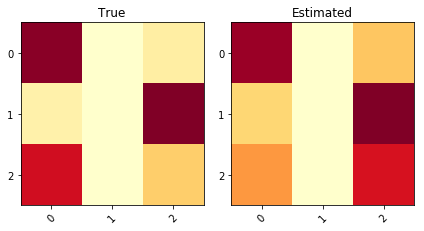

KL divergence: 0.1346	Pearson Correlation between diagonals: 0.8187


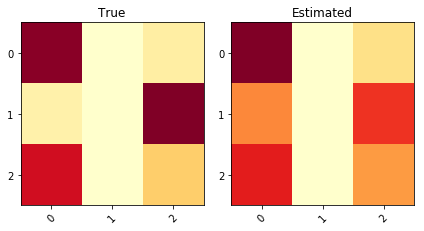

KL divergence: 0.1104	Pearson Correlation between diagonals: 0.9837


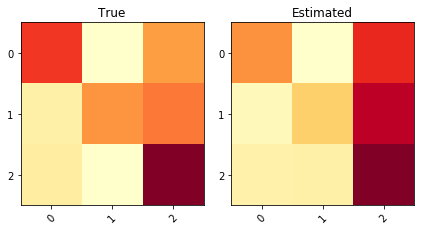

KL divergence: 0.1163	Pearson Correlation between diagonals: 0.9933


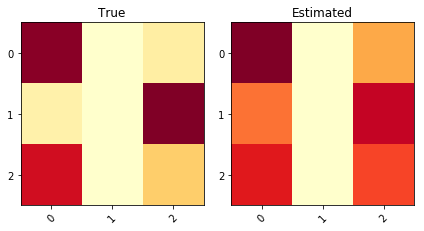

KL divergence: 0.1428	Pearson Correlation between diagonals: 0.9187


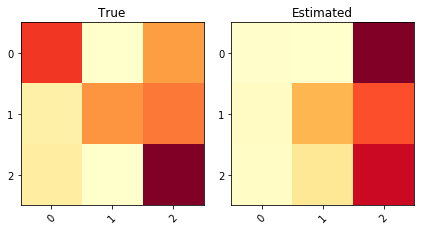

KL divergence: 0.3511	Pearson Correlation between diagonals: 0.6671


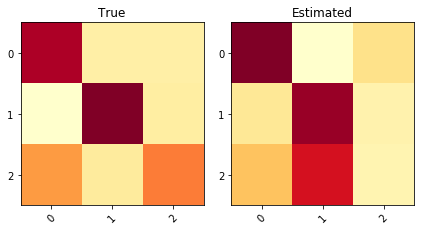

KL divergence: 0.2662	Pearson Correlation between diagonals: 0.9703


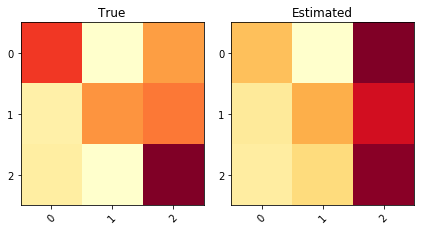

KL divergence: 0.1885	Pearson Correlation between diagonals: 0.8902


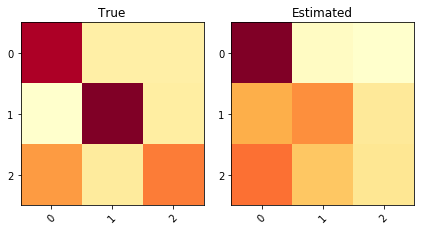

KL divergence: 0.2864	Pearson Correlation between diagonals: 0.6677


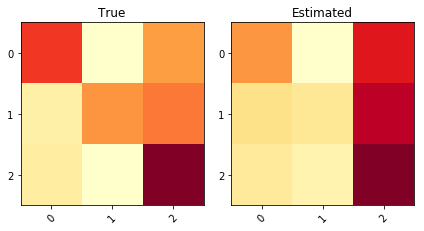

KL divergence: 0.1477	Pearson Correlation between diagonals: 0.9996


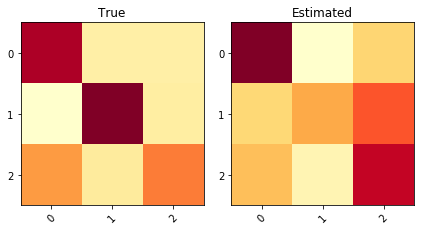

KL divergence: 0.2979	Pearson Correlation between diagonals: -0.4608


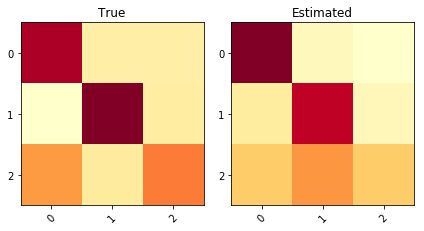

KL divergence: 0.1763	Pearson Correlation between diagonals: 0.9318


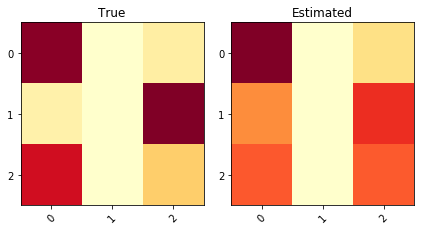

KL divergence: 0.1358	Pearson Correlation between diagonals: 0.9388


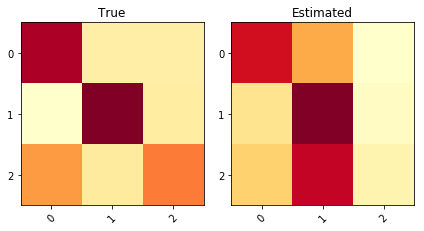

KL divergence: 0.4241	Pearson Correlation between diagonals: 1.0000


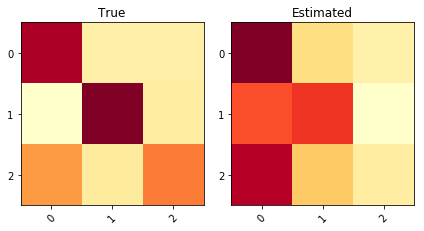

KL divergence: 0.3089	Pearson Correlation between diagonals: 0.8490


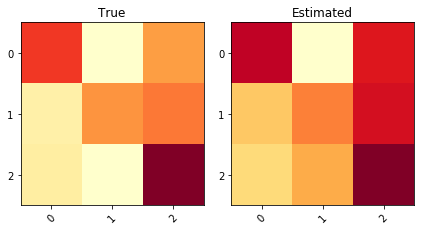

KL divergence: 0.1528	Pearson Correlation between diagonals: 0.9358
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.62963       0.62963   0.217562  0.0520236            0.833282
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.654457      0.654457
====  ======  ==========  ============


In [104]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


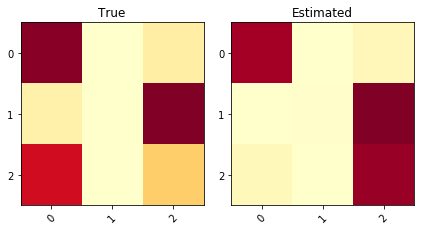

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


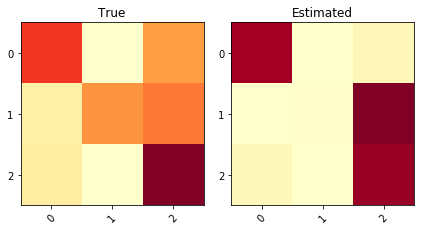

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


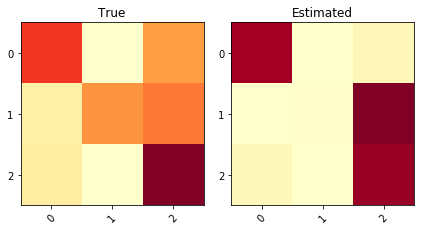

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


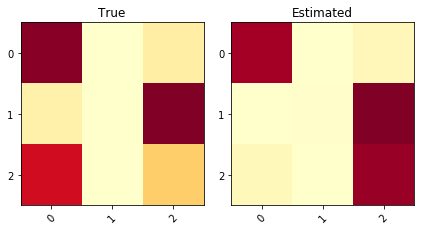

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


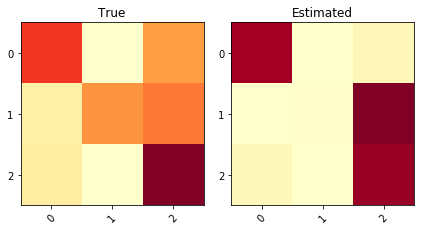

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


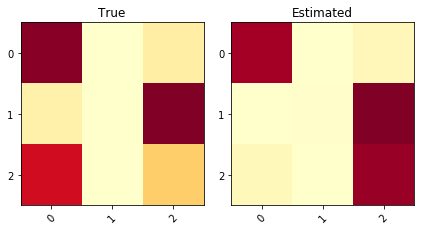

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


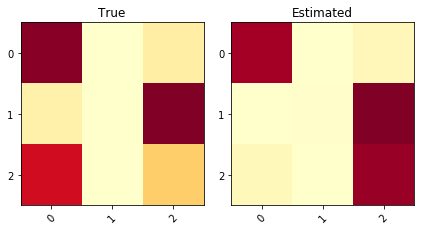

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


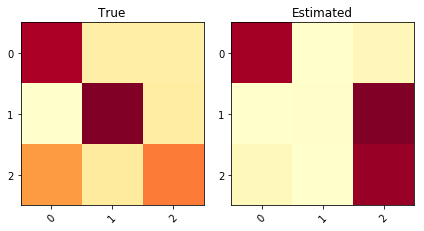

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


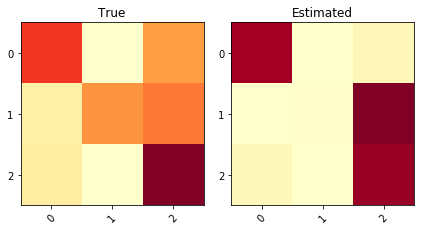

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


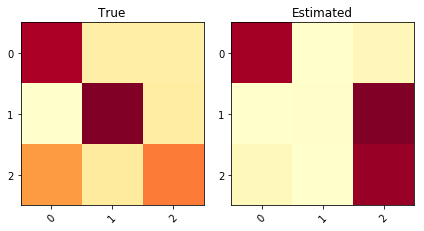

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


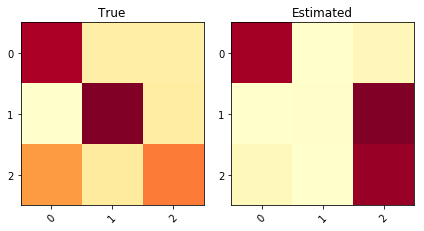

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


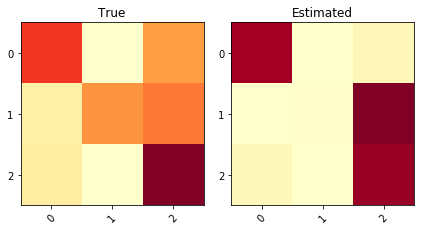

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


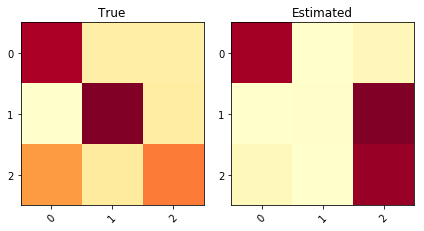

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


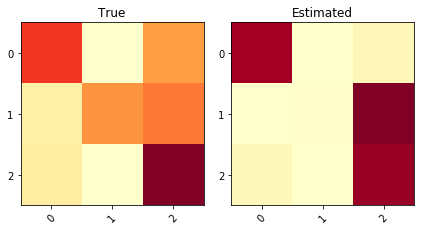

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


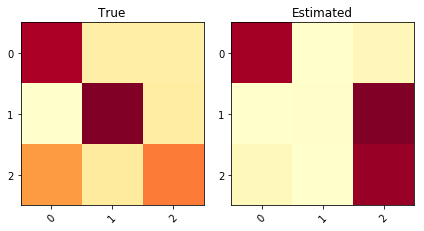

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.62963       0.62963   0.517084  0.0961229            0.428152
====  ======  ==========  ============  =========  =========  ==================


In [105]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


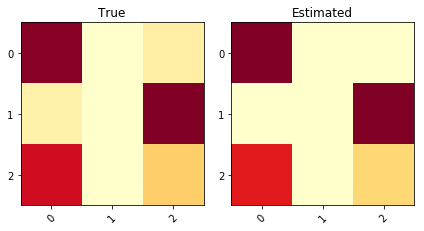

KL divergence: 0.8179	Pearson Correlation between diagonals: 0.9991


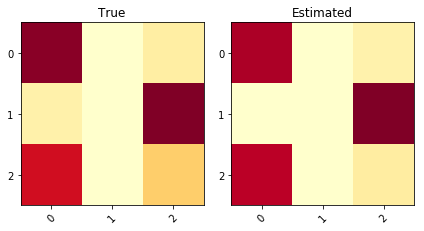

KL divergence: 0.3867	Pearson Correlation between diagonals: 0.9876


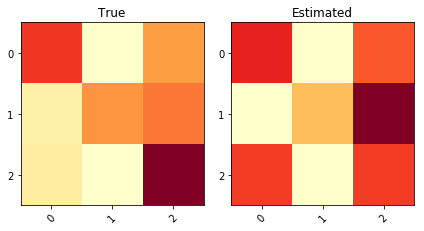

KL divergence: 0.5430	Pearson Correlation between diagonals: 0.7008


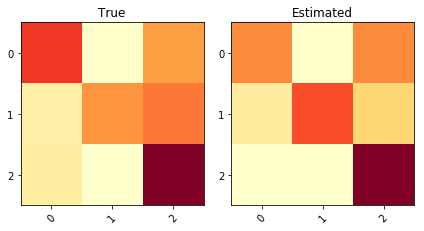

KL divergence: 0.5037	Pearson Correlation between diagonals: 0.8028


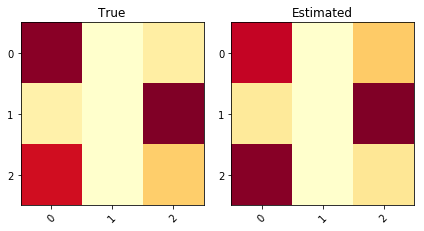

KL divergence: 0.0432	Pearson Correlation between diagonals: 0.9941


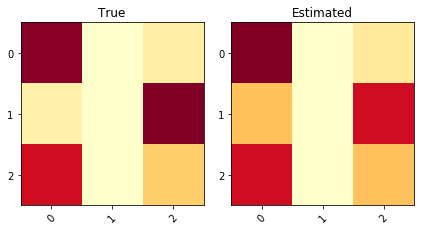

KL divergence: 0.0419	Pearson Correlation between diagonals: 0.9992


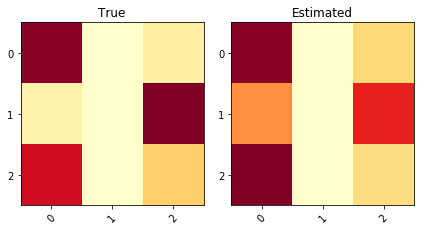

KL divergence: 0.1010	Pearson Correlation between diagonals: 0.9978


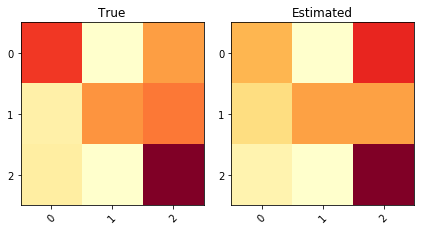

KL divergence: 0.0692	Pearson Correlation between diagonals: 0.8778


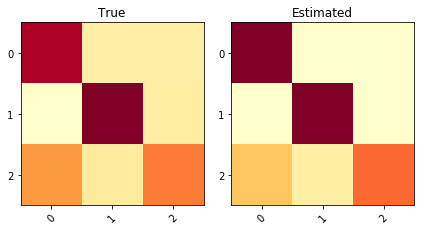

KL divergence: 1.2776	Pearson Correlation between diagonals: 0.9813


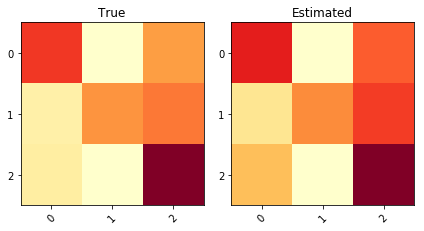

KL divergence: 0.0272	Pearson Correlation between diagonals: 0.9943


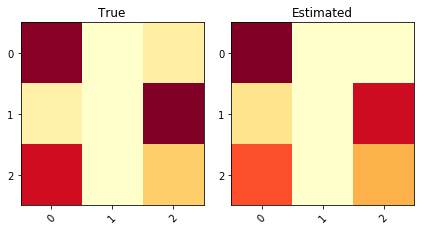

KL divergence: 0.4402	Pearson Correlation between diagonals: 0.9954


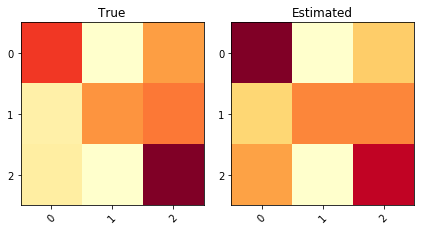

KL divergence: 0.0872	Pearson Correlation between diagonals: 0.5889


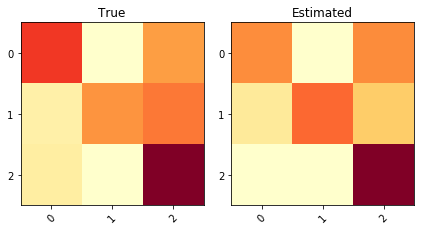

KL divergence: 0.4909	Pearson Correlation between diagonals: 0.8625


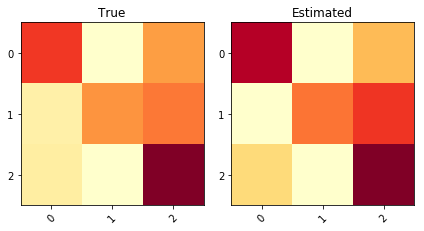

KL divergence: 0.4077	Pearson Correlation between diagonals: 0.9155


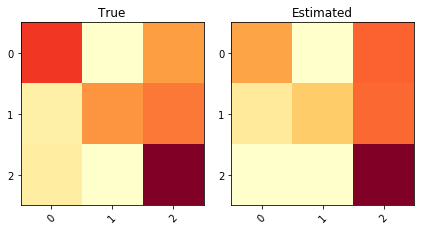

KL divergence: 0.4934	Pearson Correlation between diagonals: 0.9752
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.934473      0.934473   0.701537  0.0317218            0.854718
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.942613      0.942613
====  ======  ==========  ============


In [106]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


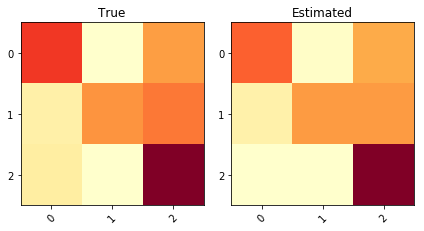

KL divergence: 0.0573	Pearson Correlation between diagonals: 0.9882


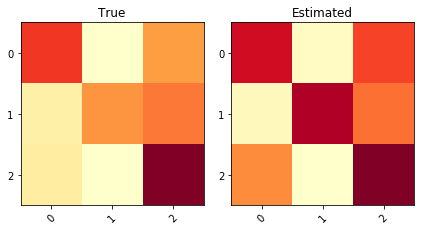

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.6597


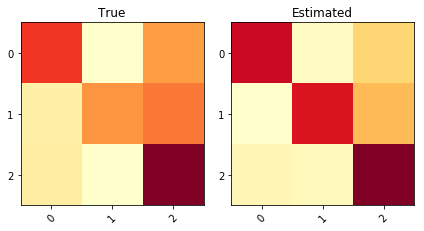

KL divergence: 0.1029	Pearson Correlation between diagonals: 0.9853


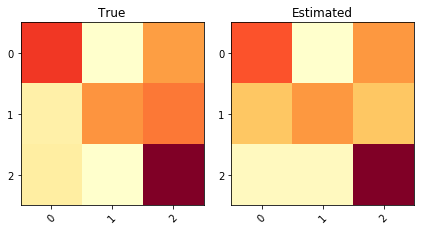

KL divergence: 0.1331	Pearson Correlation between diagonals: 0.9934


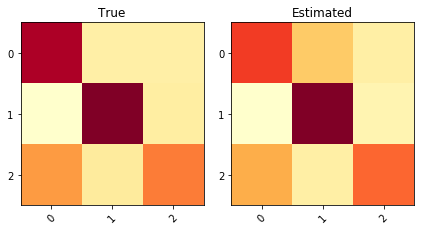

KL divergence: 0.0685	Pearson Correlation between diagonals: 0.8025


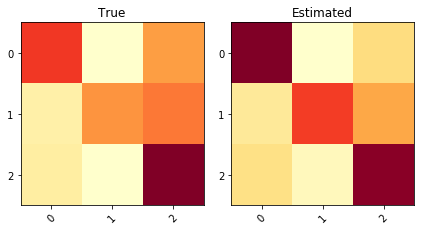

KL divergence: 0.1162	Pearson Correlation between diagonals: 0.7569


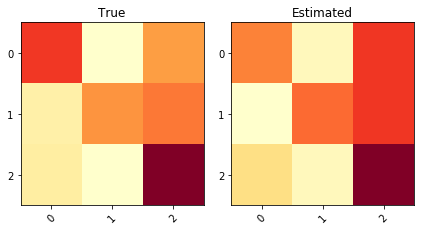

KL divergence: 0.1045	Pearson Correlation between diagonals: 0.8859


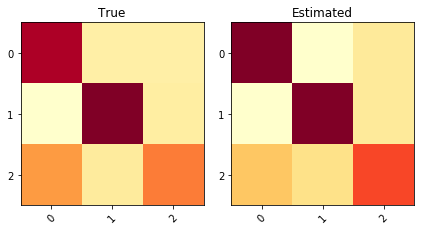

KL divergence: 0.0679	Pearson Correlation between diagonals: 0.9813


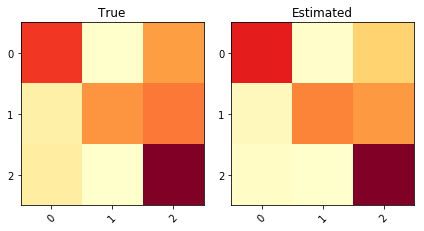

KL divergence: 0.0699	Pearson Correlation between diagonals: 0.9964


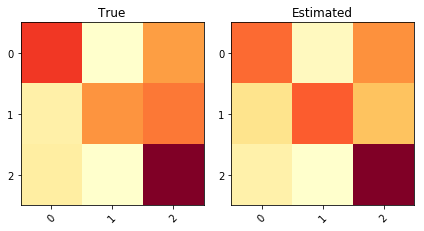

KL divergence: 0.0939	Pearson Correlation between diagonals: 0.9022


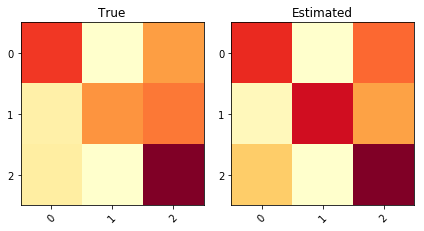

KL divergence: 0.1053	Pearson Correlation between diagonals: 0.7452


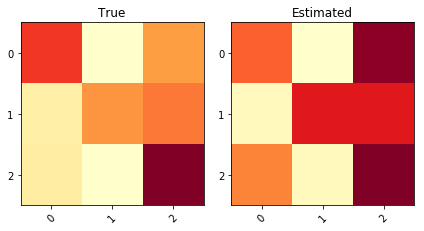

KL divergence: 0.1626	Pearson Correlation between diagonals: 0.6828


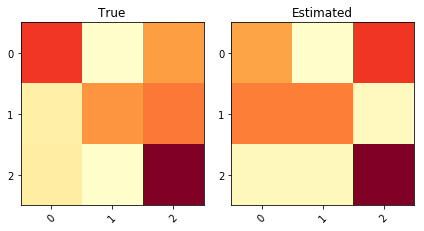

KL divergence: 0.2778	Pearson Correlation between diagonals: 0.8348


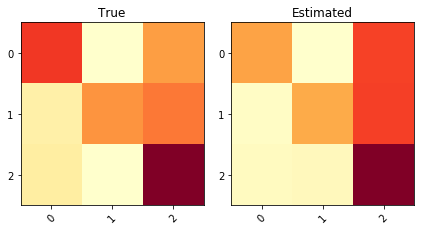

KL divergence: 0.0931	Pearson Correlation between diagonals: 0.9376


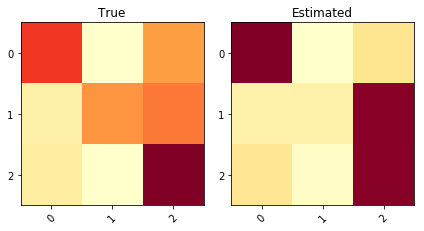

KL divergence: 0.1806	Pearson Correlation between diagonals: 0.7858
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.825397      0.825397   0.124283  0.0370282            0.877729        0.175853
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.65289                0.826554
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.818071 

In [17]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


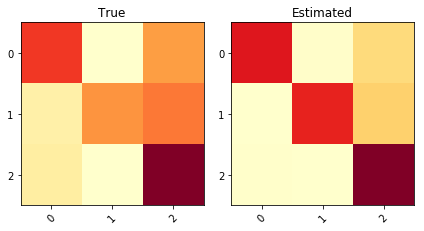

KL divergence: 0.2348	Pearson Correlation between diagonals: 0.9614


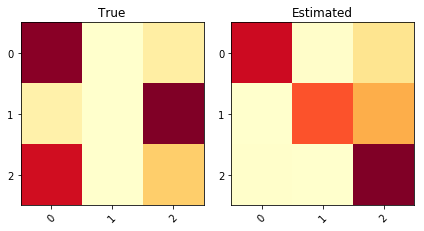

KL divergence: 1.3918	Pearson Correlation between diagonals: 0.3209


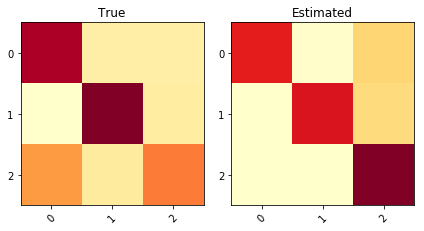

KL divergence: 0.7059	Pearson Correlation between diagonals: -0.9483


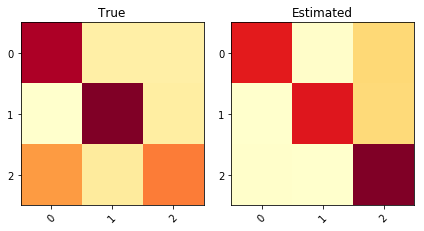

KL divergence: 0.7015	Pearson Correlation between diagonals: -0.9683


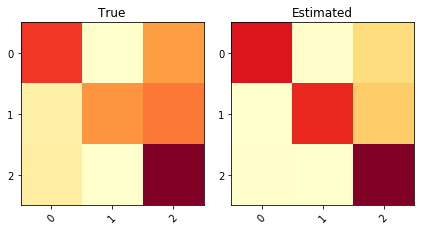

KL divergence: 0.2301	Pearson Correlation between diagonals: 0.9772


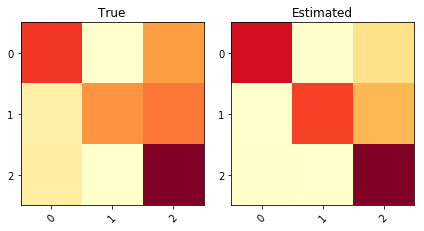

KL divergence: 0.2154	Pearson Correlation between diagonals: 0.9987


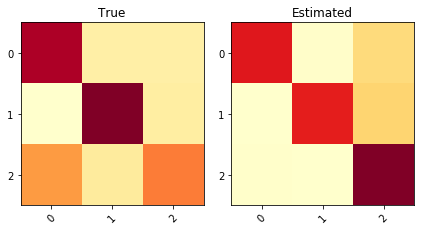

KL divergence: 0.6946	Pearson Correlation between diagonals: -0.9927


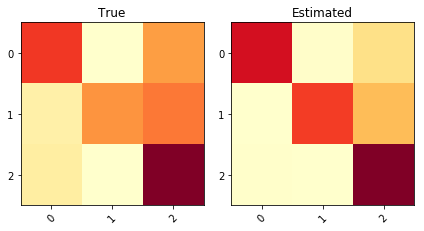

KL divergence: 0.2175	Pearson Correlation between diagonals: 1.0000


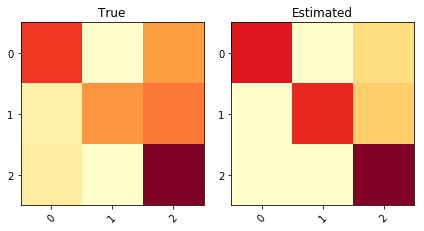

KL divergence: 0.2318	Pearson Correlation between diagonals: 0.9719


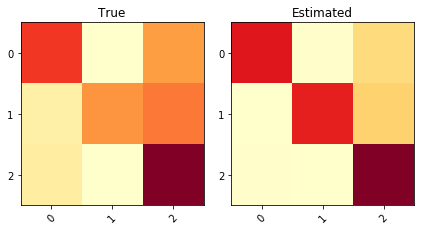

KL divergence: 0.2370	Pearson Correlation between diagonals: 0.9526


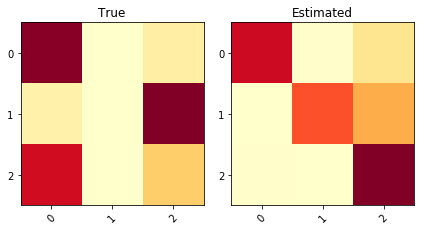

KL divergence: 1.3941	Pearson Correlation between diagonals: 0.3164


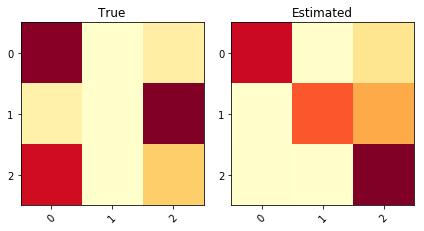

KL divergence: 1.3802	Pearson Correlation between diagonals: 0.3438


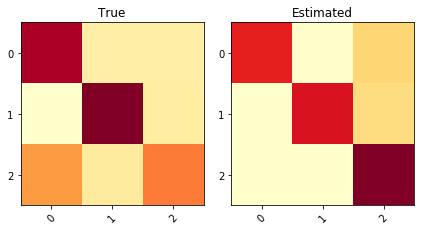

KL divergence: 0.7092	Pearson Correlation between diagonals: -0.9320


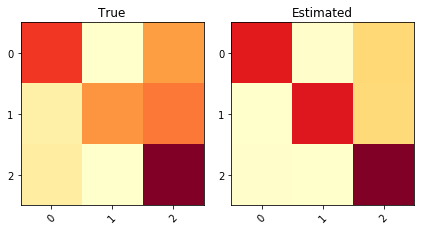

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.8984


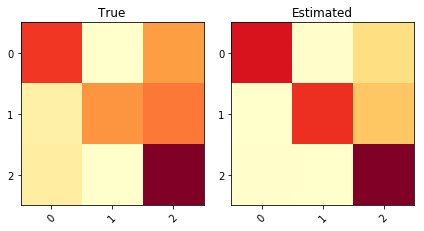

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9924
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.89825       0.89825   0.577248   0.084947            0.328995        0.151221
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.630185                0.786908
====  =======================  ======================
Test


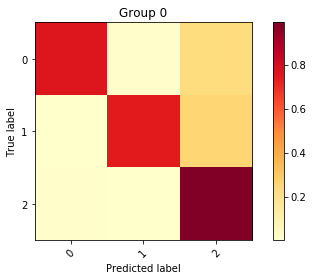

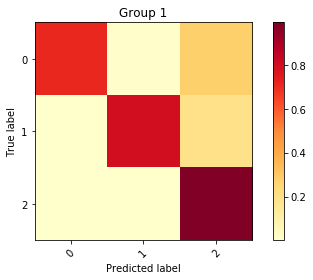

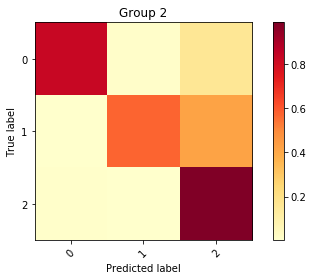

Inertia: 0.007227727444842458
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.29693      593   0.411571     0.831426   0.193448       0.907181   0.498093    0.715507      0.715507
   1         1  0.419679     839   0.398301     0.836052   0.18867        0.909572   0.502719    0.805861      0.805861
   2         2  0.283392     566   0.418249     0.798585   0.249393       0.883511   0.465252    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [103]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


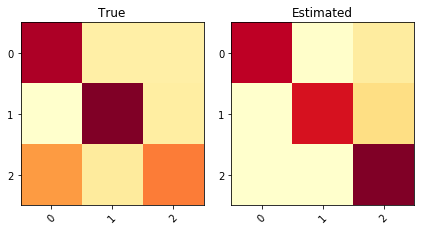

KL divergence: 0.8500	Pearson Correlation between diagonals: -0.9831


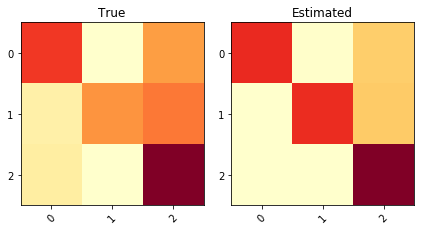

KL divergence: 0.2617	Pearson Correlation between diagonals: 0.9333


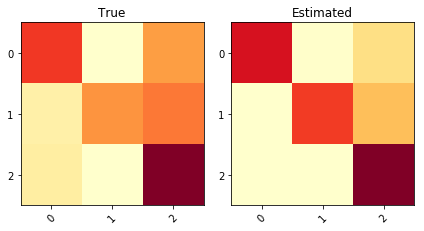

KL divergence: 0.2636	Pearson Correlation between diagonals: 0.9996


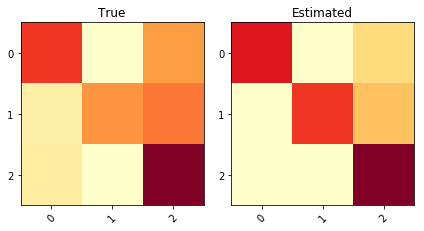

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9898


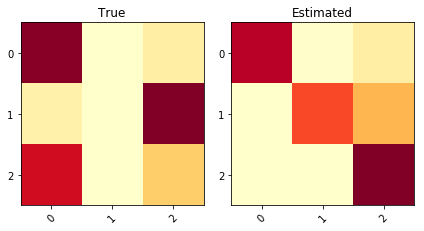

KL divergence: 1.7264	Pearson Correlation between diagonals: 0.4592


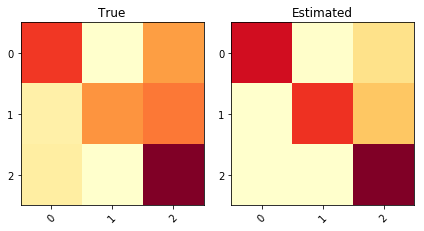

KL divergence: 0.2774	Pearson Correlation between diagonals: 0.9998


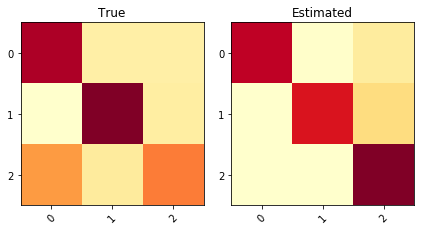

KL divergence: 0.8532	Pearson Correlation between diagonals: -0.9805


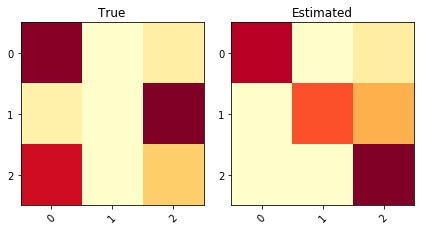

KL divergence: 1.7082	Pearson Correlation between diagonals: 0.4647


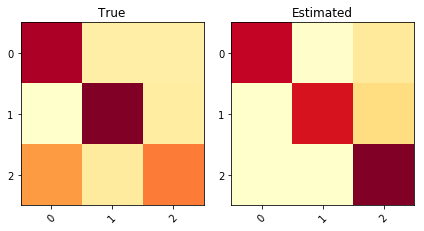

KL divergence: 0.8563	Pearson Correlation between diagonals: -0.9934


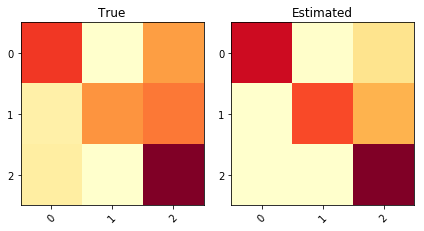

KL divergence: 0.2637	Pearson Correlation between diagonals: 0.9915


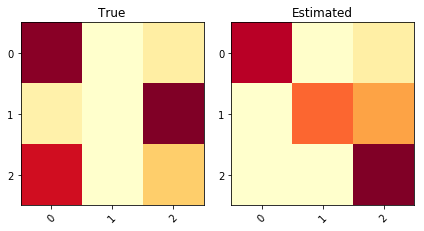

KL divergence: 1.6701	Pearson Correlation between diagonals: 0.5103


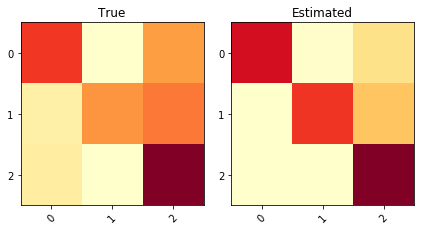

KL divergence: 0.2729	Pearson Correlation between diagonals: 0.9997


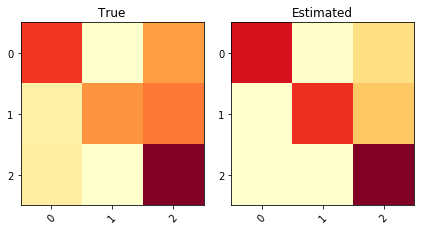

KL divergence: 0.2725	Pearson Correlation between diagonals: 0.9956


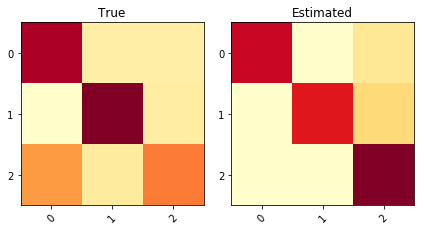

KL divergence: 0.8648	Pearson Correlation between diagonals: -0.9929


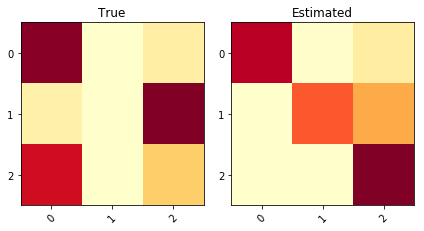

KL divergence: 1.6948	Pearson Correlation between diagonals: 0.4763
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.904762      0.904762   0.690459  0.0839284            0.382153        0.135871
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.647914                0.774467
====  =======================  ======================
Test


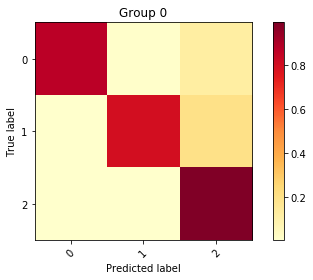

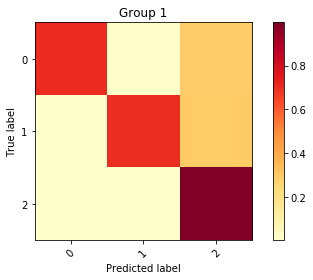

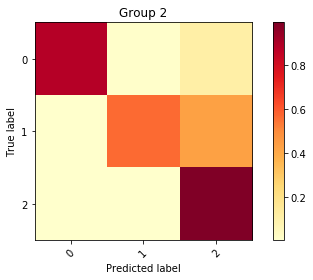

Inertia: 0.010683130628118912
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.308806     617   0.312619     0.890473   0.120068       0.941563   0.55714     0.837607      0.837607
   1         1  0.394164     788   0.422838     0.802826   0.233353       0.889142   0.469493    0.705739      0.705739
   2         2  0.29703      594   0.36901      0.815786   0.231375       0.892482   0.482453    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [104]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


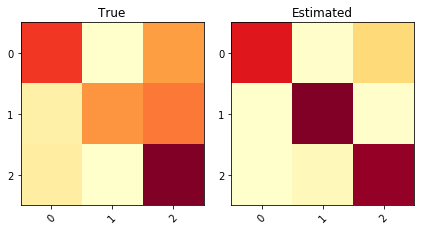

KL divergence: 0.7998	Pearson Correlation between diagonals: -0.0407


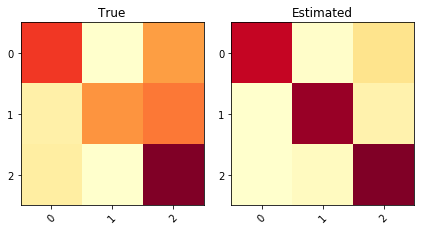

KL divergence: 0.4369	Pearson Correlation between diagonals: 0.4436


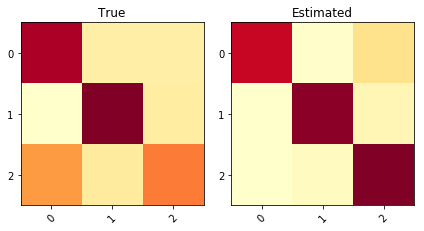

KL divergence: 0.5854	Pearson Correlation between diagonals: -0.4616


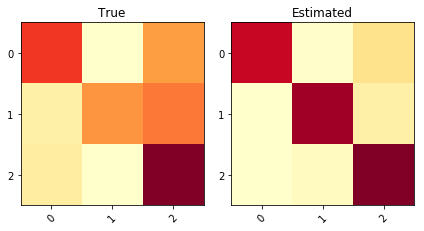

KL divergence: 0.4197	Pearson Correlation between diagonals: 0.5452


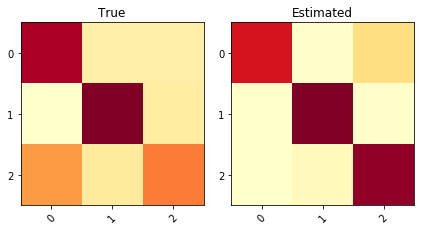

KL divergence: 0.6436	Pearson Correlation between diagonals: -0.1715


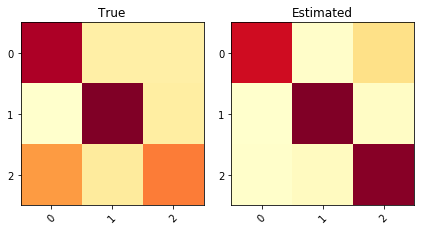

KL divergence: 0.5879	Pearson Correlation between diagonals: -0.2424


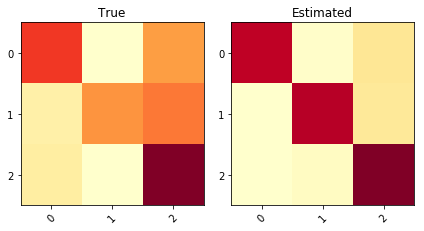

KL divergence: 0.3801	Pearson Correlation between diagonals: 0.8543


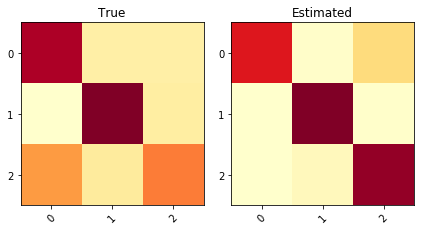

KL divergence: 0.6938	Pearson Correlation between diagonals: -0.1594


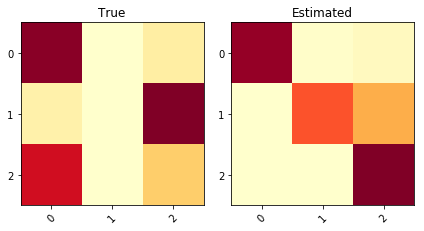

KL divergence: 1.6679	Pearson Correlation between diagonals: 0.6456


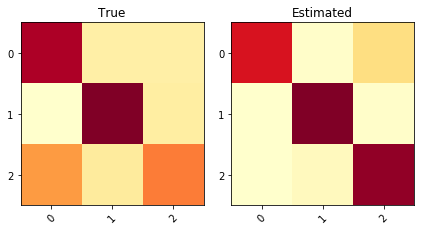

KL divergence: 0.6402	Pearson Correlation between diagonals: -0.1743


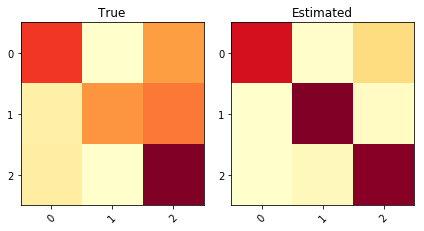

KL divergence: 0.6154	Pearson Correlation between diagonals: 0.0383


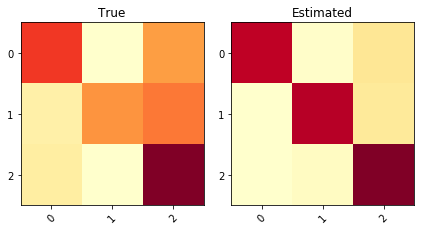

KL divergence: 0.3804	Pearson Correlation between diagonals: 0.8518


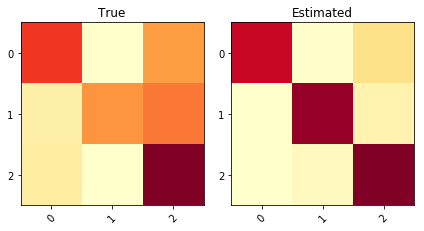

KL divergence: 0.4444	Pearson Correlation between diagonals: 0.4012


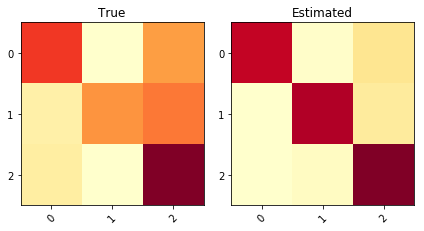

KL divergence: 0.3906	Pearson Correlation between diagonals: 0.7702


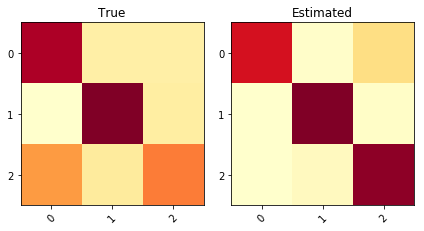

KL divergence: 0.6230	Pearson Correlation between diagonals: -0.1939
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.865283      0.865283   0.752762   0.105377            0.291671        0.120631
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.665967                0.768114
====  =======================  ======================
Test


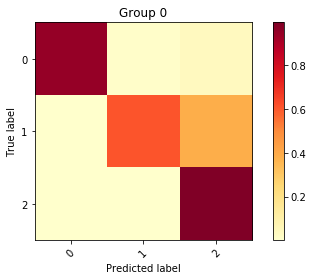

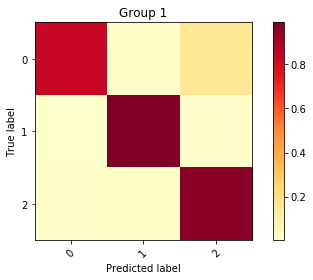

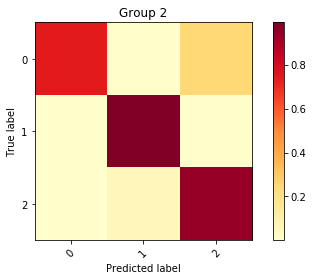

Inertia: 0.04294200268729279
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.320344     640   0.311915     0.851559  0.183786        0.914108   0.518226    0.632479      0.632479
   1         1  0.231641     463   0.242446     0.929067  0.0766458       0.962537   0.595734    0.888889      0.888889
   2         2  0.448015     896   0.290779     0.893769  0.120038        0.942149   0.560435    0.893773      0.893773
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [105]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T=5000, T_{data}=40$)

In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8131868131868132


evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v3 ($T$ = 10000, $T_{data}$ = 40 )

In [23]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8298738298738298


*** Soft-Majority (Train with softMV) ***
Train


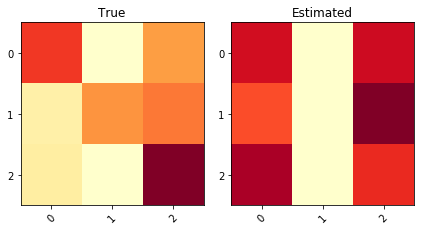

KL divergence: 2.2361	Pearson Correlation between diagonals: 0.7285


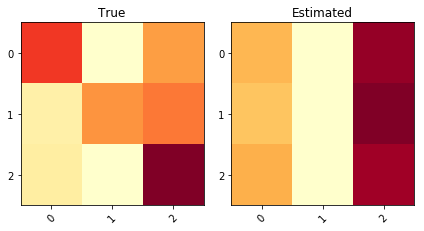

KL divergence: 2.1694	Pearson Correlation between diagonals: 1.0000


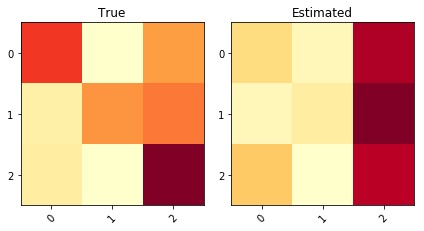

KL divergence: 0.2724	Pearson Correlation between diagonals: 0.9622


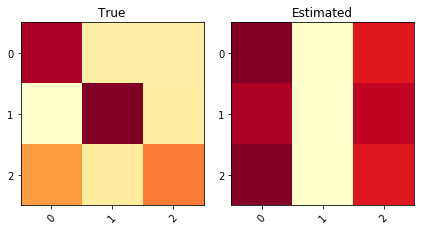

KL divergence: 5.7389	Pearson Correlation between diagonals: -0.4712


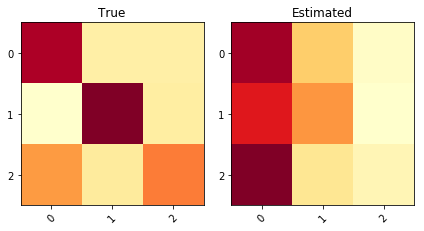

KL divergence: 0.3808	Pearson Correlation between diagonals: 0.7282


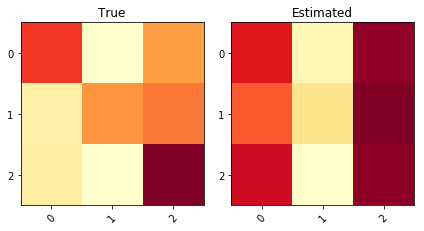

KL divergence: 0.2970	Pearson Correlation between diagonals: 0.9242


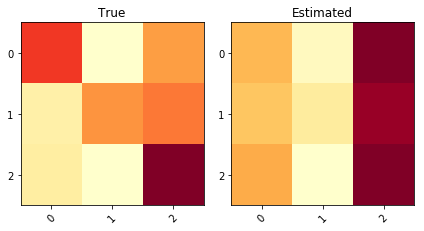

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9893


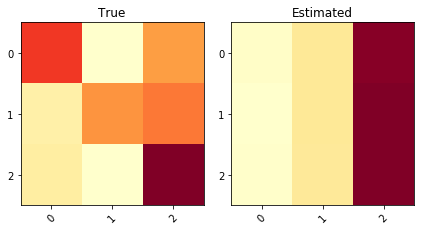

KL divergence: 0.4164	Pearson Correlation between diagonals: 0.8665


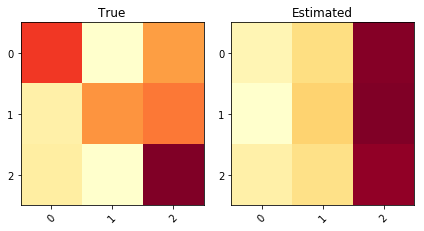

KL divergence: 0.3989	Pearson Correlation between diagonals: 0.8189


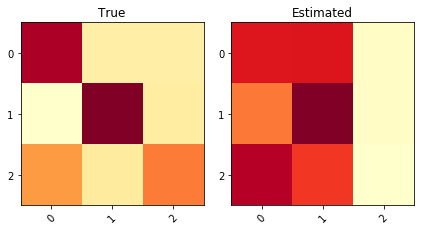

KL divergence: 0.3860	Pearson Correlation between diagonals: 0.9996


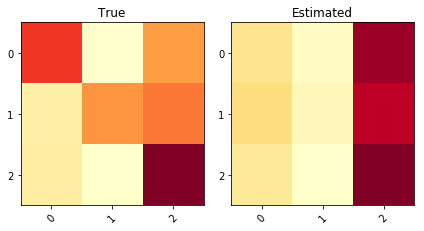

KL divergence: 0.2929	Pearson Correlation between diagonals: 0.9627


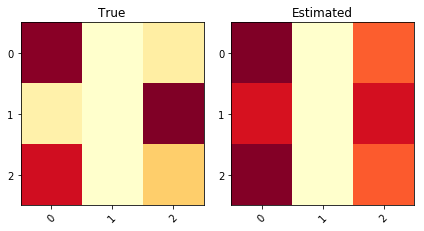

KL divergence: 0.2039	Pearson Correlation between diagonals: 0.9376


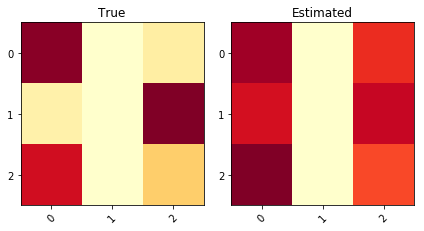

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9013


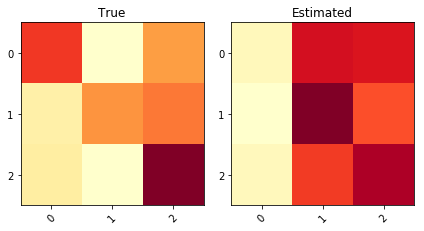

KL divergence: 0.4346	Pearson Correlation between diagonals: 0.0369


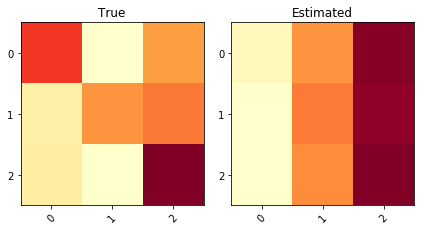

KL divergence: 0.3832	Pearson Correlation between diagonals: 0.5900
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.344729      0.344729   0.943795   0.106243            0.695869
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.343101      0.343101
====  ======  ==========  ============


In [24]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


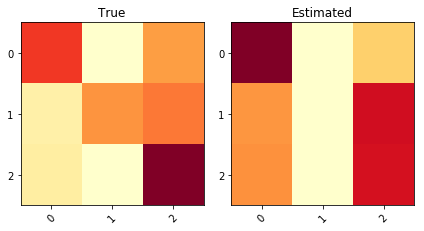

KL divergence: 2.1604	Pearson Correlation between diagonals: 0.6627


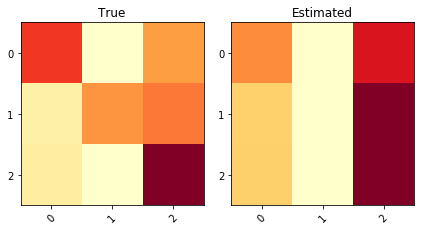

KL divergence: 2.0992	Pearson Correlation between diagonals: 0.9916


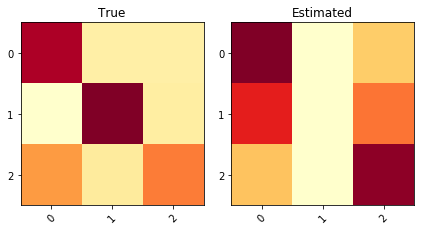

KL divergence: 5.7052	Pearson Correlation between diagonals: -0.6367


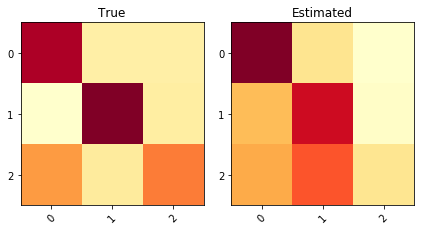

KL divergence: 0.2590	Pearson Correlation between diagonals: 0.9199


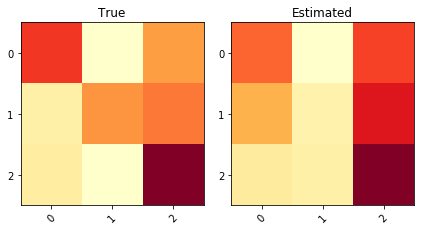

KL divergence: 0.2086	Pearson Correlation between diagonals: 0.9852


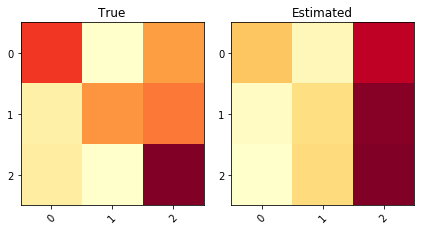

KL divergence: 0.2347	Pearson Correlation between diagonals: 0.9604


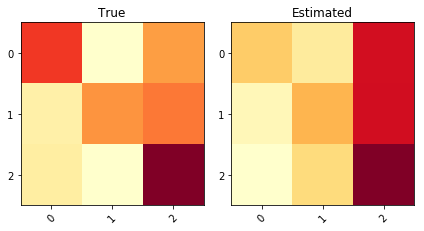

KL divergence: 0.2390	Pearson Correlation between diagonals: 0.8819


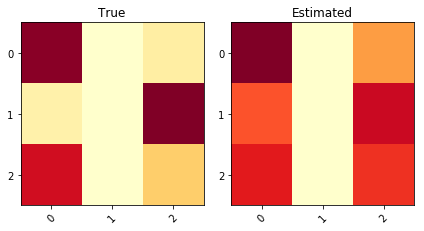

KL divergence: 0.1683	Pearson Correlation between diagonals: 0.8974


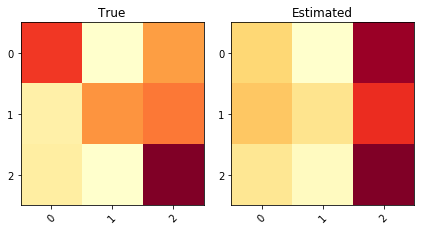

KL divergence: 0.2206	Pearson Correlation between diagonals: 0.9498


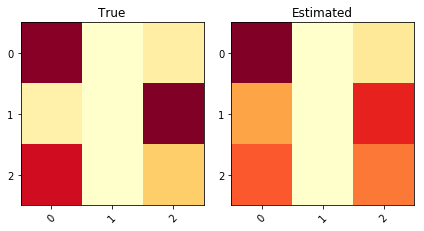

KL divergence: 0.1021	Pearson Correlation between diagonals: 0.9592


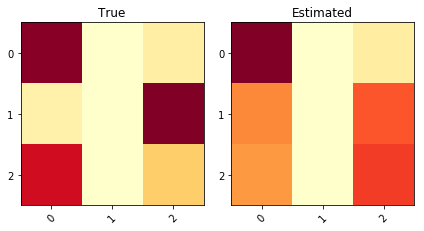

KL divergence: 0.1862	Pearson Correlation between diagonals: 0.9099


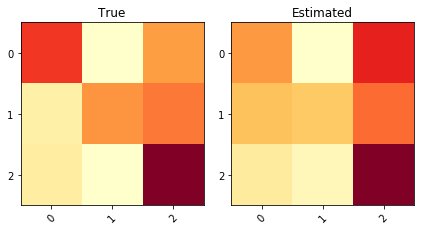

KL divergence: 0.1249	Pearson Correlation between diagonals: 0.9830


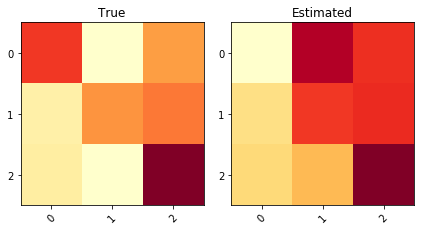

KL divergence: 0.5596	Pearson Correlation between diagonals: 0.4337


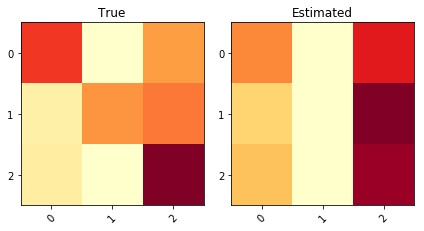

KL divergence: 2.1037	Pearson Correlation between diagonals: 0.9845


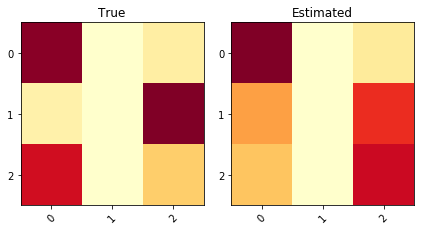

KL divergence: 0.2330	Pearson Correlation between diagonals: 0.8261
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.684575      0.684575   0.875637  0.0878307            0.692878
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.691087      0.691087
====  ======  ==========  ============


In [25]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


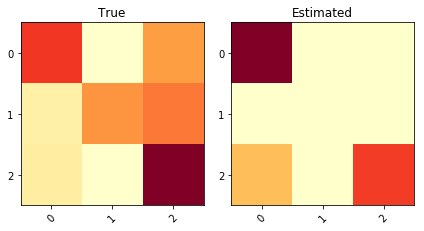

KL divergence: 1.9898	Pearson Correlation between diagonals: 0.5533


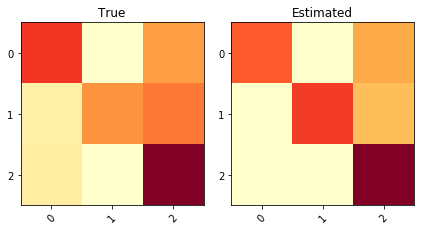

KL divergence: 0.8674	Pearson Correlation between diagonals: 0.8513


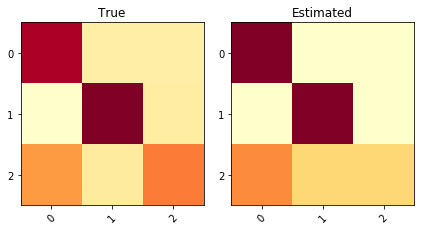

KL divergence: 1.3143	Pearson Correlation between diagonals: 0.9813


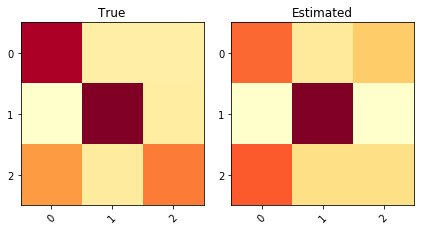

KL divergence: 0.5633	Pearson Correlation between diagonals: 0.9319


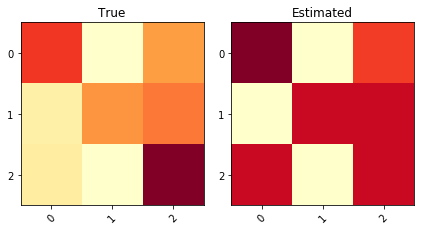

KL divergence: 0.5081	Pearson Correlation between diagonals: -0.1270


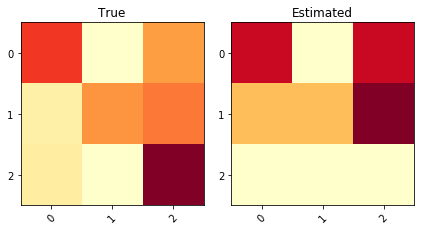

KL divergence: 0.3096	Pearson Correlation between diagonals: -0.5107


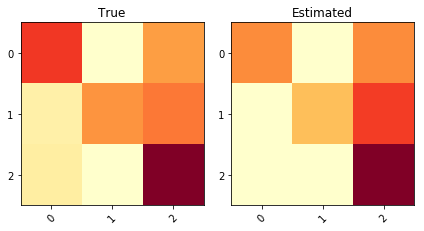

KL divergence: 0.8610	Pearson Correlation between diagonals: 0.9882


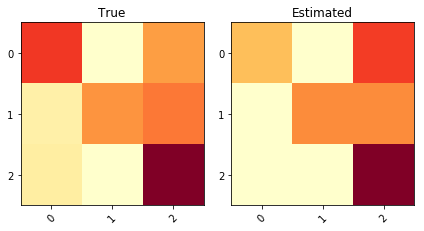

KL divergence: 0.8946	Pearson Correlation between diagonals: 0.8028


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


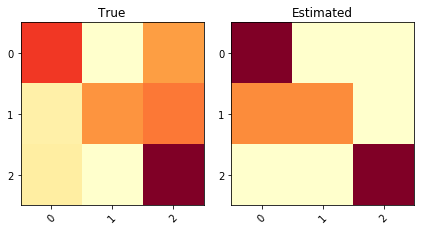

KL divergence: 4.7533	Pearson Correlation between diagonals: 0.7955


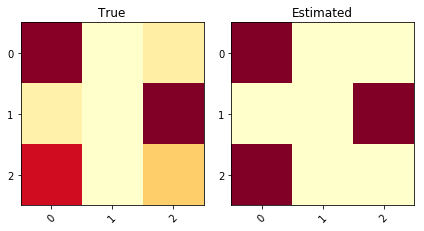

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


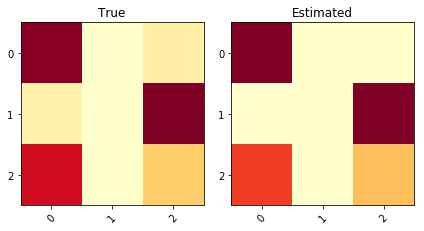

KL divergence: 0.8221	Pearson Correlation between diagonals: 0.9988


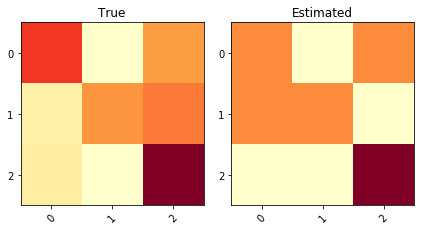

KL divergence: 2.8737	Pearson Correlation between diagonals: 0.9225


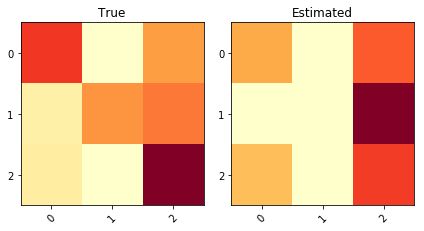

KL divergence: 2.5333	Pearson Correlation between diagonals: 0.9708


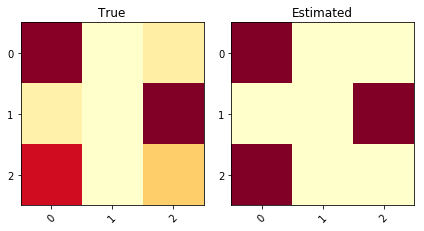

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


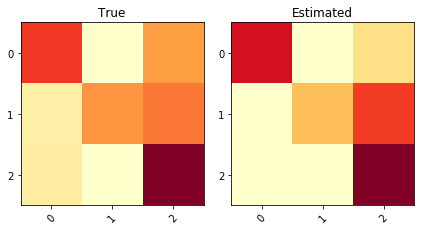

KL divergence: 0.8859	Pearson Correlation between diagonals: 0.9379
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.919007      0.919007    2.16296   0.126014                 nan
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.923077      0.923077
====  ======  ==========  ============


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: divide by zero encountered in double_scalars
  r = r_num / r_den


In [26]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


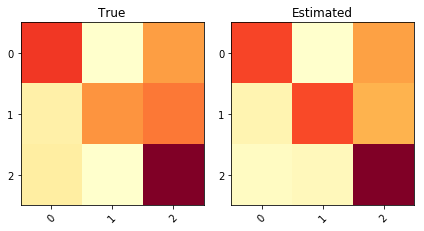

KL divergence: 0.1244	Pearson Correlation between diagonals: 0.9348


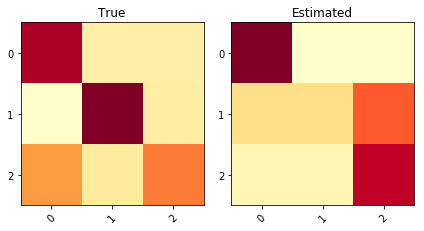

KL divergence: 0.3812	Pearson Correlation between diagonals: -0.5321


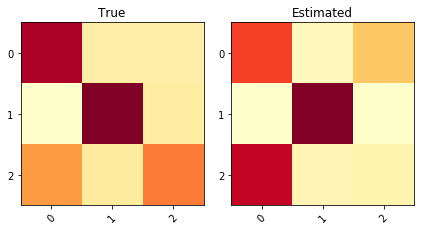

KL divergence: 0.2321	Pearson Correlation between diagonals: 0.9832


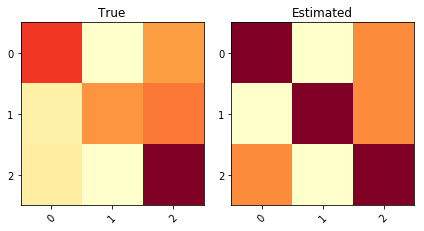

KL divergence: 0.2128	Pearson Correlation between diagonals: -0.7955


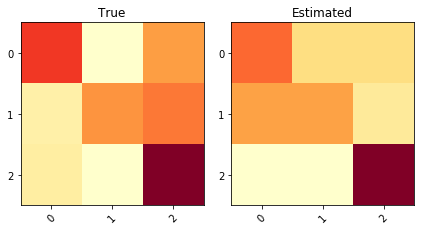

KL divergence: 0.2400	Pearson Correlation between diagonals: 0.9882


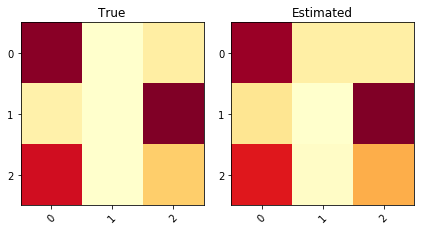

KL divergence: 0.1781	Pearson Correlation between diagonals: 0.9906


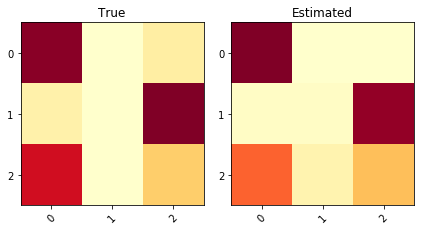

KL divergence: 0.1649	Pearson Correlation between diagonals: 0.9995


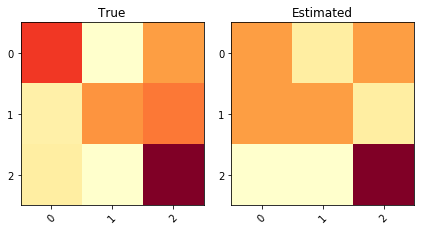

KL divergence: 0.2350	Pearson Correlation between diagonals: 0.9225


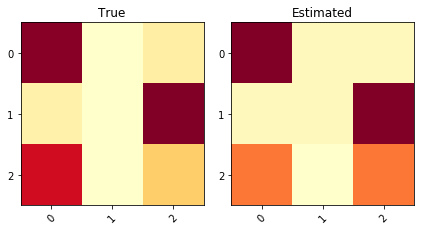

KL divergence: 0.2407	Pearson Correlation between diagonals: 0.9648


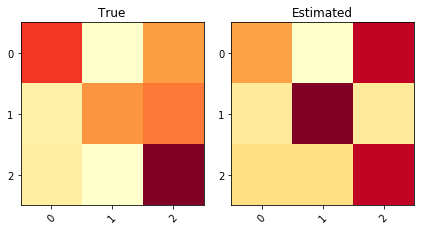

KL divergence: 0.2937	Pearson Correlation between diagonals: -0.1149


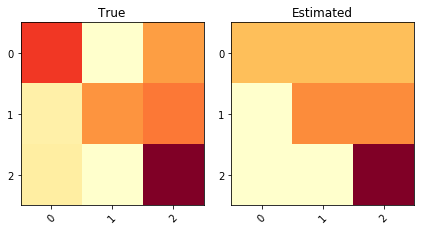

KL divergence: 0.3143	Pearson Correlation between diagonals: 0.8028


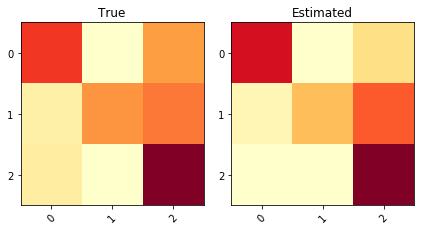

KL divergence: 0.1106	Pearson Correlation between diagonals: 0.9379


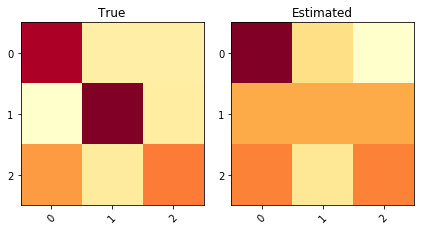

KL divergence: 0.2829	Pearson Correlation between diagonals: 0.1394


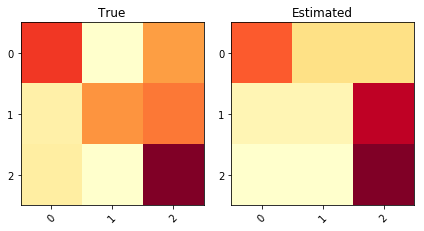

KL divergence: 0.2072	Pearson Correlation between diagonals: 0.9781


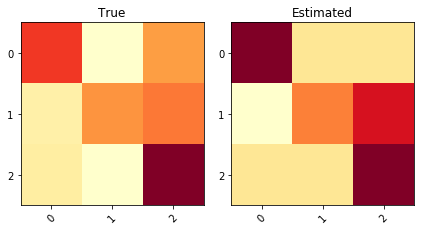

KL divergence: 0.1902	Pearson Correlation between diagonals: 0.7955


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.664225      0.664225   0.236415  0.0692318                 nan        0.192318
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.671692                0.854101
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.680098      0.680098
====  ======  ==========  ============


In [27]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


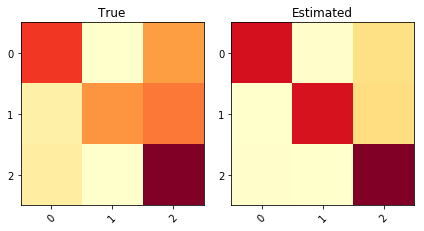

KL divergence: 0.2838	Pearson Correlation between diagonals: 0.9304


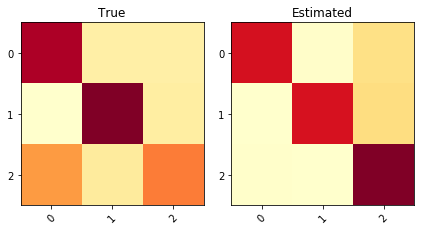

KL divergence: 0.6732	Pearson Correlation between diagonals: -0.9841


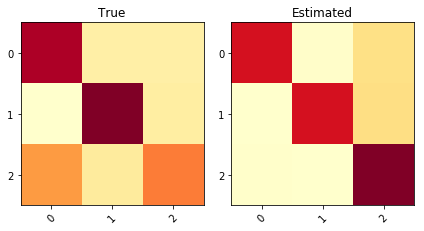

KL divergence: 0.6672	Pearson Correlation between diagonals: -0.9815


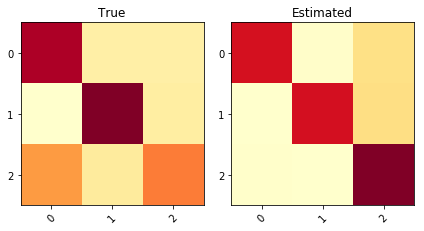

KL divergence: 0.6644	Pearson Correlation between diagonals: -0.9802


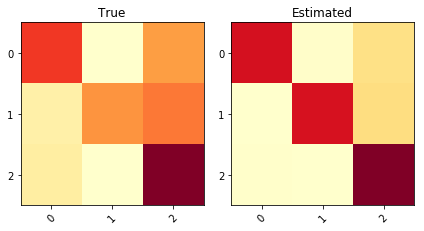

KL divergence: 0.2848	Pearson Correlation between diagonals: 0.9282


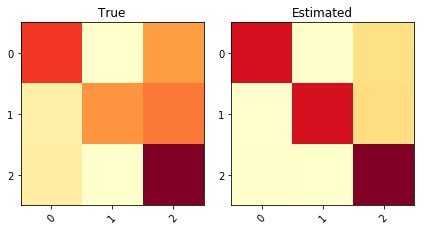

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9296


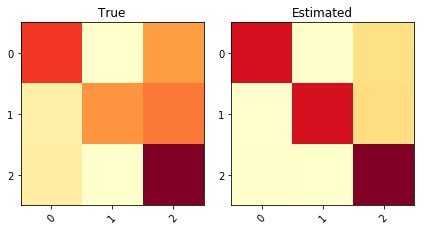

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9289


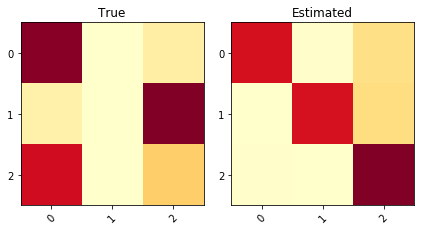

KL divergence: 1.6128	Pearson Correlation between diagonals: -0.2187


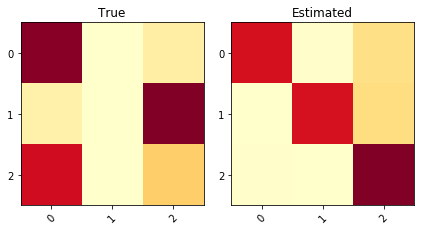

KL divergence: 1.6123	Pearson Correlation between diagonals: -0.2162


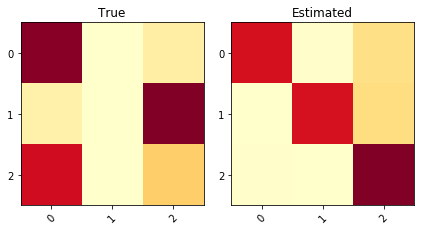

KL divergence: 1.6127	Pearson Correlation between diagonals: -0.2189


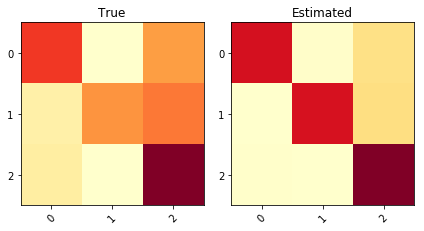

KL divergence: 0.2853	Pearson Correlation between diagonals: 0.9271


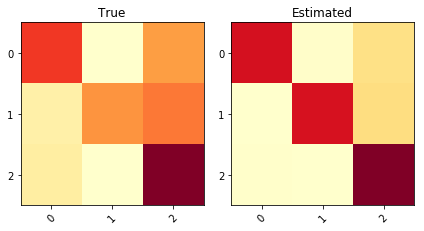

KL divergence: 0.2846	Pearson Correlation between diagonals: 0.9289


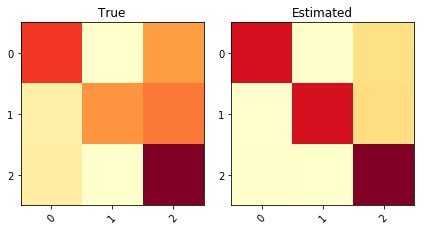

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9297


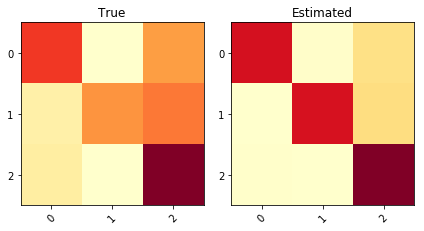

KL divergence: 0.2850	Pearson Correlation between diagonals: 0.9281


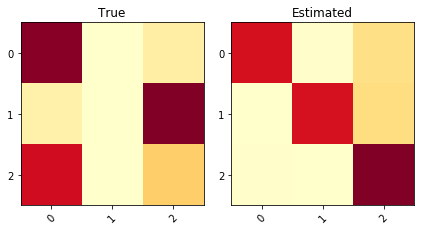

KL divergence: 1.6136	Pearson Correlation between diagonals: -0.2210
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.901099      0.901099   0.634778  0.0958811            0.227621        0.196777
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.601578                  0.8074
====  =======================  ======================
Test


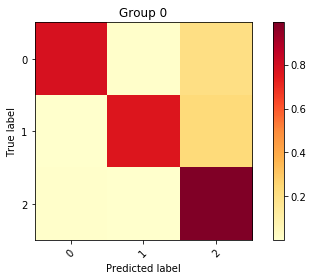

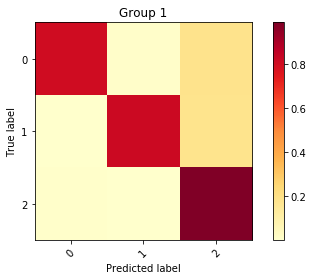

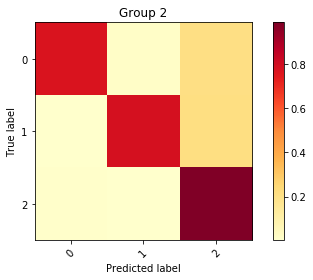

Inertia: 0.0006941696677434569
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.509769    5097   0.383405     0.847461   0.172483       0.91685    0.514128    0.664225      0.664225
   1         1  0.293071    2930   0.358103     0.871508   0.142037       0.931042   0.538174    0.714286      0.714286
   2         2  0.19716     1971   0.39276      0.850331   0.168667       0.918604   0.516998    0.684982      0.684982
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =====

In [28]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


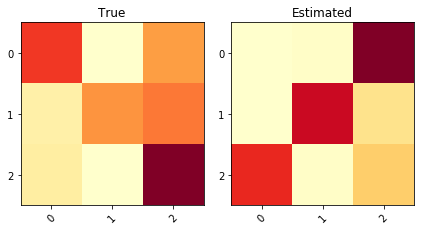

KL divergence: 1.7661	Pearson Correlation between diagonals: -0.5460


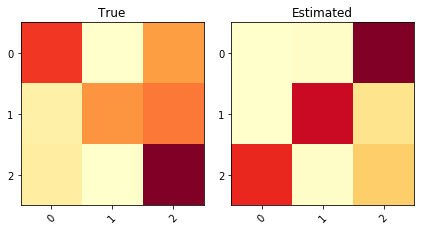

KL divergence: 1.7643	Pearson Correlation between diagonals: -0.5443


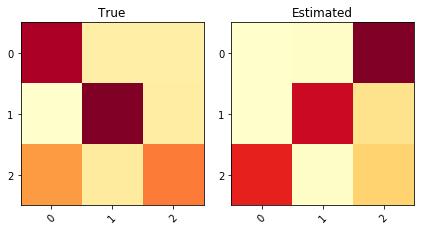

KL divergence: 2.0180	Pearson Correlation between diagonals: 0.3831


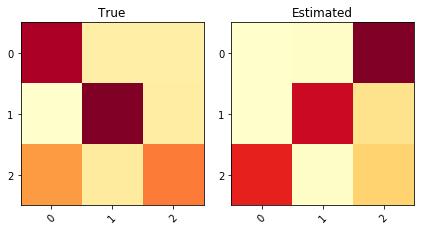

KL divergence: 2.0076	Pearson Correlation between diagonals: 0.3859


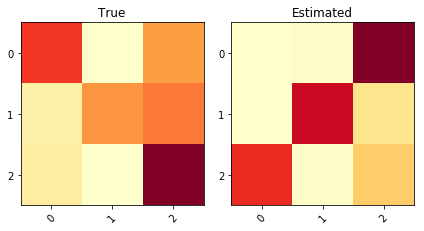

KL divergence: 1.7616	Pearson Correlation between diagonals: -0.5425


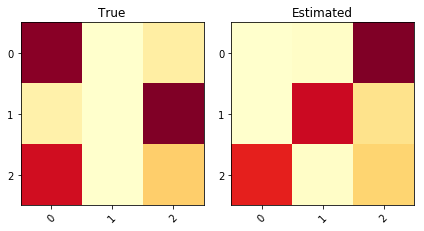

KL divergence: 2.7140	Pearson Correlation between diagonals: -0.9029


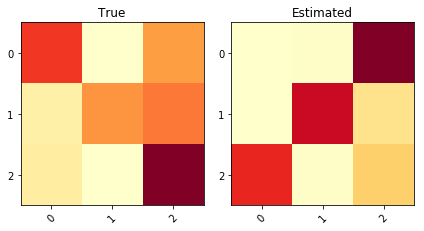

KL divergence: 1.7675	Pearson Correlation between diagonals: -0.5492


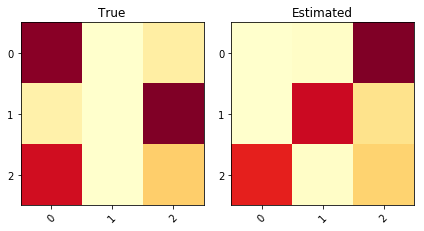

KL divergence: 2.7136	Pearson Correlation between diagonals: -0.9038


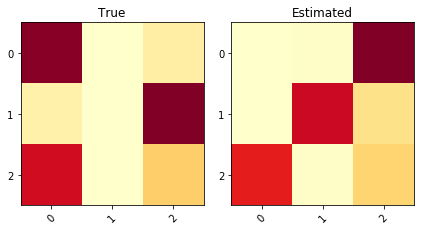

KL divergence: 2.7124	Pearson Correlation between diagonals: -0.9016


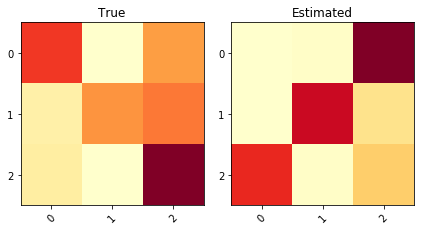

KL divergence: 1.7652	Pearson Correlation between diagonals: -0.5463


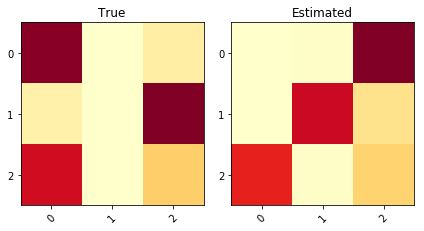

KL divergence: 2.7155	Pearson Correlation between diagonals: -0.9054


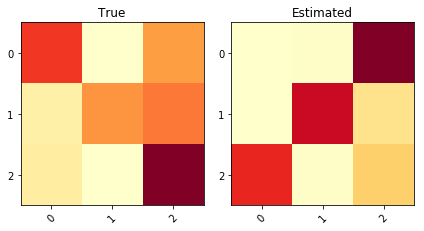

KL divergence: 1.7660	Pearson Correlation between diagonals: -0.5481


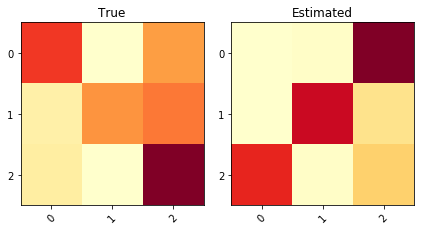

KL divergence: 1.7699	Pearson Correlation between diagonals: -0.5533


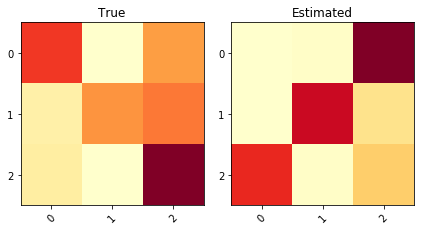

KL divergence: 1.7627	Pearson Correlation between diagonals: -0.5449


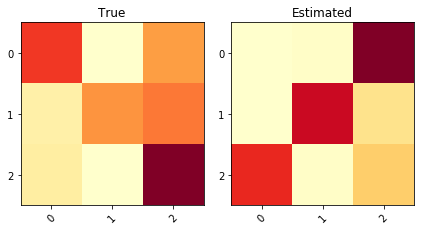

KL divergence: 1.7651	Pearson Correlation between diagonals: -0.5449
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.37851       0.37851    2.01078   0.219762            -0.38238        0.203455
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.599939                0.803456
====  =======================  ======================
Test


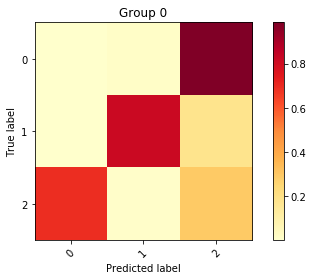

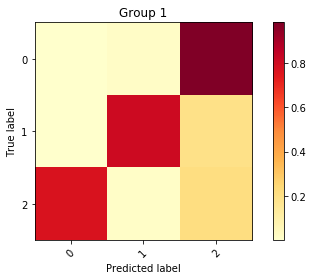

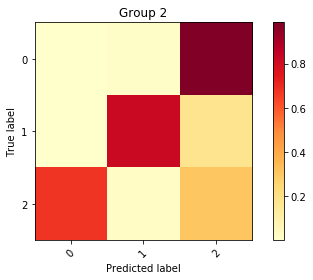

Inertia: 0.001275528554591195
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.502056    5020   0.402793     0.372082    3.05296       0.469439  0.0387491     0.67033       0.67033
   1         1  0.309751    3097   0.393764     0.340686    3.00726       0.436325  0.00735291    0.65812       0.65812
   2         2  0.188194    1881   0.417051     0.376822    2.72234       0.474936  0.0434882     0.671551      0.671551
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =

In [29]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


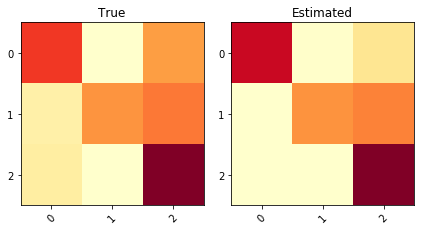

KL divergence: 0.3000	Pearson Correlation between diagonals: 0.9456


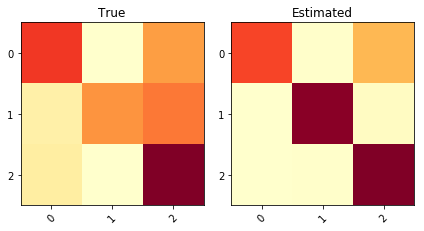

KL divergence: 0.6403	Pearson Correlation between diagonals: 0.1814


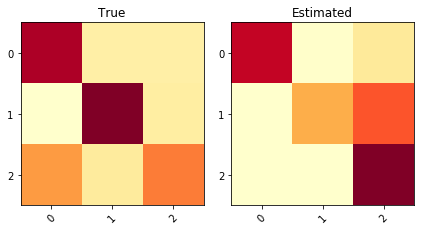

KL divergence: 1.0947	Pearson Correlation between diagonals: -0.8114


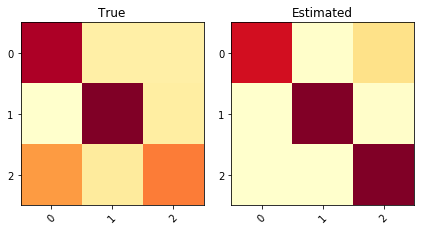

KL divergence: 0.9645	Pearson Correlation between diagonals: -0.3444


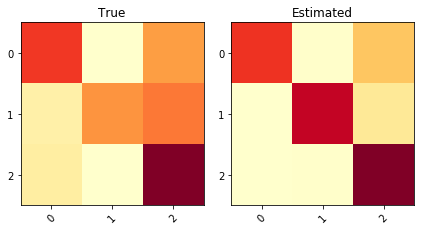

KL divergence: 0.3904	Pearson Correlation between diagonals: 0.5782


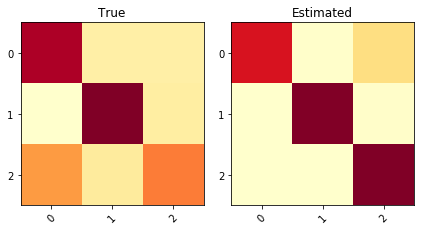

KL divergence: 0.9624	Pearson Correlation between diagonals: -0.3479


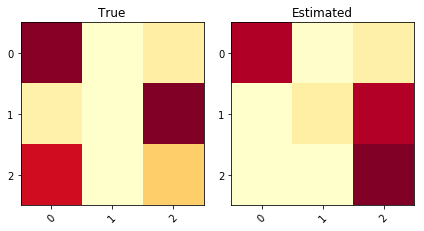

KL divergence: 1.6561	Pearson Correlation between diagonals: 0.6454


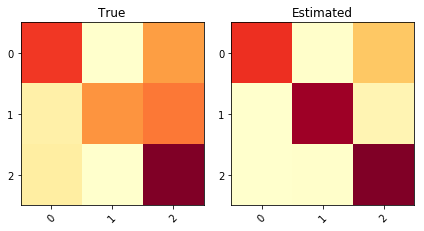

KL divergence: 0.5018	Pearson Correlation between diagonals: 0.3255


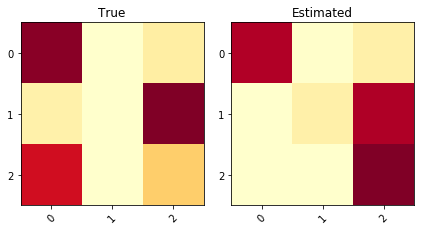

KL divergence: 1.6526	Pearson Correlation between diagonals: 0.6467


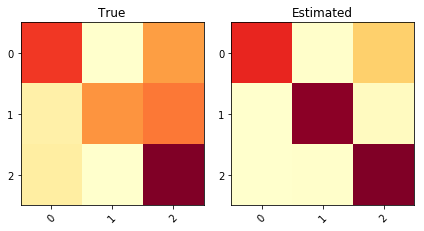

KL divergence: 0.6241	Pearson Correlation between diagonals: 0.2131


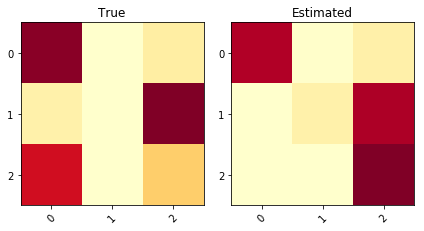

KL divergence: 1.6515	Pearson Correlation between diagonals: 0.6472


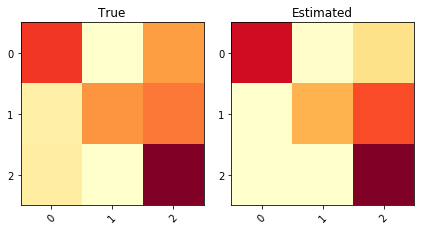

KL divergence: 0.2942	Pearson Correlation between diagonals: 0.9384


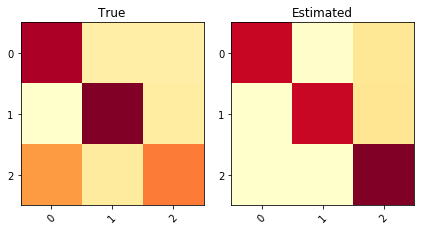

KL divergence: 0.9107	Pearson Correlation between diagonals: -0.9864


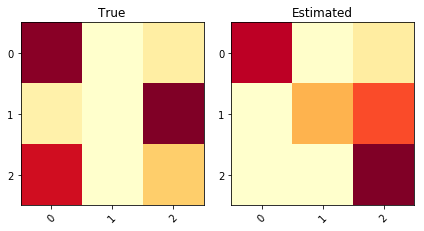

KL divergence: 1.7711	Pearson Correlation between diagonals: 0.5764


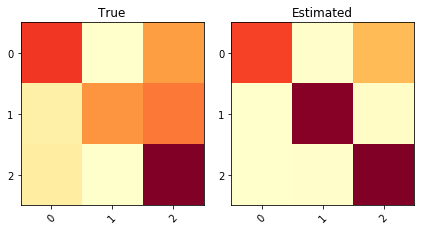

KL divergence: 0.6711	Pearson Correlation between diagonals: 0.1696
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.907611      0.907611   0.848521  0.0904263            0.280585        0.132795
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.686325                 0.70996
====  =======================  ======================
Test


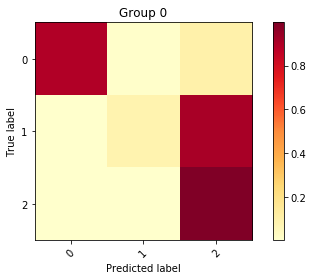

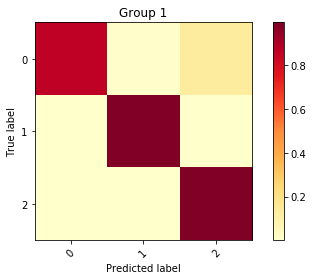

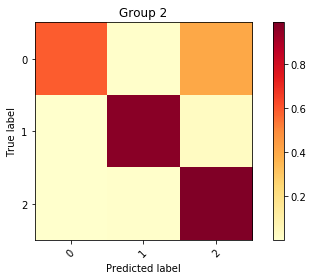

Inertia: 0.12640946141133705
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.264497    2644   0.225875     0.659369   0.859221       0.719837   0.326036    0.649573      0.649573
   1         1  0.333126    3331   0.158492     0.952061   0.051349       0.974832   0.618728    0.932845      0.932845
   2         2  0.402377    4023   0.297036     0.851143   0.187797       0.912793   0.51781     0.881563      0.881563
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [30]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 7) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [45]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6109076109076109


*** Raykar model multiples runs***
Train


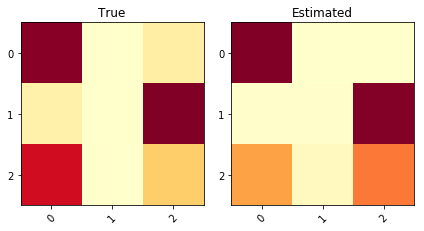

KL divergence: 0.1462	Pearson Correlation between diagonals: 0.9604


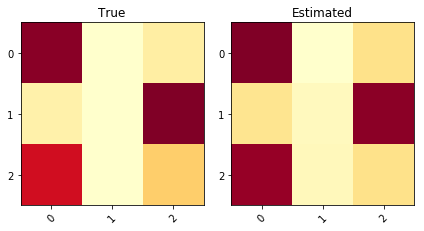

KL divergence: 0.1178	Pearson Correlation between diagonals: 0.9904


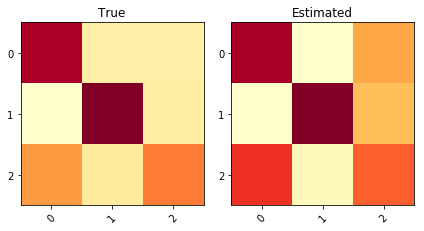

KL divergence: 0.1056	Pearson Correlation between diagonals: 1.0000


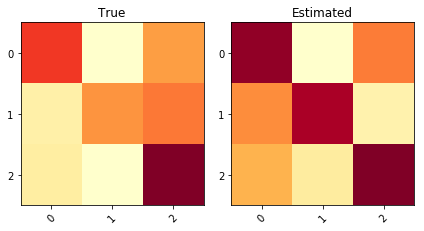

KL divergence: 0.2678	Pearson Correlation between diagonals: 0.9787


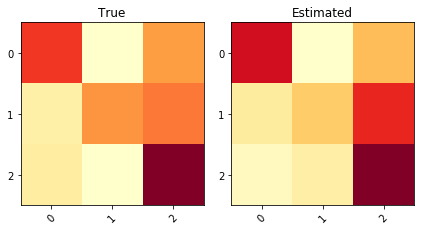

KL divergence: 0.1204	Pearson Correlation between diagonals: 0.9274


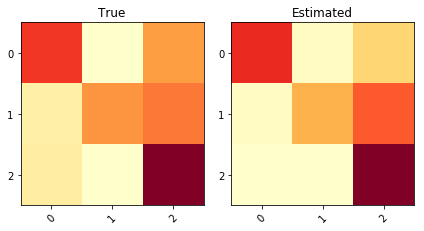

KL divergence: 0.1062	Pearson Correlation between diagonals: 0.9840


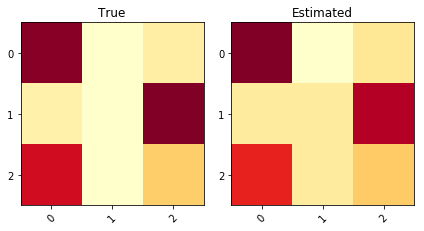

KL divergence: 0.1787	Pearson Correlation between diagonals: 0.9937


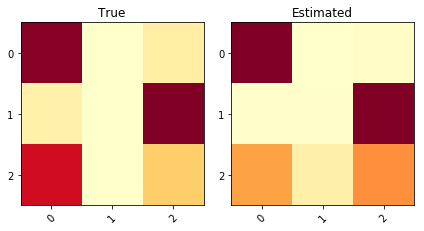

KL divergence: 0.1700	Pearson Correlation between diagonals: 0.9740


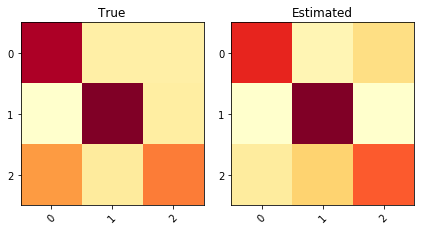

KL divergence: 0.1089	Pearson Correlation between diagonals: 0.8531


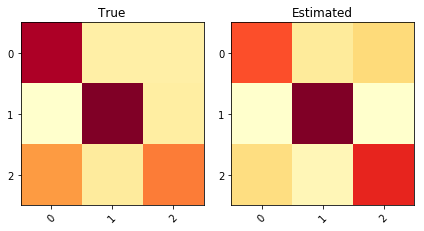

KL divergence: 0.0981	Pearson Correlation between diagonals: 0.4354


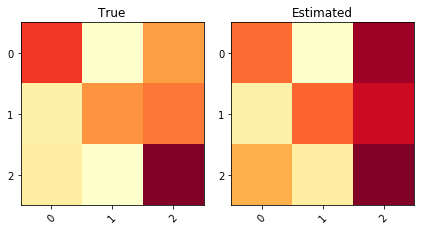

KL divergence: 0.1477	Pearson Correlation between diagonals: 0.9100


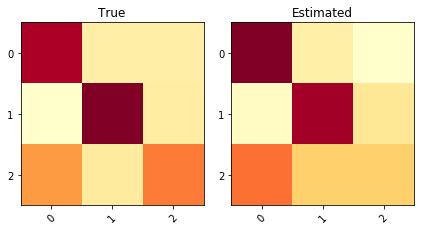

KL divergence: 0.0876	Pearson Correlation between diagonals: 0.9600


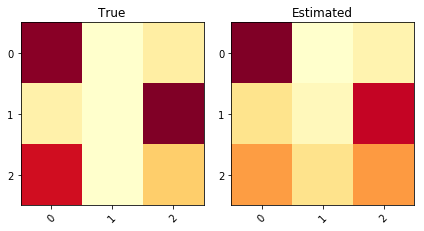

KL divergence: 0.1971	Pearson Correlation between diagonals: 0.9882


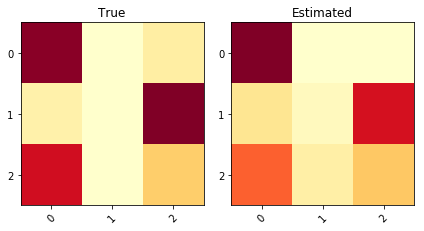

KL divergence: 0.1480	Pearson Correlation between diagonals: 0.9999


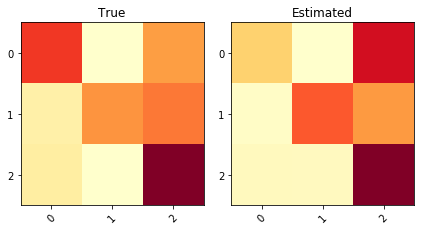

KL divergence: 0.1825	Pearson Correlation between diagonals: 0.6475
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.844933      0.844933   0.142337  0.0423729            0.865889        0.191244
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.664699                0.779589
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.849817 

In [46]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


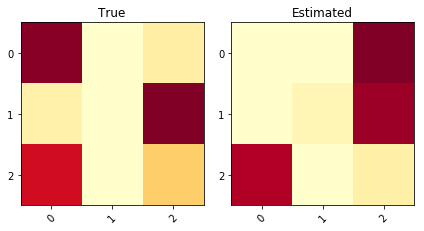

KL divergence: 1.6154	Pearson Correlation between diagonals: -0.7842


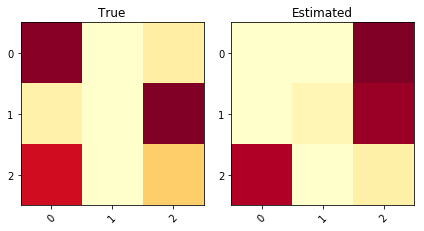

KL divergence: 1.6139	Pearson Correlation between diagonals: -0.7606


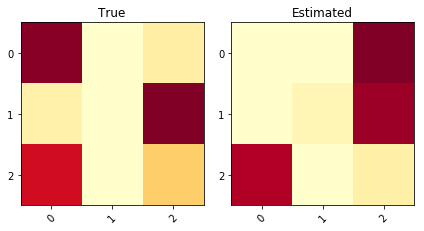

KL divergence: 1.6144	Pearson Correlation between diagonals: -0.7690


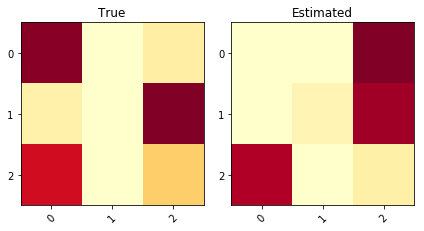

KL divergence: 1.6183	Pearson Correlation between diagonals: -0.8242


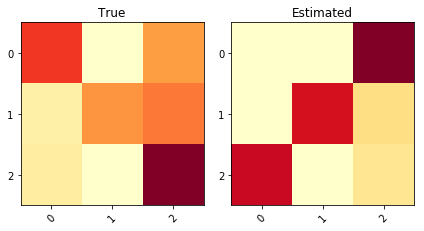

KL divergence: 1.5787	Pearson Correlation between diagonals: -0.6632


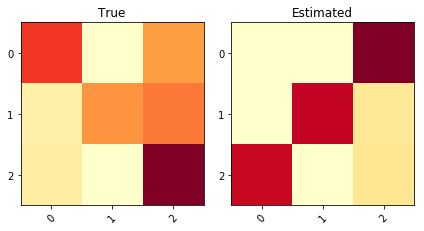

KL divergence: 1.6217	Pearson Correlation between diagonals: -0.6712


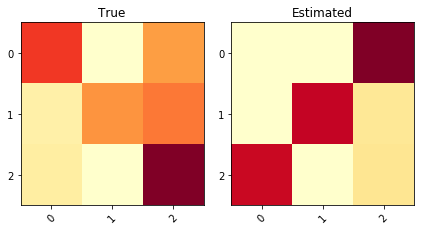

KL divergence: 1.6170	Pearson Correlation between diagonals: -0.6711


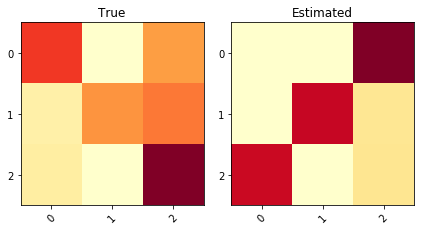

KL divergence: 1.6128	Pearson Correlation between diagonals: -0.6679


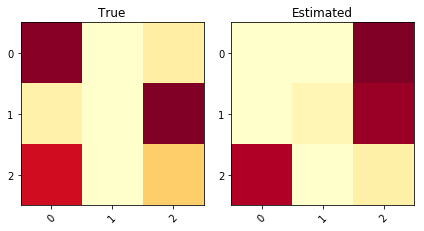

KL divergence: 1.6141	Pearson Correlation between diagonals: -0.7641


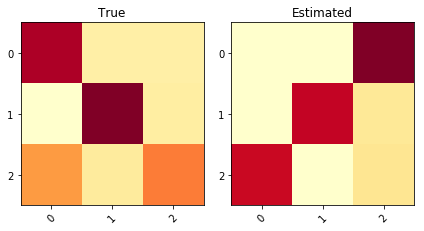

KL divergence: 1.7664	Pearson Correlation between diagonals: 0.5091


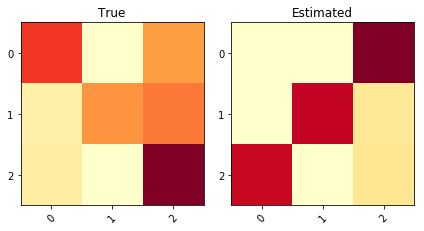

KL divergence: 1.6221	Pearson Correlation between diagonals: -0.6708


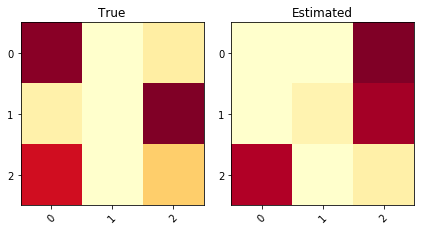

KL divergence: 1.6222	Pearson Correlation between diagonals: -0.8711


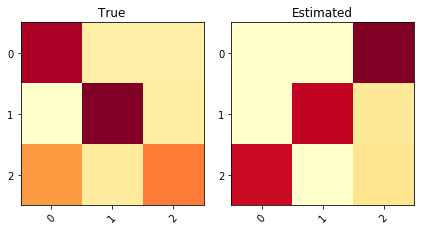

KL divergence: 1.7769	Pearson Correlation between diagonals: 0.5066


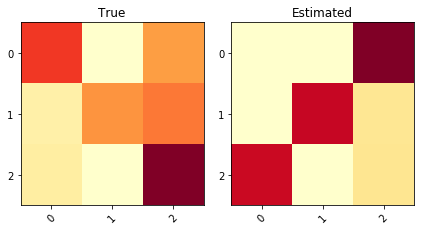

KL divergence: 1.6139	Pearson Correlation between diagonals: -0.6680


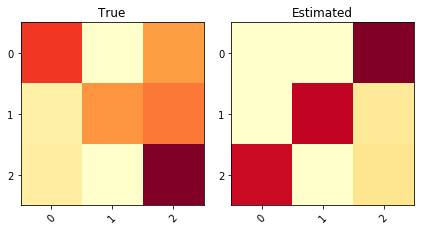

KL divergence: 1.6323	Pearson Correlation between diagonals: -0.6684
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.590151      0.590151     1.6541   0.208095             -0.4274        0.207612
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.650031                0.712605
====  =======================  ======================
Test


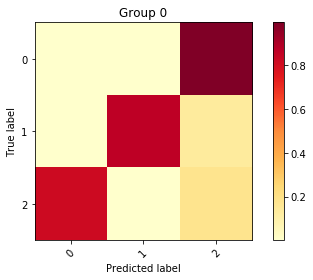

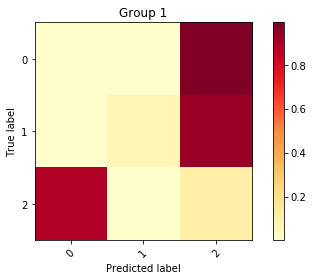

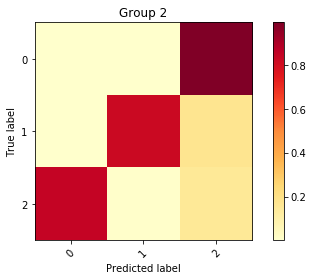

Inertia: 0.08025133436118874
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)      Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
   0         0  0.418226     836   0.310541    0.347827     2.63233       0.433638   0.0144936     0.778999      0.778999
   1         1  0.29645      592   0.21926     0.0575475    3.43965       0.148335  -0.275786      0.582418      0.582418
   2         2  0.285324     570   0.323744    0.326803     2.58821       0.415255  -0.00653005    0.691087      0.691087
====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  =====

In [47]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


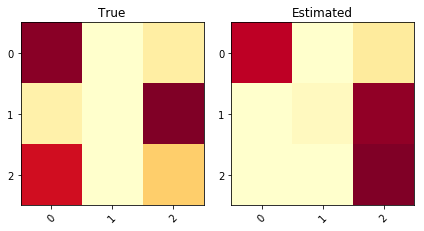

KL divergence: 1.3676	Pearson Correlation between diagonals: 0.6320


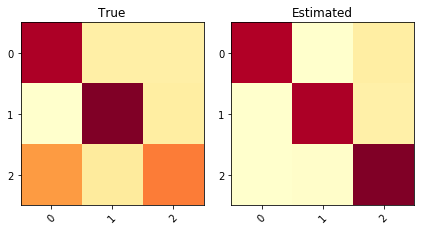

KL divergence: 0.8154	Pearson Correlation between diagonals: -0.9639


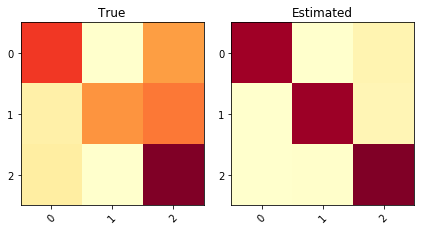

KL divergence: 0.5790	Pearson Correlation between diagonals: 0.8689


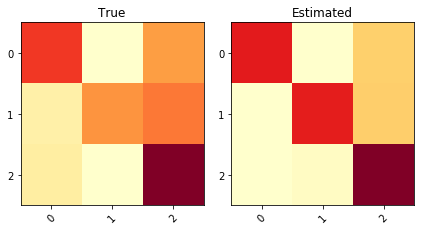

KL divergence: 0.2375	Pearson Correlation between diagonals: 0.9320


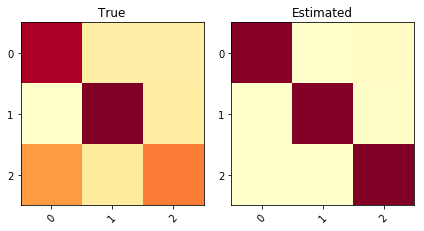

KL divergence: 0.9742	Pearson Correlation between diagonals: -0.8043


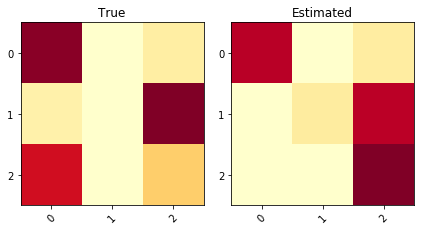

KL divergence: 1.4065	Pearson Correlation between diagonals: 0.6303


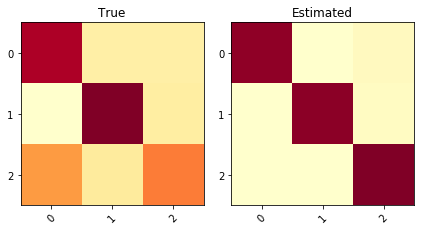

KL divergence: 0.9224	Pearson Correlation between diagonals: -0.8978


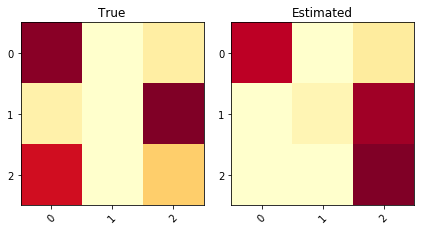

KL divergence: 1.3811	Pearson Correlation between diagonals: 0.6315


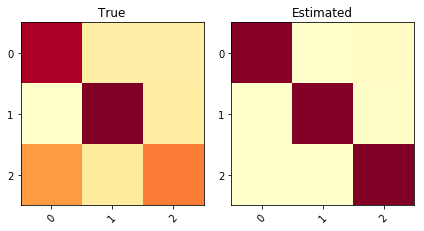

KL divergence: 0.9761	Pearson Correlation between diagonals: -0.7994


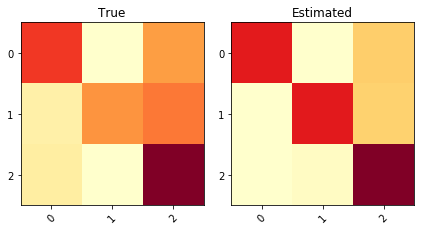

KL divergence: 0.2415	Pearson Correlation between diagonals: 0.9129


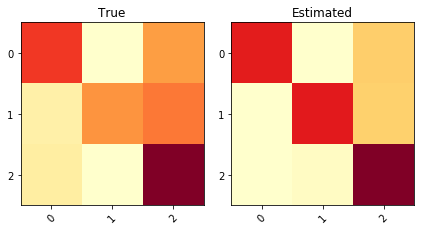

KL divergence: 0.2408	Pearson Correlation between diagonals: 0.9129


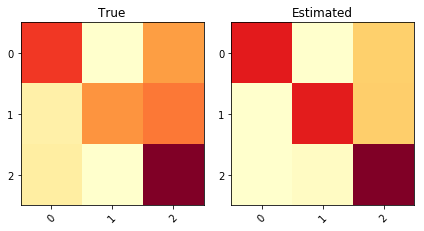

KL divergence: 0.2385	Pearson Correlation between diagonals: 0.9300


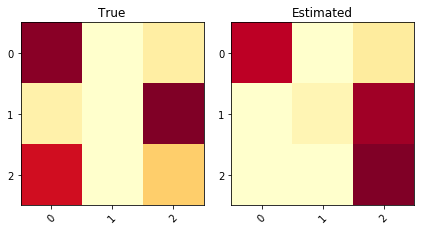

KL divergence: 1.3808	Pearson Correlation between diagonals: 0.6314


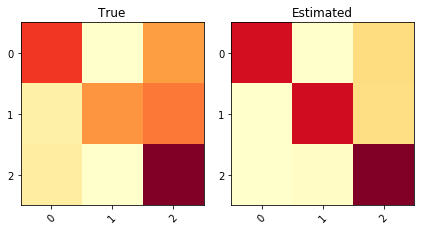

KL divergence: 0.2937	Pearson Correlation between diagonals: 0.9089


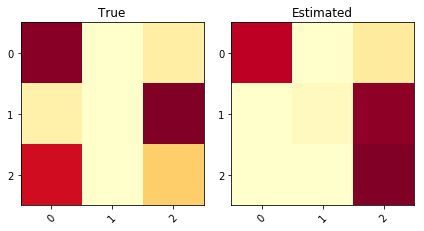

KL divergence: 1.3671	Pearson Correlation between diagonals: 0.6323
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.707367      0.707367   0.884005  0.0927332            0.357758        0.189364
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.672436                0.691652
====  =======================  ======================
Test


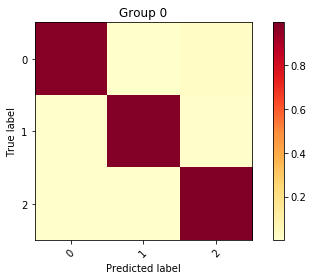

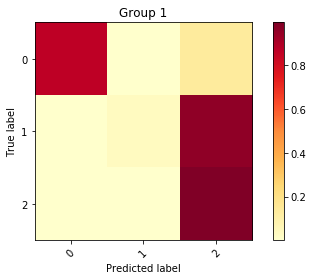

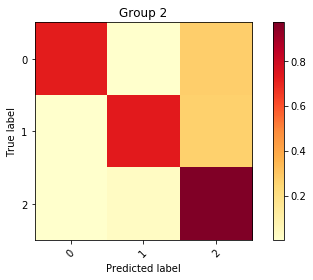

Inertia: 0.12115698804457982
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.400611     801  0.0703142     0.986921  0.0131917       0.993421   0.653588    0.737485      0.737485
   1         1  0.3475       695  0.200584      0.6322    1.16958         0.679036   0.298866    0.614164      0.614164
   2         2  0.251888     503  0.444244      0.808608  0.221968        0.893873   0.475275    0.652015      0.652015
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [48]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


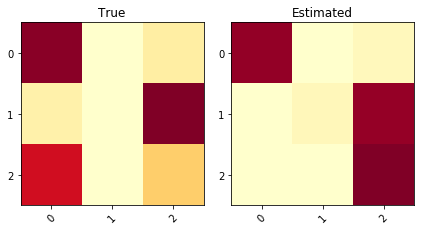

KL divergence: 1.3036	Pearson Correlation between diagonals: 0.6954


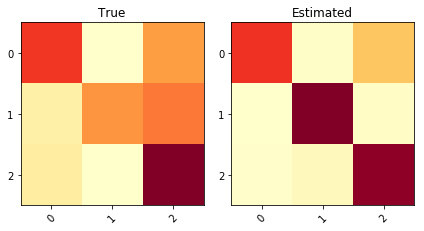

KL divergence: 0.6090	Pearson Correlation between diagonals: 0.0243


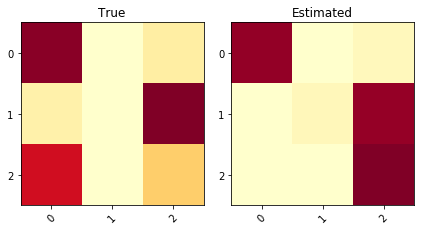

KL divergence: 1.3036	Pearson Correlation between diagonals: 0.6954


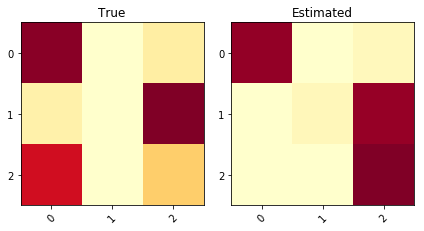

KL divergence: 1.3036	Pearson Correlation between diagonals: 0.6954


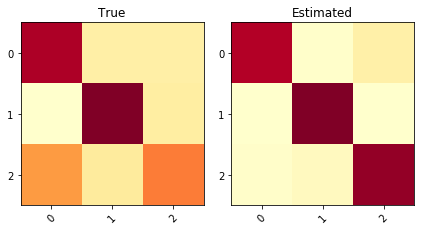

KL divergence: 0.5741	Pearson Correlation between diagonals: 0.0633


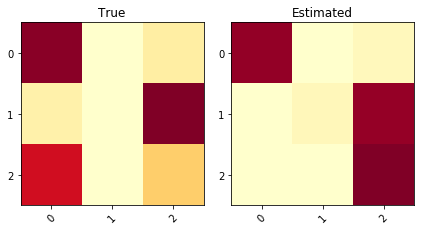

KL divergence: 1.3036	Pearson Correlation between diagonals: 0.6954


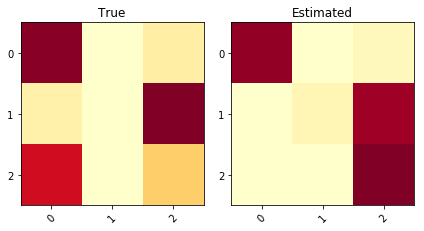

KL divergence: 1.3032	Pearson Correlation between diagonals: 0.6955


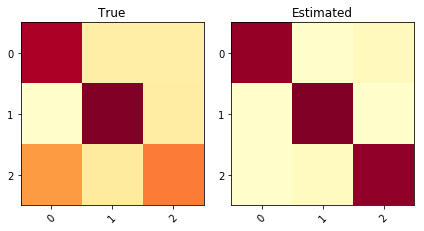

KL divergence: 0.5992	Pearson Correlation between diagonals: 0.5722


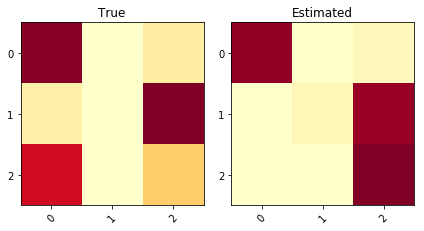

KL divergence: 1.3034	Pearson Correlation between diagonals: 0.6954


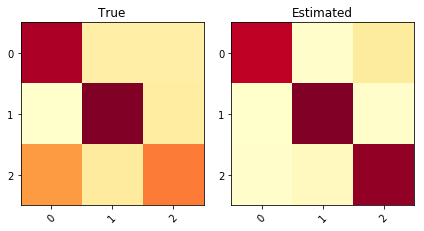

KL divergence: 0.5696	Pearson Correlation between diagonals: -0.0236


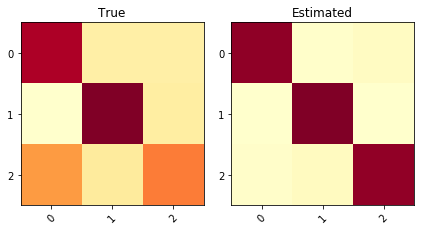

KL divergence: 0.6098	Pearson Correlation between diagonals: 0.7693


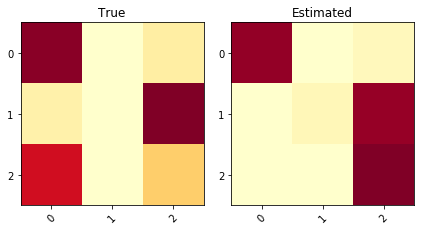

KL divergence: 1.3035	Pearson Correlation between diagonals: 0.6954


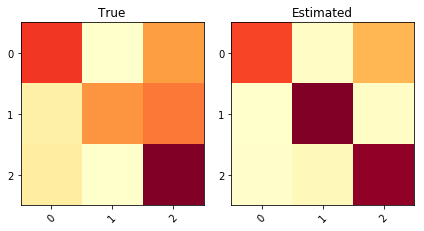

KL divergence: 0.5952	Pearson Correlation between diagonals: 0.0364


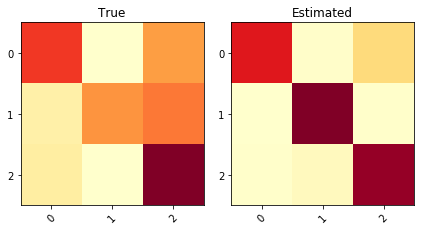

KL divergence: 0.8121	Pearson Correlation between diagonals: -0.0511


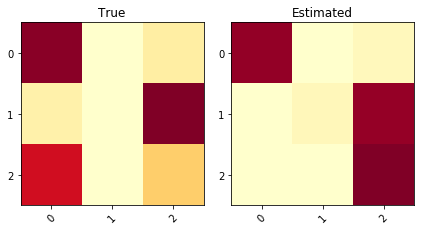

KL divergence: 1.3036	Pearson Correlation between diagonals: 0.6954
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.770045      0.770045   0.898164   0.106019            0.426751        0.180023
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.689687                0.675659
====  =======================  ======================
Test


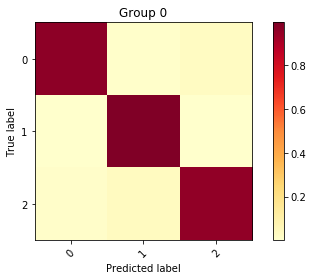

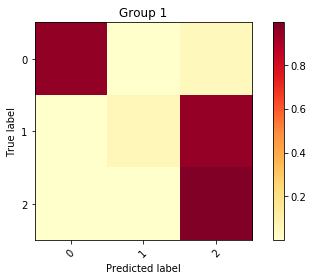

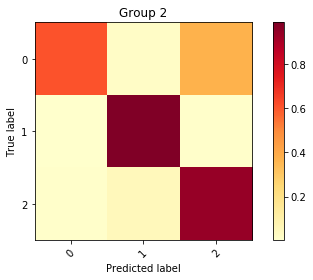

Inertia: 0.15224367969979843
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.399603     799   0.130819     0.972908  0.0276044       0.986271   0.639575    0.799756      0.799756
   1         1  0.415601     831   0.154681     0.665453  1.00453         0.707029   0.33212     0.586081      0.586081
   2         2  0.184796     369   0.348423     0.847717  0.187415        0.912246   0.514384    0.879121      0.879121
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [51]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

## Variation $M$ = #Groups
---

In [11]:
from code.evaluation import Evaluation_metrics

logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence_Mchange = [] #KL or JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(1,11):
    gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture3.lambda_random = True #with lambda random --necessary
    logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)
    print("Model with %d trained"%(M_seted))
    logL_Mchange.append(logL_hists[i_r])
    probas_Mchange.append(gMixture3.get_alpha())
    
    #measure metrics..
    evaluate = Evaluation_metrics(gMixture3,'our1',plot=False) 
    aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
    predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
    Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
    results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
    
    accTR_Mchange.append(results1[0]["Accuracy"][0])
    divergence_Mchange.append(results1[0]["Mean KL"][0])
    probGt_Mchange.append(prob_Gt)

    c_M = gMixture3.get_confusionM()
    y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
    Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
    results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

    best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
    accTE_Mchange.append(results2[1]["Accuracy"][0])
    inertia_Mchange.append(evaluate.inertia)
    
    del gMixture3
    gc.collect()

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.021736 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.00062985]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.79 sec)	logL: -26165.166	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25100.290	Tol1: 0.04070	Tol2: 0.71215	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24232.001	Tol1: 0.03459	Tol2: 0.42797	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23493.693	Tol1: 0.03047	Tol2: 0.29893	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22872.544	Tol1: 0.02644	Tol2: 0.21367	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22353.828	Tol1: 0.02268	Tol2: 0.15059	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21929.731	Tol1: 0.0

M step: done,  E step: done //  (in 0.09 sec)	logL: -20881.255	Tol1: 0.00279	Tol2: 0.04246	Tol3: 0.00000	
Iter 32/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20826.214	Tol1: 0.00264	Tol2: 0.04056	Tol3: 0.00000	
Iter 33/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20780.565	Tol1: 0.00219	Tol2: 0.03866	Tol3: 0.00000	
Iter 34/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20733.219	Tol1: 0.00228	Tol2: 0.03398	Tol3: 0.00000	
Iter 35/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20694.049	Tol1: 0.00189	Tol2: 0.03196	Tol3: 0.00000	
Iter 36/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20649.539	Tol1: 0.00215	Tol2: 0.02867	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34549984]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.15 sec)	logL: -23526.176	
Iter 2/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.10 sec)	logL: -20916.839	Tol1: 0.00593	Tol2: 0.04408	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20786.794	Tol1: 0.00622	Tol2: 0.04422	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20666.458	Tol1: 0.00579	Tol2: 0.04894	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20551.592	Tol1: 0.00556	Tol2: 0.05166	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20445.058	Tol1: 0.00518	Tol2: 0.05264	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20355.237	Tol1: 0.00439	Tol2: 0.05187	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20273.934	Tol1: 0.00399	Tol2: 0.05025	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20203.230	Tol1: 0.00349	Tol2: 0.04858	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20146.913	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -21233.972	Tol1: 0.01088	Tol2: 0.11094	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21030.691	Tol1: 0.00957	Tol2: 0.10413	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20858.148	Tol1: 0.00820	Tol2: 0.09292	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20703.913	Tol1: 0.00739	Tol2: 0.07871	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20573.641	Tol1: 0.00629	Tol2: 0.06913	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20464.346	Tol1: 0.00531	Tol2: 0.06917	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20365.290	Tol1: 0.00484	Tol2: 0.06601	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20282.474	Tol1: 0.00407	Tol2: 0.06246	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20207.293	T

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.062449 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.24524057 0.10244897]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -27515.292	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25976.377	Tol1: 0.05593	Tol2: 0.49952	Tol3: 0.04257	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25036.270	Tol1: 0.03619	Tol2: 0.28194	Tol3: 0.02430	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24540.697	Tol1: 0.01979	Tol2: 0.13376	Tol3: 0.01607	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24229.136	Tol1: 0.01270	Tol2: 0.05141	Tol3: 0.01062	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23977.183	Tol1: 0.01040	Tol2: 0.04278	Tol3: 0.00764	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23750.84

M step: done,  E step: done //  (in 0.12 sec)	logL: -20065.029	Tol1: 0.00178	Tol2: 0.04253	Tol3: 0.00221	
Iter 38/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20033.620	Tol1: 0.00157	Tol2: 0.03993	Tol3: 0.00199	
Iter 39/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20007.603	Tol1: 0.00130	Tol2: 0.03746	Tol3: 0.00165	
Iter 40/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19980.535	Tol1: 0.00135	Tol2: 0.03521	Tol3: 0.00140	
Iter 41/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19950.091	Tol1: 0.00152	Tol2: 0.03289	Tol3: 0.00078	
Iter 42/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19928.000	Tol1: 0.00111	Tol2: 0.03202	Tol3: 0.00111	
Iter 43/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19910.483	Tol1: 0.00088	Tol2: 0.02941	Tol3: 0.00055	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.54806936 0.4345587 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (245

M step: done,  E step: done //  (in 0.11 sec)	logL: -21305.490	Tol1: 0.00926	Tol2: 0.08230	Tol3: 0.00272	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21132.408	Tol1: 0.00812	Tol2: 0.06839	Tol3: 0.00251	
Iter 20/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20996.787	Tol1: 0.00642	Tol2: 0.05830	Tol3: 0.00222	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20891.335	Tol1: 0.00502	Tol2: 0.05198	Tol3: 0.00215	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20804.774	Tol1: 0.00414	Tol2: 0.04991	Tol3: 0.00217	
Iter 23/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20731.323	Tol1: 0.00353	Tol2: 0.05130	Tol3: 0.00186	
Iter 24/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20673.589	Tol1: 0.00278	Tol2: 0.05315	Tol3: 0.00175	
Iter 25/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20628.210	Tol1: 0.00220	Tol2: 0.05371	Tol3: 0.00204	
Iter 26/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20581.511	T

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.89343697 0.9677506 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.33 sec)	logL: -24967.007	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24410.429	Tol1: 0.02229	Tol2: 0.17350	Tol3: 0.02475	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24013.819	Tol1: 0.01625	Tol2: 0.09733	Tol3: 0.00545	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23627.400	Tol1: 0.01609	Tol2: 0.09164	Tol3: 0.01012	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23234.239	Tol1: 0.01664	Tol2: 0.10055	Tol3: 0.01392	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22822.628	Tol1: 0.01772	Tol2: 0.11557	Tol3: 0.01682	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22426.203	Tol1: 0.01737	Tol2: 0.12632	Tol3: 0.01906	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22034

M step: done,  E step: done //  (in 0.15 sec)	logL: -20337.549	Tol1: 0.00120	Tol2: 0.06647	Tol3: 0.00331	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20316.288	Tol1: 0.00105	Tol2: 0.06357	Tol3: 0.00267	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20296.728	Tol1: 0.00096	Tol2: 0.05884	Tol3: 0.00248	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20276.885	Tol1: 0.00098	Tol2: 0.05420	Tol3: 0.00242	
Iter 27/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20257.486	Tol1: 0.00096	Tol2: 0.04944	Tol3: 0.00221	
Iter 28/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20236.629	Tol1: 0.00103	Tol2: 0.04603	Tol3: 0.00189	
Iter 29/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20218.615	Tol1: 0.00089	Tol2: 0.04411	Tol3: 0.00185	
Iter 30/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20202.393	Tol1: 0.00080	Tol2: 0.04031	Tol3: 0.00155	
Iter 31/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20180.050	T

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


 Done!
Lambda by group:  [0.24611324 0.13479637 0.19495107]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.12 sec)	logL: -25946.456	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24856.425	Tol1: 0.04201	Tol2: 0.37803	Tol3: 0.04852	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24349.415	Tol1: 0.02040	Tol2: 0.15815	Tol3: 0.02381	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24018.039	Tol1: 0.01361	Tol2: 0.07628	Tol3: 0.01397	
Iter 5/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23748.395	Tol1: 0.01123	Tol2: 0.05433	Tol3: 0.01142	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23492.750	Tol1: 0.01076	Tol2: 0.05595	Tol3: 0.01164	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23246.874	Tol1: 0.01047	Tol2: 0.06076	Tol3: 0.01229	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23030.623	Tol1: 0.00930	To

M step: done,  E step: done //  (in 0.11 sec)	logL: -20969.285	Tol1: 0.00132	Tol2: 0.03646	Tol3: 0.00262	
Iter 38/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20940.642	Tol1: 0.00137	Tol2: 0.03521	Tol3: 0.00292	
Iter 39/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20912.233	Tol1: 0.00136	Tol2: 0.03494	Tol3: 0.00333	
Iter 40/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20880.696	Tol1: 0.00151	Tol2: 0.03366	Tol3: 0.00408	
Iter 41/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20851.941	Tol1: 0.00138	Tol2: 0.03277	Tol3: 0.00450	
Iter 42/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20818.918	Tol1: 0.00158	Tol2: 0.03292	Tol3: 0.00485	
Iter 43/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20781.952	Tol1: 0.00178	Tol2: 0.03183	Tol3: 0.00546	
Iter 44/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20738.485	Tol1: 0.00209	Tol2: 0.03161	Tol3: 0.00611	
Iter 45/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20695.474	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -20664.082	Tol1: 0.00502	Tol2: 0.02745	Tol3: 0.00419	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.81090045 0.7371906  0.12390444]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.77 sec)	logL: -25791.512	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25018.568	Tol1: 0.02997	Tol2: 0.19705	Tol3: 0.04928	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24583.043	Tol1: 0.01741	Tol2: 0.07727	Tol3: 0.01739	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24209.618	Tol1: 0.01519	Tol2: 0.06325	Tol3: 0.01100	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23869.229	Tol1: 0.01406	Tol2: 0.06976	Tol3: 0.01019	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23563.464	Tol1: 0.01281	Tol2: 0.07557	Tol3: 0.01105	
Iter 7/50
M step: done,  

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5677524  0.47513008 0.5822768 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.72 sec)	logL: -31128.417	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -27872.429	Tol1: 0.10460	Tol2: 0.54222	Tol3: 0.01981	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26418.075	Tol1: 0.05218	Tol2: 0.24654	Tol3: 0.05695	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25529.641	Tol1: 0.03363	Tol2: 0.19181	Tol3: 0.05102	
Iter 5/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24952.327	Tol1: 0.02261	Tol2: 0.14694	Tol3: 0.04481	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24568.799	Tol1: 0.01537	Tol2: 0.12117	Tol3: 0.03682	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24293.327	Tol1: 0.01121	Tol2: 0.10406	Tol3: 0.02939	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	l

M step: done,  E step: done //  (in 0.12 sec)	logL: -23824.582	Tol1: 0.01741	Tol2: 0.06908	Tol3: 0.01308	
Iter 5/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23431.029	Tol1: 0.01652	Tol2: 0.06756	Tol3: 0.02048	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23047.534	Tol1: 0.01637	Tol2: 0.07975	Tol3: 0.02554	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22670.338	Tol1: 0.01637	Tol2: 0.08962	Tol3: 0.02861	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22303.678	Tol1: 0.01617	Tol2: 0.09594	Tol3: 0.02967	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21974.441	Tol1: 0.01476	Tol2: 0.09842	Tol3: 0.02934	
Iter 10/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21682.461	Tol1: 0.01329	Tol2: 0.09606	Tol3: 0.02748	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21435.099	Tol1: 0.01141	Tol2: 0.09092	Tol3: 0.02502	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21222.828	Tol1: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -20461.516	Tol1: 0.00363	Tol2: 0.03967	Tol3: 0.00756	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20396.820	Tol1: 0.00316	Tol2: 0.03300	Tol3: 0.00688	
Iter 25/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20329.986	Tol1: 0.00328	Tol2: 0.03011	Tol3: 0.00655	
Iter 26/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20281.541	Tol1: 0.00238	Tol2: 0.02711	Tol3: 0.00602	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22904612 0.5232919  0.3681046  0.44053462]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 7.82 sec)	logL: -27140.890	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24579.520	Tol1: 0.09437	Tol2: 0.57191	Tol3: 0.10877	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23938.368	Tol1: 0.02608	Tol2: 0.19958	Tol3: 0.03940	
Iter 4/50
M

M step: done,  E step: done //  (in 0.14 sec)	logL: -22676.718	Tol1: 0.01712	Tol2: 0.07521	Tol3: 0.01812	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22292.917	Tol1: 0.01692	Tol2: 0.08651	Tol3: 0.01943	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21930.651	Tol1: 0.01625	Tol2: 0.09450	Tol3: 0.01931	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21618.641	Tol1: 0.01423	Tol2: 0.09870	Tol3: 0.01833	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21353.657	Tol1: 0.01226	Tol2: 0.09802	Tol3: 0.01678	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21126.146	Tol1: 0.01065	Tol2: 0.09419	Tol3: 0.01530	
Iter 15/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20940.409	Tol1: 0.00879	Tol2: 0.08790	Tol3: 0.01399	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20790.115	Tol1: 0.00718	Tol2: 0.07934	Tol3: 0.01274	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20656.496	T

M step: done,  E step: done //  (in 7.22 sec)	logL: -25641.434	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24661.497	Tol1: 0.03822	Tol2: 0.47614	Tol3: 0.07002	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24032.497	Tol1: 0.02551	Tol2: 0.25245	Tol3: 0.04330	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23553.556	Tol1: 0.01993	Tol2: 0.15773	Tol3: 0.03046	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23143.551	Tol1: 0.01741	Tol2: 0.11552	Tol3: 0.02527	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22759.746	Tol1: 0.01658	Tol2: 0.09726	Tol3: 0.02338	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22392.365	Tol1: 0.01614	Tol2: 0.09136	Tol3: 0.02361	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22043.300	Tol1: 0.01559	Tol2: 0.08693	Tol3: 0.02348	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21718.882	Tol1: 0.01472	Tol2: 0.08219	Tol3: 0.02235	
Iter 10/

M step: done,  E step: done //  (in 0.13 sec)	logL: -21050.523	Tol1: 0.00429	Tol2: 0.04124	Tol3: 0.00378	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20972.316	Tol1: 0.00372	Tol2: 0.03157	Tol3: 0.00414	
Iter 19/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20903.272	Tol1: 0.00329	Tol2: 0.02744	Tol3: 0.00410	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32495868 0.48441988 0.3688869  0.6895435  0.57604337]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/50
M step: done,  E step: done //  (in 7.62 sec)	logL: -25118.696	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24358.311	Tol1: 0.03027	Tol2: 0.31334	Tol3: 0.05665	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23993.411	Tol1: 0.01498	Tol2: 0.11223	Tol3: 0.01623	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23656.826	Tol1: 0.01403	Tol2: 0.07643	Tol3: 0.00898	
I

M step: done,  E step: done //  (in 0.14 sec)	logL: -23302.807	Tol1: 0.02951	Tol2: 0.17995	Tol3: 0.04351	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22792.974	Tol1: 0.02188	Tol2: 0.12699	Tol3: 0.02398	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22376.479	Tol1: 0.01827	Tol2: 0.09986	Tol3: 0.01432	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22024.565	Tol1: 0.01573	Tol2: 0.07855	Tol3: 0.01263	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21712.968	Tol1: 0.01415	Tol2: 0.06467	Tol3: 0.01114	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21449.787	Tol1: 0.01212	Tol2: 0.05647	Tol3: 0.00981	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21236.941	Tol1: 0.00992	Tol2: 0.05164	Tol3: 0.00880	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21061.300	Tol1: 0.00827	Tol2: 0.04569	Tol3: 0.00828	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20914.081	Tol1: 

M step: done,  E step: done //  (in 8.33 sec)	logL: -26470.018	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25686.266	Tol1: 0.02961	Tol2: 0.24974	Tol3: 0.04062	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25177.267	Tol1: 0.01982	Tol2: 0.15920	Tol3: 0.03745	
Iter 4/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24780.513	Tol1: 0.01576	Tol2: 0.12683	Tol3: 0.03058	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24446.409	Tol1: 0.01348	Tol2: 0.10645	Tol3: 0.02410	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24141.501	Tol1: 0.01247	Tol2: 0.09963	Tol3: 0.01861	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23849.091	Tol1: 0.01211	Tol2: 0.10100	Tol3: 0.01422	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23547.229	Tol1: 0.01266	Tol2: 0.10564	Tol3: 0.01081	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23224.891	Tol1: 0.01369	Tol2: 0.11127	Tol3: 0.00800	
Iter 10/

M step: done,  E step: done //  (in 0.14 sec)	logL: -20713.065	Tol1: 0.01017	Tol2: 0.08486	Tol3: 0.01073	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20561.648	Tol1: 0.00731	Tol2: 0.06860	Tol3: 0.00767	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20472.056	Tol1: 0.00436	Tol2: 0.05564	Tol3: 0.00553	
Iter 24/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20412.064	Tol1: 0.00293	Tol2: 0.04540	Tol3: 0.00417	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20365.839	Tol1: 0.00226	Tol2: 0.03801	Tol3: 0.00348	
Iter 26/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20332.162	Tol1: 0.00165	Tol2: 0.03499	Tol3: 0.00300	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20302.921	Tol1: 0.00144	Tol2: 0.03128	Tol3: 0.00225	
Iter 28/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20279.666	Tol1: 0.00115	Tol2: 0.03067	Tol3: 0.00218	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20258.422	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -21432.924	Tol1: 0.01609	Tol2: 0.10095	Tol3: 0.02461	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21146.363	Tol1: 0.01337	Tol2: 0.09557	Tol3: 0.02252	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20903.721	Tol1: 0.01147	Tol2: 0.08567	Tol3: 0.01883	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20703.925	Tol1: 0.00956	Tol2: 0.07453	Tol3: 0.01555	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20538.872	Tol1: 0.00797	Tol2: 0.06220	Tol3: 0.01233	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20414.012	Tol1: 0.00608	Tol2: 0.04999	Tol3: 0.00941	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20310.391	Tol1: 0.00508	Tol2: 0.03859	Tol3: 0.00770	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20226.099	Tol1: 0.00415	Tol2: 0.03171	Tol3: 0.00627	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20155.763	Tol

M step: done,  E step: done //  (in 0.32 sec)	logL: -21026.532	Tol1: 0.00806	Tol2: 0.06440	Tol3: 0.00835	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20882.718	Tol1: 0.00684	Tol2: 0.05579	Tol3: 0.00737	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20758.098	Tol1: 0.00597	Tol2: 0.04950	Tol3: 0.00639	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20652.019	Tol1: 0.00511	Tol2: 0.04407	Tol3: 0.00574	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20562.747	Tol1: 0.00432	Tol2: 0.04043	Tol3: 0.00509	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20476.131	Tol1: 0.00421	Tol2: 0.03756	Tol3: 0.00504	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20393.549	Tol1: 0.00403	Tol2: 0.03676	Tol3: 0.00524	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20307.443	Tol1: 0.00422	Tol2: 0.03785	Tol3: 0.00531	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20229.901	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -23436.482	Tol1: 0.01131	Tol2: 0.07530	Tol3: 0.01656	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23164.772	Tol1: 0.01159	Tol2: 0.08143	Tol3: 0.01589	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22879.579	Tol1: 0.01231	Tol2: 0.08585	Tol3: 0.01492	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22604.870	Tol1: 0.01201	Tol2: 0.08816	Tol3: 0.01417	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22338.429	Tol1: 0.01179	Tol2: 0.08763	Tol3: 0.01336	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22079.707	Tol1: 0.01158	Tol2: 0.08436	Tol3: 0.01258	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21831.786	Tol1: 0.01123	Tol2: 0.08002	Tol3: 0.01187	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21607.127	Tol1: 0.01029	Tol2: 0.07490	Tol3: 0.01109	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21400.473	T

M step: done,  E step: done //  (in 9.39 sec)	logL: -26306.842	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25641.491	Tol1: 0.02529	Tol2: 0.30473	Tol3: 0.02485	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25143.257	Tol1: 0.01943	Tol2: 0.17816	Tol3: 0.01947	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24704.958	Tol1: 0.01743	Tol2: 0.14408	Tol3: 0.01741	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24282.471	Tol1: 0.01710	Tol2: 0.12734	Tol3: 0.01702	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23866.584	Tol1: 0.01713	Tol2: 0.12147	Tol3: 0.01633	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23461.852	Tol1: 0.01696	Tol2: 0.12039	Tol3: 0.01563	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23067.446	Tol1: 0.01681	Tol2: 0.11900	Tol3: 0.01479	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22693.449	Tol1: 0.01621	Tol2: 0.11765	Tol3: 0.01377	
Iter 10/

M step: done,  E step: done //  (in 0.15 sec)	logL: -20552.735	Tol1: 0.00539	Tol2: 0.04976	Tol3: 0.00708	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20444.252	Tol1: 0.00528	Tol2: 0.04919	Tol3: 0.00593	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20346.867	Tol1: 0.00476	Tol2: 0.04830	Tol3: 0.00543	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20260.298	Tol1: 0.00425	Tol2: 0.04704	Tol3: 0.00511	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20186.332	Tol1: 0.00365	Tol2: 0.04479	Tol3: 0.00508	
Iter 28/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20124.718	Tol1: 0.00305	Tol2: 0.04377	Tol3: 0.00417	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20070.153	Tol1: 0.00271	Tol2: 0.04045	Tol3: 0.00408	
Iter 30/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20020.898	Tol1: 0.00245	Tol2: 0.03719	Tol3: 0.00390	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19986.621	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -24325.725	Tol1: 0.00146	Tol2: 0.04086	Tol3: 0.00742	
Iter 15/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24293.775	Tol1: 0.00131	Tol2: 0.03856	Tol3: 0.00725	
Iter 16/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24264.286	Tol1: 0.00121	Tol2: 0.03693	Tol3: 0.00726	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24237.763	Tol1: 0.00109	Tol2: 0.03573	Tol3: 0.00762	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24210.702	Tol1: 0.00112	Tol2: 0.03628	Tol3: 0.00806	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24179.724	Tol1: 0.00128	Tol2: 0.03644	Tol3: 0.00868	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24144.648	Tol1: 0.00145	Tol2: 0.03883	Tol3: 0.00912	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24102.804	Tol1: 0.00173	Tol2: 0.04069	Tol3: 0.01025	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24052.492	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20153.939	Tol1: 0.00160	Tol2: 0.02977	Tol3: 0.00564	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97953373 0.01515193 0.3367931  0.93089455 0.6758692  0.9957433
 0.40913153]
Alphas:  (7,)
MV init:  (2457, 3)
Betas:  (7, 3, 3)
Q estimate:  (2457, 3, 7, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.49 sec)	logL: -26123.291	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25061.844	Tol1: 0.04063	Tol2: 0.45821	Tol3: 0.08863	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24511.002	Tol1: 0.02198	Tol2: 0.18889	Tol3: 0.03529	
Iter 4/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24058.029	Tol1: 0.01848	Tol2: 0.13706	Tol3: 0.02568	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23662.179	Tol1: 0.01645	Tol2: 0.12216	Tol3: 0.02091	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23302.362	Tol1: 0.01521	Tol2: 0.1

M step: done,  E step: done //  (in 0.15 sec)	logL: -22056.742	Tol1: 0.01094	Tol2: 0.09460	Tol3: 0.00971	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21860.095	Tol1: 0.00892	Tol2: 0.08866	Tol3: 0.00794	
Iter 23/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21687.868	Tol1: 0.00788	Tol2: 0.08125	Tol3: 0.00645	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21550.108	Tol1: 0.00635	Tol2: 0.07397	Tol3: 0.00552	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21429.388	Tol1: 0.00560	Tol2: 0.06697	Tol3: 0.00547	
Iter 26/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21323.205	Tol1: 0.00496	Tol2: 0.06040	Tol3: 0.00562	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21221.581	Tol1: 0.00477	Tol2: 0.05561	Tol3: 0.00587	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21136.632	Tol1: 0.00400	Tol2: 0.05251	Tol3: 0.00634	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21045.639	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -24061.157	Tol1: 0.00887	Tol2: 0.06922	Tol3: 0.00683	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23851.784	Tol1: 0.00870	Tol2: 0.06109	Tol3: 0.00629	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23639.898	Tol1: 0.00888	Tol2: 0.05966	Tol3: 0.00867	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23424.798	Tol1: 0.00910	Tol2: 0.06133	Tol3: 0.01076	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23209.912	Tol1: 0.00917	Tol2: 0.06530	Tol3: 0.01243	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22992.190	Tol1: 0.00938	Tol2: 0.06847	Tol3: 0.01389	
Iter 11/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22781.256	Tol1: 0.00917	Tol2: 0.07198	Tol3: 0.01537	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22573.645	Tol1: 0.00911	Tol2: 0.07349	Tol3: 0.01593	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22381.637	Tol1:

M step: done,  E step: done //  (in 13.78 sec)	logL: -24389.583	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23917.003	Tol1: 0.01938	Tol2: 0.25947	Tol3: 0.03736	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23521.254	Tol1: 0.01655	Tol2: 0.16416	Tol3: 0.03418	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23118.293	Tol1: 0.01713	Tol2: 0.13729	Tol3: 0.03465	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22703.754	Tol1: 0.01793	Tol2: 0.12687	Tol3: 0.03430	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22295.716	Tol1: 0.01797	Tol2: 0.12178	Tol3: 0.03219	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21908.887	Tol1: 0.01735	Tol2: 0.11794	Tol3: 0.02884	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21563.638	Tol1: 0.01576	Tol2: 0.11142	Tol3: 0.02442	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21254.311	Tol1: 0.01434	Tol2: 0.10195	Tol3: 0.02105	
Iter 10

M step: done,  E step: done //  (in 0.16 sec)	logL: -23863.095	Tol1: 0.00968	Tol2: 0.06928	Tol3: 0.01584	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23614.305	Tol1: 0.01043	Tol2: 0.07554	Tol3: 0.01682	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23339.388	Tol1: 0.01164	Tol2: 0.07998	Tol3: 0.01742	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23057.101	Tol1: 0.01209	Tol2: 0.08301	Tol3: 0.01785	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22770.115	Tol1: 0.01245	Tol2: 0.08409	Tol3: 0.01765	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22488.437	Tol1: 0.01237	Tol2: 0.08368	Tol3: 0.01828	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22215.517	Tol1: 0.01214	Tol2: 0.08132	Tol3: 0.01838	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21962.797	Tol1: 0.01138	Tol2: 0.07769	Tol3: 0.01790	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21722.403	T

M step: done,  E step: done //  (in 0.19 sec)	logL: -20898.757	Tol1: 0.00177	Tol2: 0.03398	Tol3: 0.00489	
Iter 27/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20863.499	Tol1: 0.00169	Tol2: 0.03138	Tol3: 0.00486	
Iter 28/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20831.584	Tol1: 0.00153	Tol2: 0.02836	Tol3: 0.00500	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07232127 0.38012883 0.6397715  0.3196548  0.9137631  0.36342928
 0.67922235 0.5093499 ]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.34 sec)	logL: -25280.803	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24825.318	Tol1: 0.01802	Tol2: 0.27637	Tol3: 0.03702	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24483.243	Tol1: 0.01378	Tol2: 0.11019	Tol3: 0.01714	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24136.027	Tol1: 0.0

M step: done,  E step: done //  (in 0.16 sec)	logL: -20547.540	Tol1: 0.00438	Tol2: 0.04069	Tol3: 0.01331	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20479.378	Tol1: 0.00332	Tol2: 0.03640	Tol3: 0.01205	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20414.015	Tol1: 0.00319	Tol2: 0.03181	Tol3: 0.01064	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20363.943	Tol1: 0.00245	Tol2: 0.02915	Tol3: 0.00999	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13760863 0.75885206 0.95568347 0.02170967 0.00260585 0.3288394
 0.35972166 0.76627684]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done //  (in 14.12 sec)	logL: -24853.464	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23861.982	Tol1: 0.03989	Tol2: 0.51393	Tol3: 0.04088	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23206.014	Tol1: 0.0

M step: done,  E step: done //  (in 0.19 sec)	logL: -23510.857	Tol1: 0.01413	Tol2: 0.08666	Tol3: 0.01637	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23180.481	Tol1: 0.01405	Tol2: 0.08745	Tol3: 0.01776	
Iter 9/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22892.276	Tol1: 0.01243	Tol2: 0.08457	Tol3: 0.01708	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22657.482	Tol1: 0.01026	Tol2: 0.07917	Tol3: 0.01582	
Iter 11/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22454.538	Tol1: 0.00896	Tol2: 0.07111	Tol3: 0.01276	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22281.851	Tol1: 0.00769	Tol2: 0.06566	Tol3: 0.01060	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22145.040	Tol1: 0.00614	Tol2: 0.06378	Tol3: 0.00899	
Iter 14/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22029.999	Tol1: 0.00519	Tol2: 0.05993	Tol3: 0.00886	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21929.358	Tol

M step: done,  E step: done //  (in 0.19 sec)	logL: -22605.444	Tol1: 0.02139	Tol2: 0.15380	Tol3: 0.02674	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22147.767	Tol1: 0.02025	Tol2: 0.14385	Tol3: 0.02516	
Iter 8/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21744.797	Tol1: 0.01819	Tol2: 0.13259	Tol3: 0.02203	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21414.335	Tol1: 0.01520	Tol2: 0.11881	Tol3: 0.01874	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21156.432	Tol1: 0.01204	Tol2: 0.10352	Tol3: 0.01566	
Iter 11/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20963.582	Tol1: 0.00912	Tol2: 0.08805	Tol3: 0.01313	
Iter 12/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20811.180	Tol1: 0.00727	Tol2: 0.07310	Tol3: 0.01135	
Iter 13/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20699.529	Tol1: 0.00536	Tol2: 0.06178	Tol3: 0.01038	
Iter 14/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -20622.427	Tol1

M step: done,  E step: done //  (in 0.17 sec)	logL: -21785.670	Tol1: 0.00885	Tol2: 0.07581	Tol3: 0.01771	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21603.091	Tol1: 0.00838	Tol2: 0.06375	Tol3: 0.01550	
Iter 12/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21444.495	Tol1: 0.00734	Tol2: 0.05454	Tol3: 0.01403	
Iter 13/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21299.466	Tol1: 0.00676	Tol2: 0.04635	Tol3: 0.01283	
Iter 14/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21180.684	Tol1: 0.00558	Tol2: 0.04101	Tol3: 0.01192	
Iter 15/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21080.802	Tol1: 0.00472	Tol2: 0.03540	Tol3: 0.01111	
Iter 16/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20992.990	Tol1: 0.00417	Tol2: 0.03104	Tol3: 0.01062	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20917.972	Tol1: 0.00357	Tol2: 0.02754	Tol3: 0.01001	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.21 sec)	logL: -23400.916	Tol1: 0.01373	Tol2: 0.07621	Tol3: 0.02718	
Iter 14/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23019.687	Tol1: 0.01629	Tol2: 0.08700	Tol3: 0.02999	
Iter 15/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22577.207	Tol1: 0.01922	Tol2: 0.09752	Tol3: 0.03282	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22110.601	Tol1: 0.02067	Tol2: 0.10350	Tol3: 0.03351	
Iter 17/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21666.377	Tol1: 0.02009	Tol2: 0.10493	Tol3: 0.03311	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21271.016	Tol1: 0.01825	Tol2: 0.10068	Tol3: 0.03148	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20932.753	Tol1: 0.01590	Tol2: 0.09084	Tol3: 0.02846	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20669.995	Tol1: 0.01255	Tol2: 0.07908	Tol3: 0.02529	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20472.258	T

M step: done,  E step: done //  (in 0.20 sec)	logL: -24050.072	Tol1: 0.01077	Tol2: 0.15602	Tol3: 0.03212	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23801.245	Tol1: 0.01035	Tol2: 0.10953	Tol3: 0.02974	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23547.832	Tol1: 0.01065	Tol2: 0.09144	Tol3: 0.03158	
Iter 6/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -23289.461	Tol1: 0.01097	Tol2: 0.08489	Tol3: 0.03361	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23028.821	Tol1: 0.01119	Tol2: 0.08166	Tol3: 0.03402	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22770.912	Tol1: 0.01120	Tol2: 0.07938	Tol3: 0.03370	
Iter 9/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22523.401	Tol1: 0.01087	Tol2: 0.07761	Tol3: 0.03186	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22290.678	Tol1: 0.01033	Tol2: 0.07486	Tol3: 0.02968	
Iter 11/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22079.523	Tol1: 0

M step: done,  E step: done //  (in 0.18 sec)	logL: -20333.289	Tol1: 0.00349	Tol2: 0.03404	Tol3: 0.00906	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20276.106	Tol1: 0.00281	Tol2: 0.03250	Tol3: 0.00811	
Iter 22/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20224.002	Tol1: 0.00257	Tol2: 0.02867	Tol3: 0.00812	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05909098 0.01247809 0.18405241 0.582514   0.49703807 0.9345083
 0.6249602  0.25297529 0.7533458  0.25863534]
Alphas:  (10,)
MV init:  (2457, 3)
Betas:  (10, 3, 3)
Q estimate:  (2457, 3, 10, 3)
Iter 1/50
M step: done,  E step: done //  (in 16.85 sec)	logL: -24348.139	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23938.898	Tol1: 0.01681	Tol2: 0.32190	Tol3: 0.05851	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23667.381	Tol1: 0.01134	Tol2: 0.15694	Tol3: 0.01391	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	lo

M step: done,  E step: done //  (in 0.21 sec)	logL: -20016.750	Tol1: 0.00141	Tol2: 0.03263	Tol3: 0.00800	
Iter 16/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19992.167	Tol1: 0.00123	Tol2: 0.03045	Tol3: 0.00799	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19977.381	Tol1: 0.00074	Tol2: 0.02984	Tol3: 0.00755	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.96734214 0.52407235 0.34216616 0.15138306 0.6063598  0.80645454
 0.6918077  0.257785   0.30198273 0.4471599 ]
Alphas:  (10,)
MV init:  (2457, 3)
Betas:  (10, 3, 3)
Q estimate:  (2457, 3, 10, 3)
Iter 1/50
M step: done,  E step: done //  (in 17.53 sec)	logL: -25591.207	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25190.278	Tol1: 0.01567	Tol2: 0.32177	Tol3: 0.08677	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24977.440	Tol1: 0.00845	Tol2: 0.14444	Tol3: 0.02963	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	l

M step: done,  E step: done //  (in 18.33 sec)	logL: -26505.766	
Iter 2/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -26017.486	Tol1: 0.01842	Tol2: 0.40255	Tol3: 0.05460	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25745.549	Tol1: 0.01045	Tol2: 0.19316	Tol3: 0.02516	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25531.632	Tol1: 0.00831	Tol2: 0.13555	Tol3: 0.01652	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25353.468	Tol1: 0.00698	Tol2: 0.10379	Tol3: 0.01249	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25196.060	Tol1: 0.00621	Tol2: 0.08264	Tol3: 0.00925	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25050.214	Tol1: 0.00579	Tol2: 0.06866	Tol3: 0.00688	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24903.791	Tol1: 0.00585	Tol2: 0.06143	Tol3: 0.00679	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24753.975	Tol1: 0.00602	Tol2: 0.05700	Tol3: 0.00799	
Iter 10

M step: done,  E step: done //  (in 0.18 sec)	logL: -19996.001	Tol1: 0.00293	Tol2: 0.03792	Tol3: 0.00674	
Iter 41/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19945.352	Tol1: 0.00253	Tol2: 0.03560	Tol3: 0.00696	
Iter 42/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19906.927	Tol1: 0.00193	Tol2: 0.03374	Tol3: 0.00703	
Iter 43/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19869.927	Tol1: 0.00186	Tol2: 0.03156	Tol3: 0.00663	
Iter 44/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19847.562	Tol1: 0.00113	Tol2: 0.03006	Tol3: 0.00600	
Iter 45/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19827.593	Tol1: 0.00101	Tol2: 0.02695	Tol3: 0.00571	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36576235 0.01331246 0.8231621  0.27759105 0.8776614  0.09612982
 0.4644045  0.27008677 0.81466985 0.10792511]
Alphas:  (10,)
MV init:  (2457, 3)
Betas:  (10, 3, 3)
Q estimate:  (2457, 3, 10, 3)
Iter 1/50
M s

M step: done,  E step: done //  (in 0.19 sec)	logL: -20431.065	Tol1: 0.00301	Tol2: 0.02851	Tol3: 0.00775	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.26691753 0.5646594  0.06754618 0.43758738 0.85531193 0.5050089
 0.58069086 0.49051008 0.39510673 0.96502984]
Alphas:  (10,)
MV init:  (2457, 3)
Betas:  (10, 3, 3)
Q estimate:  (2457, 3, 10, 3)
Iter 1/50
M step: done,  E step: done //  (in 18.78 sec)	logL: -24554.114	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24211.369	Tol1: 0.01396	Tol2: 0.28558	Tol3: 0.03377	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23899.473	Tol1: 0.01288	Tol2: 0.13308	Tol3: 0.01636	
Iter 4/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23596.117	Tol1: 0.01269	Tol2: 0.10162	Tol3: 0.01529	
Iter 5/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -23293.108	Tol1: 0.01284	Tol2: 0.09180	Tol3: 0.01714	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL

In [26]:
gMixture3.get_confusionM()

array([[[7.8829634e-01, 8.5586659e-04, 2.1084772e-01],
        [2.6316100e-03, 5.0640956e-04, 9.9686193e-01],
        [3.5922140e-02, 4.6200353e-01, 5.0207430e-01]]], dtype=float32)

In [30]:
gMixture3.get_confusionM()[0][0,0] - np.mean(gMixture3.get_confusionM()[0][1:,0])

0.7690195

In [32]:
gMixture3.get_confusionM()[0][1,1] - np.mean(gMixture3.get_confusionM()[0][[0,2],1])

-0.23092328

In [31]:
gMixture3.get_confusionM()[0][2,2] - np.mean(gMixture3.get_confusionM()[0][[0,1],2])

-0.101780534

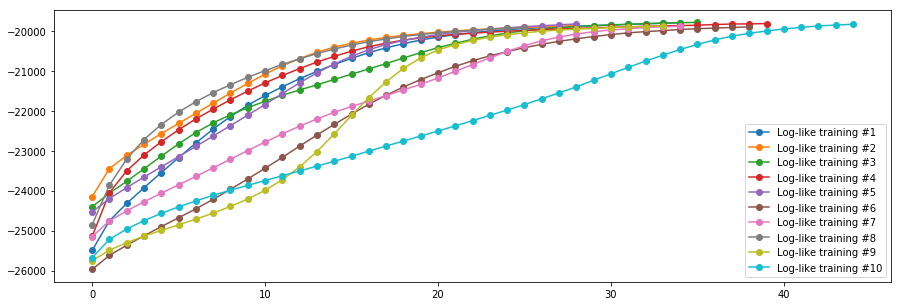

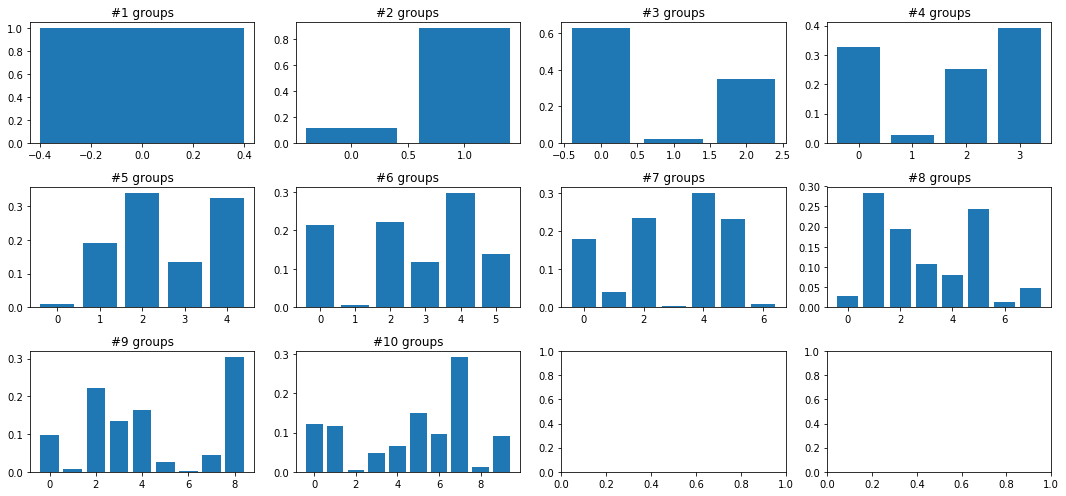

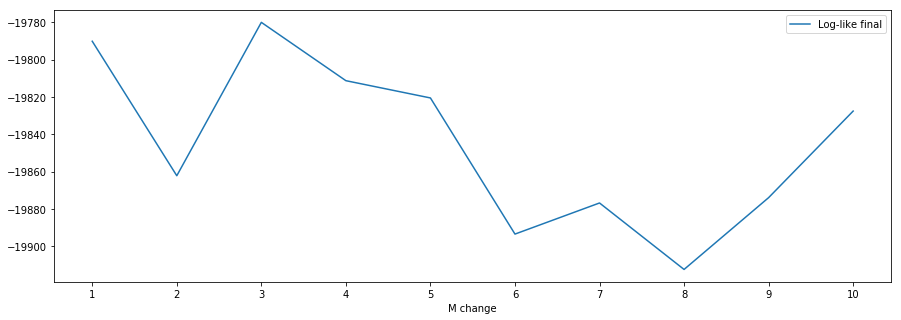

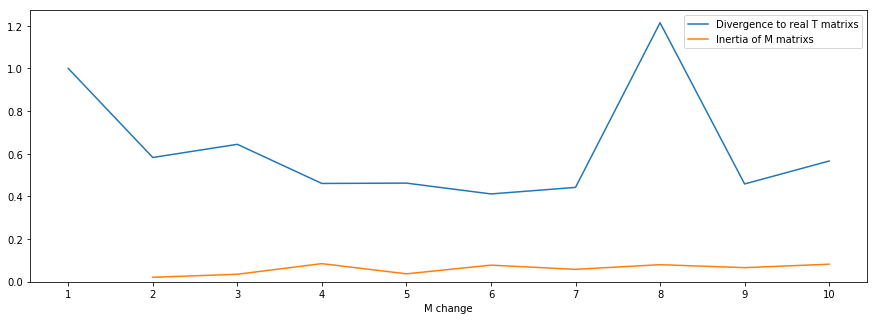

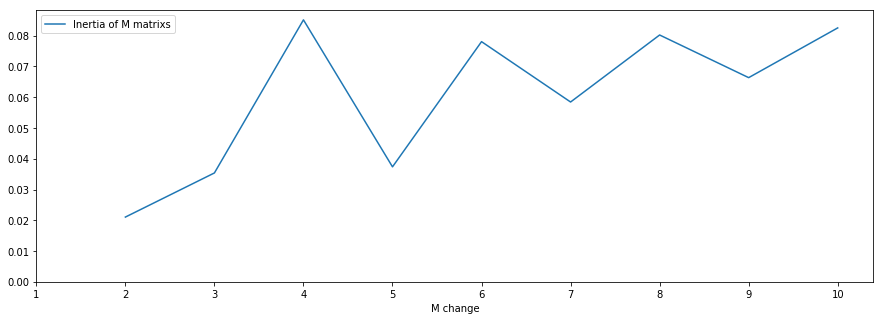

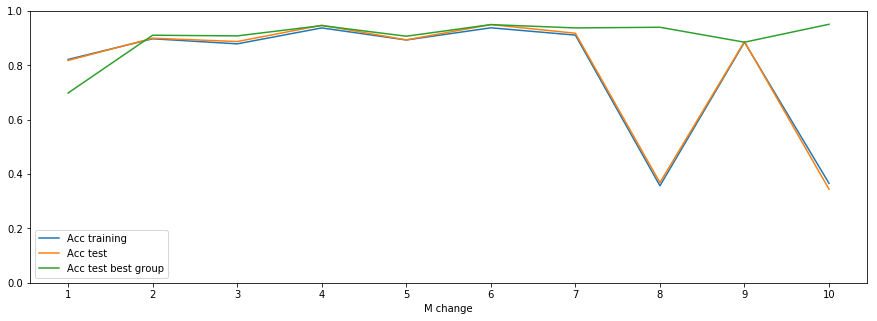

In [23]:
#first some plots
M_values = range(1,1+len(logL_Mchange))


plt.figure(figsize=(15,5))
for m in range(len(M_values)):
    plt.plot(range(len(logL_Mchange[m])),logL_Mchange[m],'o-',label="Log-like training #"+str(m+1))
plt.legend()
plt.show()

import math
aux = math.ceil(len(M_values)/3)
f,axx = plt.subplots(3,aux,figsize=(15,7))
for m in range(len(M_values)):
    #print(m/3)
    #print(int(m/math.ceil(len(M_values)/3)))
    axx[int(m/aux),m%aux].bar(range(len(probas_Mchange[m])),probas_Mchange[m])
    axx[int(m/aux),m%aux].set_title("#%d groups"%(m+1))
f.tight_layout()
plt.show()

plot_logL = [L[-1] for L in logL_Mchange]
plt.figure(figsize=(15,5))
plt.plot(M_values,plot_logL,label="Log-like final")
plt.xticks(M_values)
plt.xlabel("M change")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(M_values,divergence_Mchange,label="Divergence to real T matrixs")
plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
plt.xticks(M_values)
plt.xlabel("M change")
plt.ylim(0)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
plt.xticks(M_values)
plt.xlabel("M change")
plt.ylim(0)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(M_values,accTR_Mchange,label="Acc training")
plt.plot(M_values,accTE_Mchange,label="Acc test")
plt.plot(M_values,best_group_acc_Mchange,label="Acc test best group")
plt.xticks(M_values)
plt.xlabel("M change")
plt.ylim(0,1)
plt.legend()
plt.show()



In [24]:
#T if i know T
M_values = range(1,1+len(logL_Mchange))

print(T)
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

100


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0        1              1              1                   1   
1        2              2              2                   2   
2        3              3              3                   3   
3        4              4              4                   4   
4        5              5              4                   5   
5        6              5              5                   5   
6        7              5              5                   4   
7        8              8              7                   5   
8        9              7              7                   4   
9       10              9              8                   5   

   Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                1                                1  
1                                2                                2  
2                                3                                3  
3                                4                                4  
4                                5                                5  
5                                5                                5  
6                                6                                6  
7                                7                                6  
8                                7                                7  
9                                8                                8